# **Anticipez les besoins en consommation de bâtiments** 
## partie 1/3 : nettoyage, analyse, feature engineering


### <br> Notre mission (points clés)

> &emsp; "Vous travaillez pour la ville de Seattle." <br><br>
&emsp; "Votre équipe s’intéresse de près à la **consommation** et aux **émissions** des bâtiments non destinés à l’habitation." <br><br>
&emsp; "Vous voulez tenter de **prédire les émissions de CO2 et la consommation totale d’énergie** de bâtiments **non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées." <br><br>


## 1. Découvrons nos données

### 1.1 Importation des librairies, réglages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from collections import Counter
# from zipfile import ZipFile

print('\npandas version ' + pd.__version__)
print('sns version ' + sns.__version__)

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
sns.set(font_scale=1)



pandas version 2.1.1
sns version 0.12.2


### 1.2 Fonctions 

In [3]:
def lerp(a, b, t):
    return a + (b - a)*t

def printn(text):
  """ 
  Plus discret que print('\\n') partout dans le code
  Argument(s) : str
  """
  print(text, '\n')

def get_missing_values(df):
    """ 
    Génère un dataframe contenant le nombre et la proportion de na pour chaque feature
    Argument : df
    """
    missing = df.isna().sum()
    percent_missing = df.isna().mean()*100
    missings_df = pd.DataFrame({'column_name': df.columns,
                                     'missing': missing,
                                     'present' : df.shape[0] - missing,
                                     'percent_missing': percent_missing.round(2),
                                     'type': df.dtypes})
    missings_df.sort_values('missing', inplace=True)
    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))

def hist_distrib(dataframe, feature, bins, r, density=True):
    """
    Affiche un histogramme, pour visualiser la distribution empirique d'une variable
    Argument : df, feature num
    """
    # calcul des tendances centrales :
    mode =  str(round(dataframe[feature].mode()[0], r))
    # mode is often zero, so Check if there are non nul values in the column
    if (dataframe[feature] != 0).any():
        mode_non_nul = str(round(dataframe.loc[dataframe[feature] != 0, feature].mode()[0], r))
    else:
        mode_non_nul = "N/A"
    mediane = str(round(dataframe[feature].median(), r))
    moyenne = str(round(dataframe[feature].mean(), r))
    # dispersion :
    var_emp = str(round(dataframe[feature].var(ddof=0), r))
    coeff_var =  str(round(dataframe[feature].std(ddof=0), r)) # = écart-type empirique / moyenne
    # forme
    skewness = str(round(dataframe[feature].skew(), 2))
    kurtosis = str(round(dataframe[feature].kurtosis(), 2))
    
    dataframe[feature].hist(density=density, bins=bins)
    yt = plt.yticks()
    y = lerp(yt[0][0], yt[0][-1], 0.8)
    t = y/20
    xt = plt.xticks()
    x = lerp(xt[0][0], xt[0][-1], 0.8)
    plt.title(feature, pad=20, fontsize=35)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.annotate('Mode : ' + mode, xy = (x, y), fontsize = 20, xytext = (x, y), color = 'g')
    plt.annotate('Mode + : ' + mode_non_nul, xy = (x, y-t), fontsize = 20, xytext = (x, y-t), color = 'g')
    plt.annotate('Médiane : ' + mediane, xy = (x, y-2*t), fontsize = 20, xytext = (x, y-2*t), color = 'g')
    plt.annotate('Moyenne : ' + moyenne, xy = (x, y-3*t), fontsize = 20, xytext = (x, y-3*t), color = 'g')
    
    plt.annotate('Var emp : ' + var_emp, xy = (x, y-5*t), fontsize = 20, xytext = (x, y-5*t), color = 'g')
    plt.annotate('Coeff var : ' + coeff_var, xy = (x, y-6*t), fontsize = 20, xytext = (x, y-6*t), color = 'g')

    plt.annotate('Skewness : ' + skewness, xy = (x, y-8*t), fontsize = 20, xytext = (x, y-8*t), color = 'g')
    plt.annotate('Kurtosis : ' + kurtosis, xy = (x, y-9*t), fontsize = 20, xytext = (x, y-9*t), color = 'g')
    plt.show()

    return float(skewness)

def boxplot_distrib(dataframe, feature):
    """
    Affiche un boxplot, pour visualiser les tendances centrales et la dispersion d'une variable
    Argument : feature num
    """
    medianprops = {'color':"blue"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    dataframe.boxplot(feature, vert=False, showfliers=False, medianprops=medianprops, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

def courbe_lorenz(dataframe, feature):
    """
    Affiche une courbe de Lorenz, pour visualiser la concentration d'une variable
    Argument : feature num
    """
    values = dataframe.loc[dataframe[feature].notna(), feature].values
    # print(values)
    n = len(values)
    lorenz = np.cumsum(np.sort(values)) / values.sum()
    lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

    xaxis = np.linspace(0-1/n,1+1/n,n+1) 
    #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. 
    # #Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
    plt.plot(xaxis,lorenz,drawstyle='steps-post')
    plt.plot(np.arange(2),[x for x in np.arange(2)])
    # calcul de l'indice de Gini
    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
    S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
    gini = 2*S
    plt.annotate('gini =  ' + str(round(gini, 2)), xy = (0.04, 0.88), fontsize = 20, xytext = (0.04, 0.88), color = 'g')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show() 

def graphs_analyse_uni(dataframe, feature, bins=50, r=5, density=True):
    """
    Affiche histogramme + boxplot + courbe de Lorenz
    Arguments : feature num, int (optional), int (optional), bool (optional)
    """   
    hist_distrib(dataframe, feature, bins, r)
    boxplot_distrib(dataframe, feature)
    courbe_lorenz(dataframe, feature)

def shape_head(df, nb_rows=5):
    """
    Affiche les dimensions et les premières lignes d'un dataframe
    Arguments : dataframe, nb de lignes à afficher (max 60)
    """
    print(df.shape)
    display(df.head(nb_rows))

def doughnut(df, feature, title):
    """
    Affiche la répartition d'une feature sous forme de diagramme circulaire
    Arguments : dataframe, feature
    """
    colors = [
        'lightblue', 'lightgreen', 'lightskyblue', 'lightcoral', 'lightseagreen', 
        'lightsteelblue', 'lightyellow', 'lightcyan', 'lightgoldenrodyellow', 
        'lightpink', 'lightgrey', 'lightseagreen', 'lightcoral', 'lightseagreen',
        'lightpink', 'lightblue', 'lightgreen', 'lightsteelblue', 'lightyellow',
        'lightgrey', 'lightcyan', 'lightgoldenrodyellow', 'lightblue', 'lightpink',
        'lightgrey', 'lightgreen', 'lightcoral', 'lightcyan', 'lightseagreen', 
        'lightsteelblue', 'lightyellow', 'lightgoldenrodyellow'
    ]
    grouped_df = df.groupby(feature).size().to_frame("count_per_type").reset_index()
    pie = grouped_df.set_index(feature).copy()

    patches, texts, autotexts = plt.pie(x=pie['count_per_type'], autopct='%1.1f%%',
        startangle=-30, labels=pie.index, textprops={'fontsize':11, 'color':'#000'}, 
        labeldistance=1.25, pctdistance=0.85)
    
    plt.title(
    label=title, 
    fontdict={"fontsize":17},
    pad=20
    )

    for text in texts:
        # text.set_fontweight('bold')
        text.set_horizontalalignment('center')

    # Customize percent labels
    for autotext in autotexts:
        autotext.set_horizontalalignment('center')
        autotext.set_fontstyle('italic')
        autotext.set_fontsize('10')

    #draw circle
    centre_circle = plt.Circle((0,0),0.7,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.show()

def get_non_null_values(df):
    """ 
    Génère un dataframe contenant le nombre et la proportion de non-null (non-zero) valeurs pour chaque feature
    Argument : df
    """
    non_null_counts = df.ne(0).sum()
    percent_non_null = (non_null_counts / df.shape[0]) * 100
    non_null_values_df = pd.DataFrame({'column_name': df.columns,
                                       'non_null_count': non_null_counts,
                                       'percent_non_null': percent_non_null.round(2),
                                       'type': df.dtypes})
    non_null_values_df.sort_values('non_null_count', inplace=True)
    return non_null_values_df


### 1.3 Chargement, affichage du résultat

In [4]:
# %%timeit

raw_df = pd.read_csv('2016_Building_Energy_Benchmarking.csv', sep=',')

printn('shape : ' + str(raw_df.shape))

print('head, tail :')
display(raw_df.head())
display(raw_df.tail())

print('uniques :')
display(raw_df.nunique()) 


shape : (3376, 46) 

head, tail :


OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
3371          50222      2016  Nonresidential COS              Office   
3372          50223      2016  Nonresidential COS               Other   
3373          50224      2016  Nonresidential COS               Other   
3374          50225      2016  Nonresidential COS  Mixed Use Property   
3375          50226      2016  Nonresidential COS  Mixed Use Property   

                             PropertyName           Address     City State  \
3371                Horticulture building  1600 S Dakota St  Seattle    WA   
3372  International district/Chinatown CC     719 8th Ave S  Seattle    WA   
3373                      Queen Anne Pool    1920 1st Ave W  Seattle    WA   
3374          South Park Community Center    8319 8th Ave S  Seattle    WA   
3375          Van Asselt Community Center  2820 S Myrtle St  Seattle    WA   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
3371      NaN                    1624049080                    2   
3372      NaN                    3558300000                    2   
3373      NaN                    1794501150                    7   
3374      NaN                    7883603155                    1   
3375      NaN                    7857002030                    2   

               Neighborhood  Latitude  Longitude  YearBuilt  \
3371       GREATER DUWAMISH  47.56722 -122.31154       1990   
3372               DOWNTOWN  47.59625 -122.32283       2004   
3373  MAGNOLIA / QUEEN ANNE  47.63644 -122.35784       1974   
3374       GREATER DUWAMISH  47.52832 -122.32431       1989   
3375       GREATER DUWAMISH  47.53939 -122.29536       1938   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
3371                1.0               1             12294                   0   
3372                1.0               1             16000                   0   
3373                1.0               1             13157                   0   
3374                1.0               1             14101                   0   
3375                1.0               1             18258                   0   

      PropertyGFABuilding(s)  \
3371                   12294   
3372                   16000   
3373                   13157   
3374                   14101   
3375                   18258   

                              ListOfAllPropertyUseTypes  \
3371                                             Office   
3372                                 Other - Recreation   
3373  Fitness Center/Health Club/Gym, Other - Recrea...   
3374  Fitness Center/Health Club/Gym, Food Service, ...   
3375  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
3371                 Office                    12294.0   
3372     Other - Recreation                    16000.0   
3373     Other - Recreation                     7583.0   
3374     Other - Recreation                     6601.0   
3375     Other - Recreation                     8271.0   

        SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
3371                             NaN                              NaN   
3372                             NaN                              NaN   
3373  Fitness Center/Health Club/Gym                           5574.0   
3374  Fitness Center/Health Club/Gym                           6501.0   
3375  Fitness Center/Health Club/Gym                           8000.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
3371                         NaN                             NaN   
3372                         NaN                             NaN   
3373               Swimming Pool                             0.0   
3374          Pre-school/Daycare                           484.0   
3375          Pre-school/Daycare                          1108.0   

     YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
3371      

uniques :


OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


### 1.4 Description générale (données brutes), détection d'éventuels doublons, <br>
### drop des features à valeur unique

In [5]:
# Description générale :
# 3376 immeubles ou groupes d'immeubles (=lignes, individus)
# sont décrits ici par 46 features (=colonnes, variables)

# La clé OSEBuildingID est bien une clé,
# elle a bien 3376 valeurs uniques
print(raw_df.drop('OSEBuildingID', axis=1).duplicated().sum())
# et il n'y a pas de doublon sur une ligne entière.

# Relevés tous faits la meme annee (2016) donc premiere colonne inutile pour faire des predictions !
# Il y a d'autres colonnes à valeur unique -> aussi à supprimer 
# + la colonne "comments" est vide !

print(raw_df.shape)

df = raw_df.loc[:, raw_df.nunique() > 1].copy()

# 8 types de buildings, verifier ce qui est non-residentiel. A visualiser ds l'analyse.
# Repartis en 24 sous-categories

# 14 personnes ont perdu au baccalaureat belge (leurs proprietes ont le mm nom)

# 22 immeubles ont la mm adresse

# Certains immeubles ont + de 100 ans, le(s) plus aancien(s) a (ont?) été construit(s) en 1900.
# Est-ce qu'il(s) consomme(nt) + ? Suspens

# 2016 était apparemment une année légerement plus fraiche que la moyenne à Seattle.
# Pour alimenter 1 immeuble, la ville dépense + du double en énergie (+- x2.25) !
# Je ne savais pas que le rendement était si faible.

# La colonne default data, comprends pas. ?

# SiteEUI(kBtu/sf) = notre cible consommation d'énergie ?
# ou SourceEUI(kBtu/sf) ?
# ajouter SteamUse ?

# GHGEmissionsIntensity = cible GFS

printn('shape : ' + str(df.shape)) # On a supprimé 4 colonnes : year, city, state, comments

printn('infos :')
display(df.info()) # + compte non-nuls et types des variables


0
(3376, 46)
shape : (3376, 42) 

infos : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   BuildingType                     3376 non-null   object 
 2   PrimaryPropertyType              3376 non-null   object 
 3   PropertyName                     3376 non-null   object 
 4   Address                          3376 non-null   object 
 5   ZipCode                          3360 non-null   float64
 6   TaxParcelIdentificationNumber    3376 non-null   object 
 7   CouncilDistrictCode              3376 non-null   int64  
 8   Neighborhood                     3376 non-null   object 
 9   Latitude                         3376 non-null   float64
 10  Longitude                        3376 non-null   float64
 11  YearBuilt                        3376 

None

In [6]:
df.describe()


OSEBuildingID       ZipCode  CouncilDistrictCode     Latitude  \
count    3376.000000   3360.000000          3376.000000  3376.000000   
mean    21208.991114  98116.949107             4.439277    47.624033   
std     12223.757015     18.615205             2.120625     0.047758   
min         1.000000  98006.000000             1.000000    47.499170   
25%     19990.750000  98105.000000             3.000000    47.599860   
50%     23112.000000  98115.000000             4.000000    47.618675   
75%     25994.250000  98122.000000             7.000000    47.657115   
max     50226.000000  98272.000000             7.000000    47.733870   

         Longitude    YearBuilt  NumberofBuildings  NumberofFloors  \
count  3376.000000  3376.000000        3368.000000     3376.000000   
mean   -122.334795  1968.573164           1.106888        4.709123   
std       0.027203    33.088156           2.108402        5.494465   
min    -122.414250  1900.000000           0.000000        0.000000   
25%    -122.350662  1948.000000           1.000000        2.000000   
50%    -122.332495  1975.000000           1.000000        4.000000   
75%    -122.319407  1997.000000           1.000000        5.000000   
max    -122.220966  2015.000000         111.000000       99.000000   

       PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count      3.376000e+03         3376.000000            3.376000e+03   
mean       9.483354e+04         8001.526066            8.683201e+04   
std        2.188376e+05        32326.723928            2.079398e+05   
min        1.128500e+04            0.000000            3.636000e+03   
25%        2.848700e+04            0.000000            2.775600e+04   
50%        4.417500e+04            0.000000            4.321600e+04   
75%        9.099200e+04            0.000000            8.427625e+04   
max        9.320156e+06       512608.000000            9.320156e+06   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count               3.356000e+03                      1679.000000   
mean                7.917764e+04                     28444.075817   
std                 2.017034e+05                     54392.917928   
min                 5.656000e+03                         0.000000   
25%                 2.509475e+04                      5000.000000   
50%                 3.989400e+04                     10664.000000   
75%                 7.620025e+04                     26640.000000   
max                 9.320156e+06                    686750.000000   

       ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
count                      596.000000      2533.000000       3369.000000   
mean                     11738.675166        67.918674         54.732116   
std                      29331.199286        26.873271         56.273124   
min                          0.000000         1.000000          0.000000   
25%                       2239.000000        53.000000         27.900000   
50%                       5043.000000        75.000000         38.599998   
75%                      10138.750000        90.000000         60.400002   
max                     459748.000000       100.000000        834.400024   

       SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
count         3370.000000         3367.000000           3367.000000   
mean            57.033798          134.232848            137.783932   
std             57.163330          139.287554            139.109807   
min              0.000000            0.000000             -2.100000   
25%             29.400000           74.699997             78.400002   
50%             40.900002           96.199997            101.099998   
75%             64.275002          143.899994            148.349998   
max            834.400024         2620.000000           2620.000000   

       SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
count         3.371000e+03           3.370000e+03    3.367000e+03   
me

In [7]:
# 99 étages ?? D'après bing AI,
# "There is no building in Seattle that has 99 floors. The tallest building in Seattle is the 
# Columbia Center which has 76 stories and rises 937 feet (286 m).

# Il s'agit d'une propriété structurelle qui nous intéresse donc d'un ou plusieurs outliers à traiter.

# Possibles outliers /surface. Pas sûr.

# La normalisation WN produit des résultats surprenants ! (négatifs)
# Or un bâtiment dont la consommation est nulle ne va pas magiquement se mettre à produire de l'énergie.
# Ces variables semblent donc suspectes.

# Vérifier les cas où electricity < 0, c'est surprenant.
# Vérifier les cas où TotalGHGEmissions < 0, c'est très surprenant.


### 1.5 Valeurs manquantes, types

In [8]:
# Peu de valeurs manquantes (du moins en apparence ! Attention aux variables de type objet),
# ou sur un nombre restreint de features (seulement 6 features, si on excepte 'outlier'),
# et les valeur manquantes peuvent avoir du sens pour ces features
# Second / ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified

# (ENERGYSTARScore?)

# Verifier ds l'analyse si on retrouve les mm outliers

# type object non adapté parfois :

print(df['ComplianceStatus'].unique())
print(df['ZipCode'].unique())
print(df['CouncilDistrictCode'].unique())
print(df['CouncilDistrictCode'].nunique())
print(df['TaxParcelIdentificationNumber'].unique())
print(df['TaxParcelIdentificationNumber'].nunique())
print(df['NumberofBuildings'].unique())

# catégorique serait preférable (nombre limité de classes) :
# BuildingType, Neighborhood, ComplianceStatus, Outlier
# de ttes façons ces colonnes seront OneHotEncoded,
# On s'occupera donc de la conversion à ce moment-là.

# Plus curieux, YearsENERGYSTARCertified (variable texte)
print(df['YearsENERGYSTARCertified'].unique())

# Confusions entre float et int (pas grave)
# float -> int : ZipCode, probablement TaxParcelIdentificationNumber, NumberofBuildings


['Compliant' 'Error - Correct Default Data' 'Missing Data' 'Non-Compliant']
[98101. 98121. 98104. 98154. 98118. 98105. 98112. 98125. 98109. 98070.
 98108. 98199. 98115. 98107. 98144. 98103. 98119. 98136. 98122. 98126.
 98133. 98146. 98033. 98106. 98111. 98134. 98117. 98116. 98191. 98164.
 98195. 98185. 98181. 98102. 98168. 98155. 98006. 98124. 98053. 98012.
 98013. 98028. 98178. 98114. 98127. 98165. 98011. 98198. 98113. 98040.
 98204. 98177. 98020. 98272. 98145.    nan]
[7 3 2 4 5 6 1]
7
['0659000030' '0659000220' '0659000475' ... '1624049080' '7883603155'
 '7857002030']
3268
[  1.   3.   0.   2.   4.  27.   6.  11.  14.   9.   5.  nan   7.   8.
  16.  23.  10. 111.]
[nan '2016' '2014' '2012' '20172015'
 '2017201620152014201320122011201020092008' '201020092007' '201720102007'
 '20162015' '20152014201220112009' '201220092008'
 '201620152014201320112010200920072000' '201620092008' '201620142012'
 '20162015201420122008'
 '2016201520142013201220112010200920082007200620052004' '201520142013

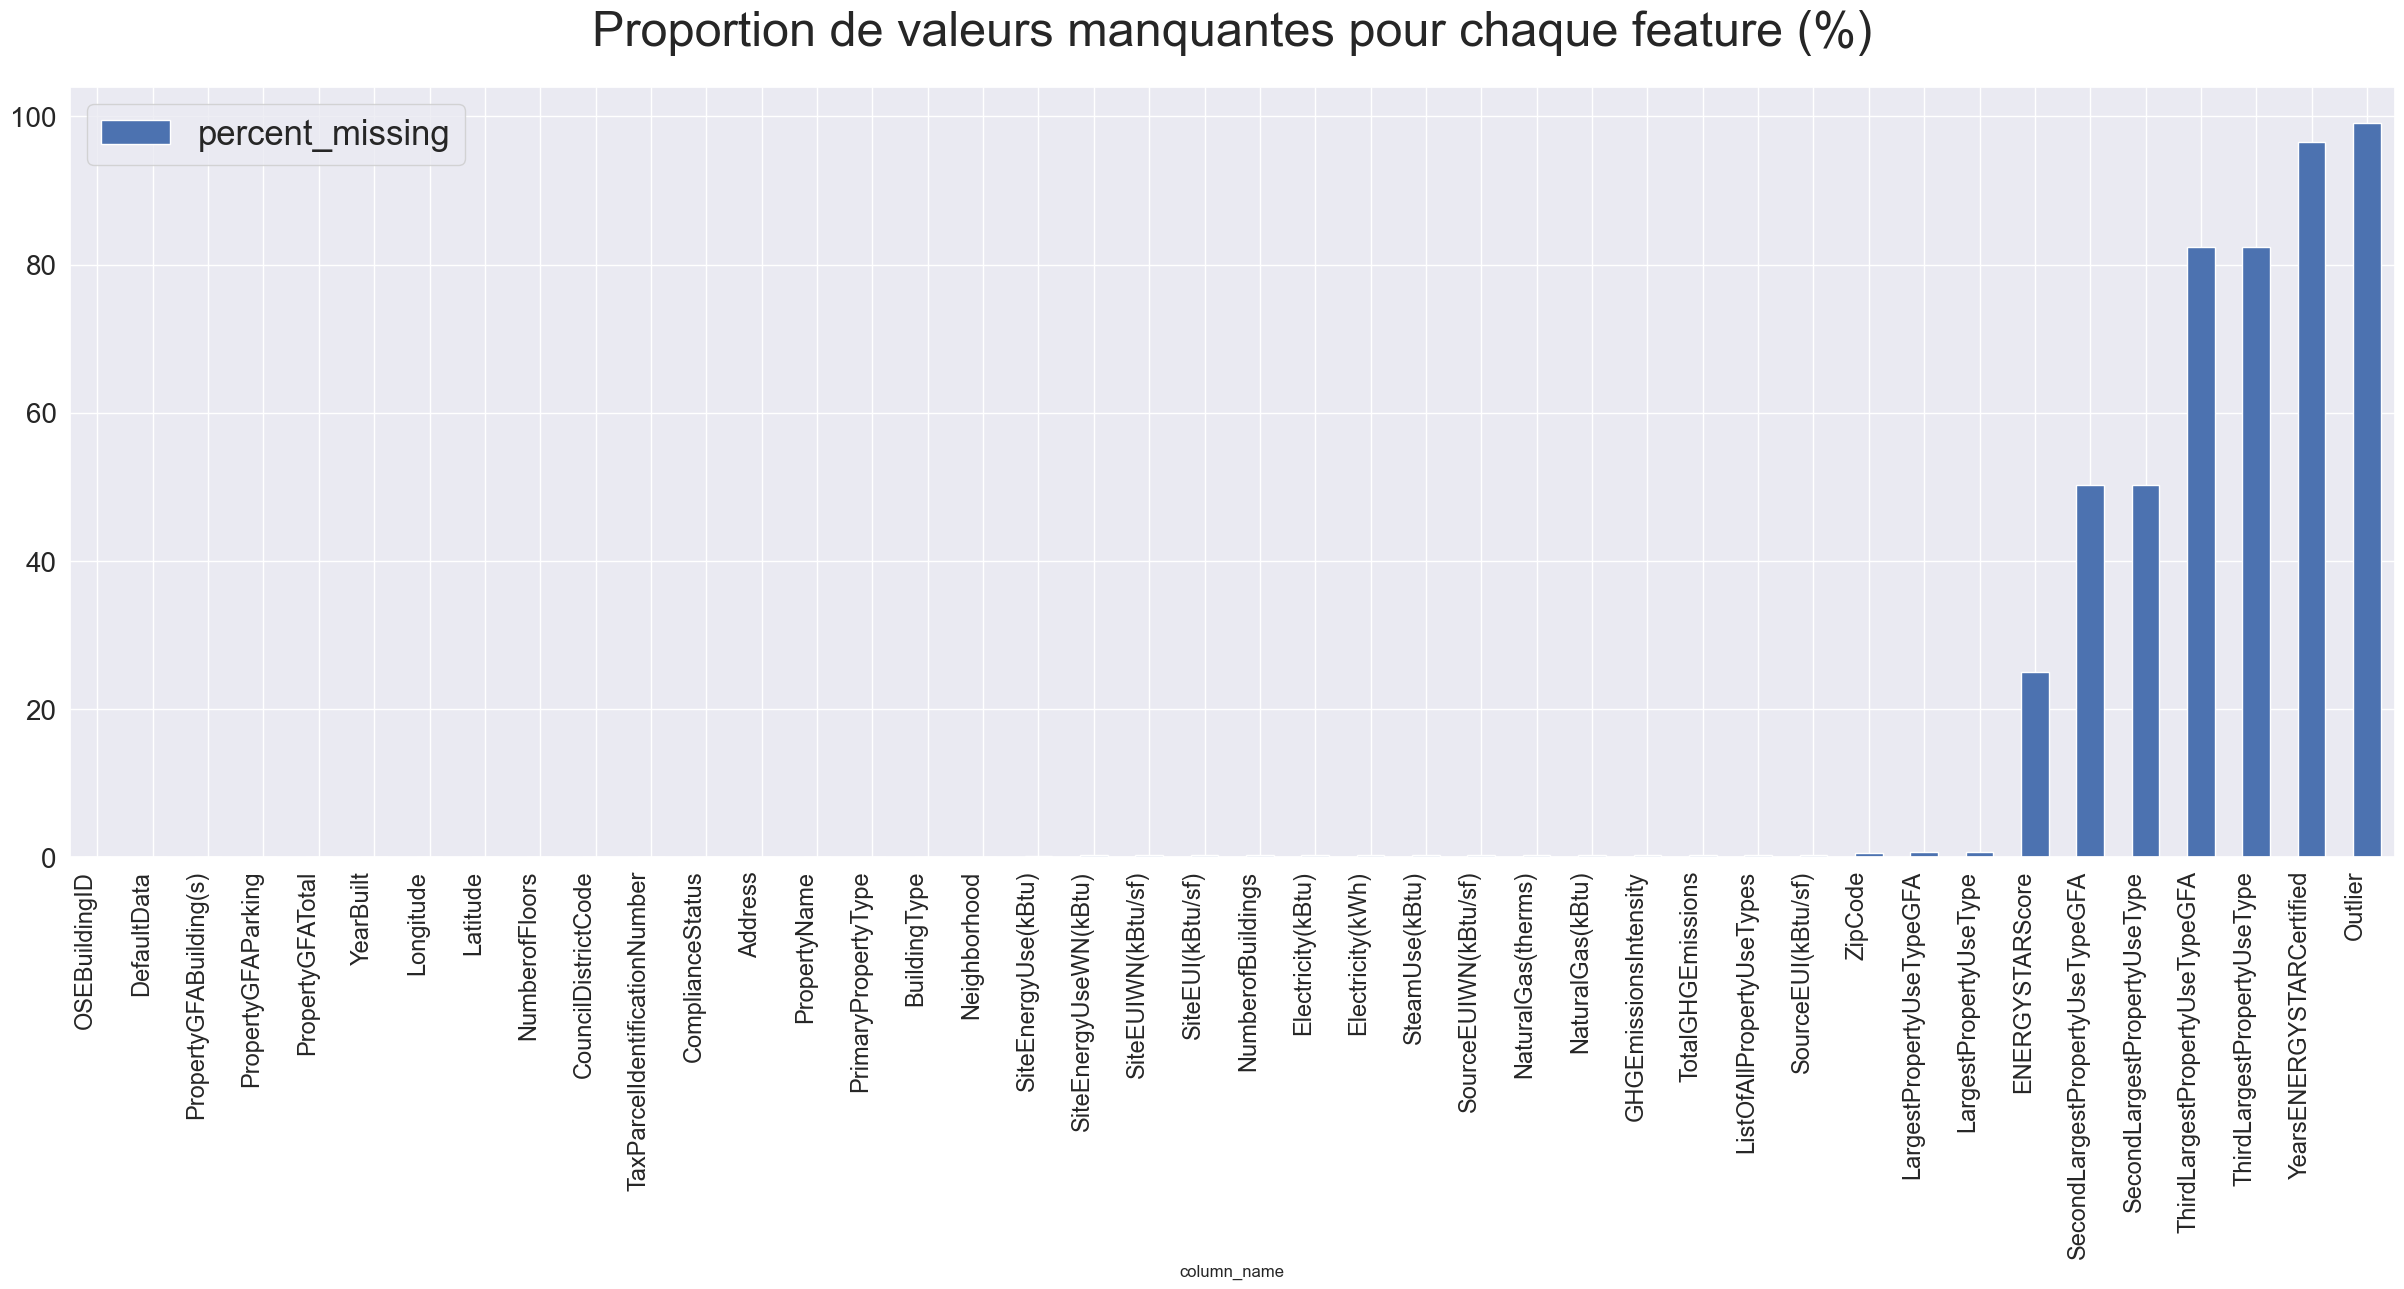

In [9]:
missing_values_df = get_missing_values(df)

plt.rcParams["figure.figsize"] = (30,10)
plt.rcParams['axes.titlepad'] = 30

ax = missing_values_df.plot.bar(x='column_name', y='percent_missing', rot=0, fontsize=17)

plt.legend(fontsize=25, loc='upper left')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right', fontsize=17)
plt.yticks(fontsize=20)
plt.title("Proportion de valeurs manquantes pour chaque feature (%)", fontsize=35)

plt.show()


### 1.6 Les batiments non-destinés à l'habitation

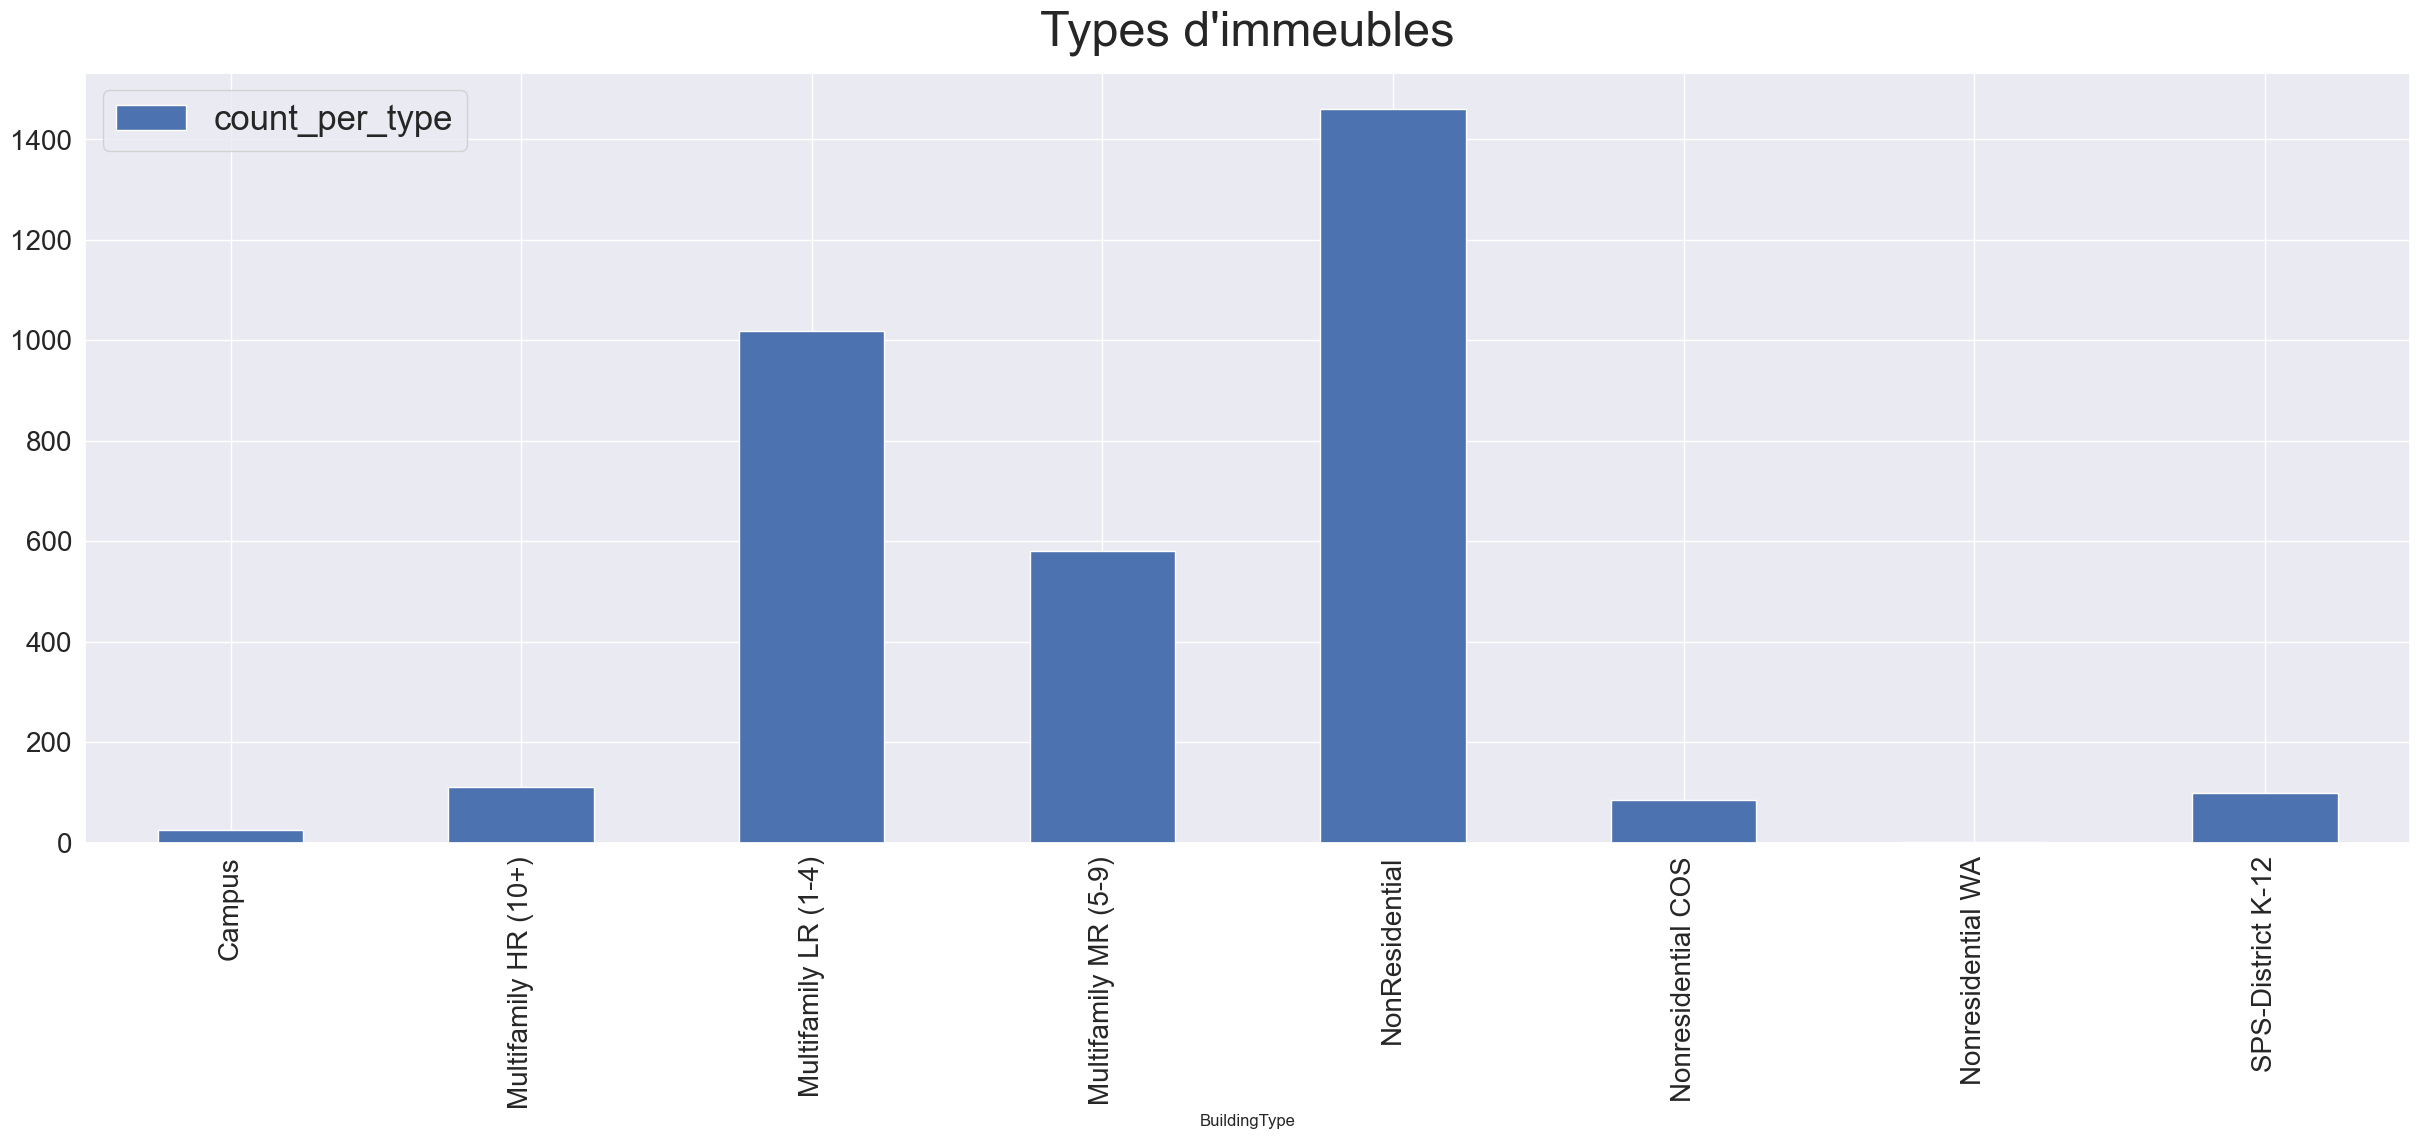

Le jeu de données compte à présent 1668 lignes et 42 colonnes.


In [10]:
# Ce sont les seuls qui sont concernés par notre étude, 
# cependant nos données contiennent de nombreux immeubles résidentiels. 
# Visualisons cela :

grouped_df_building_type = df.groupby('BuildingType').size().to_frame("count_per_type").reset_index()

grouped_df_building_type.plot(kind='bar', x='BuildingType', y='count_per_type')

plt.legend(fontsize=25, loc='upper left')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Types d\'immeubles', pad=20, fontsize=35)
plt.show()

# Nous allons donc créer le subset qui nous intéresse, limité aux immeubles non résidentiels :

subset_NR = df.loc[~df['BuildingType'].str.contains("Multifamily"), :].copy()
# SPS-District K-12 et campus sont des écoles / facs donc essentiellement NR

# print(subset_NR.shape)
print("Le jeu de données compte à présent {} lignes et {} colonnes.".format(
    subset_NR.shape[0],
    subset_NR.shape[1]))

# Et ajouter au df d'origine une colonne utile pour seaborn
df['residentiel'] = False
df.loc[df['BuildingType'].str.contains("Multifamily"), 'residentiel'] = True


In [11]:
grouped_NR_building_type = subset_NR.groupby('BuildingType').size().to_frame("count_per_type").reset_index()
display(grouped_NR_building_type)

# La classe ne comprenant qu'un seul individu va poser problème lors de la stratification
# (notebook 2)

subset_NR.loc[subset_NR['BuildingType'].str.contains("WA"), 'BuildingType'] = 'NonResidential'

grouped_NR_building_type = subset_NR.groupby('BuildingType').size().to_frame("count_per_type").reset_index()
display(grouped_NR_building_type)


BuildingType  count_per_type
0              Campus              24
1      NonResidential            1460
2  Nonresidential COS              85
3   Nonresidential WA               1
4   SPS-District K-12              98

BuildingType  count_per_type
0              Campus              24
1      NonResidential            1461
2  Nonresidential COS              85
3   SPS-District K-12              98

Non-résidentiel


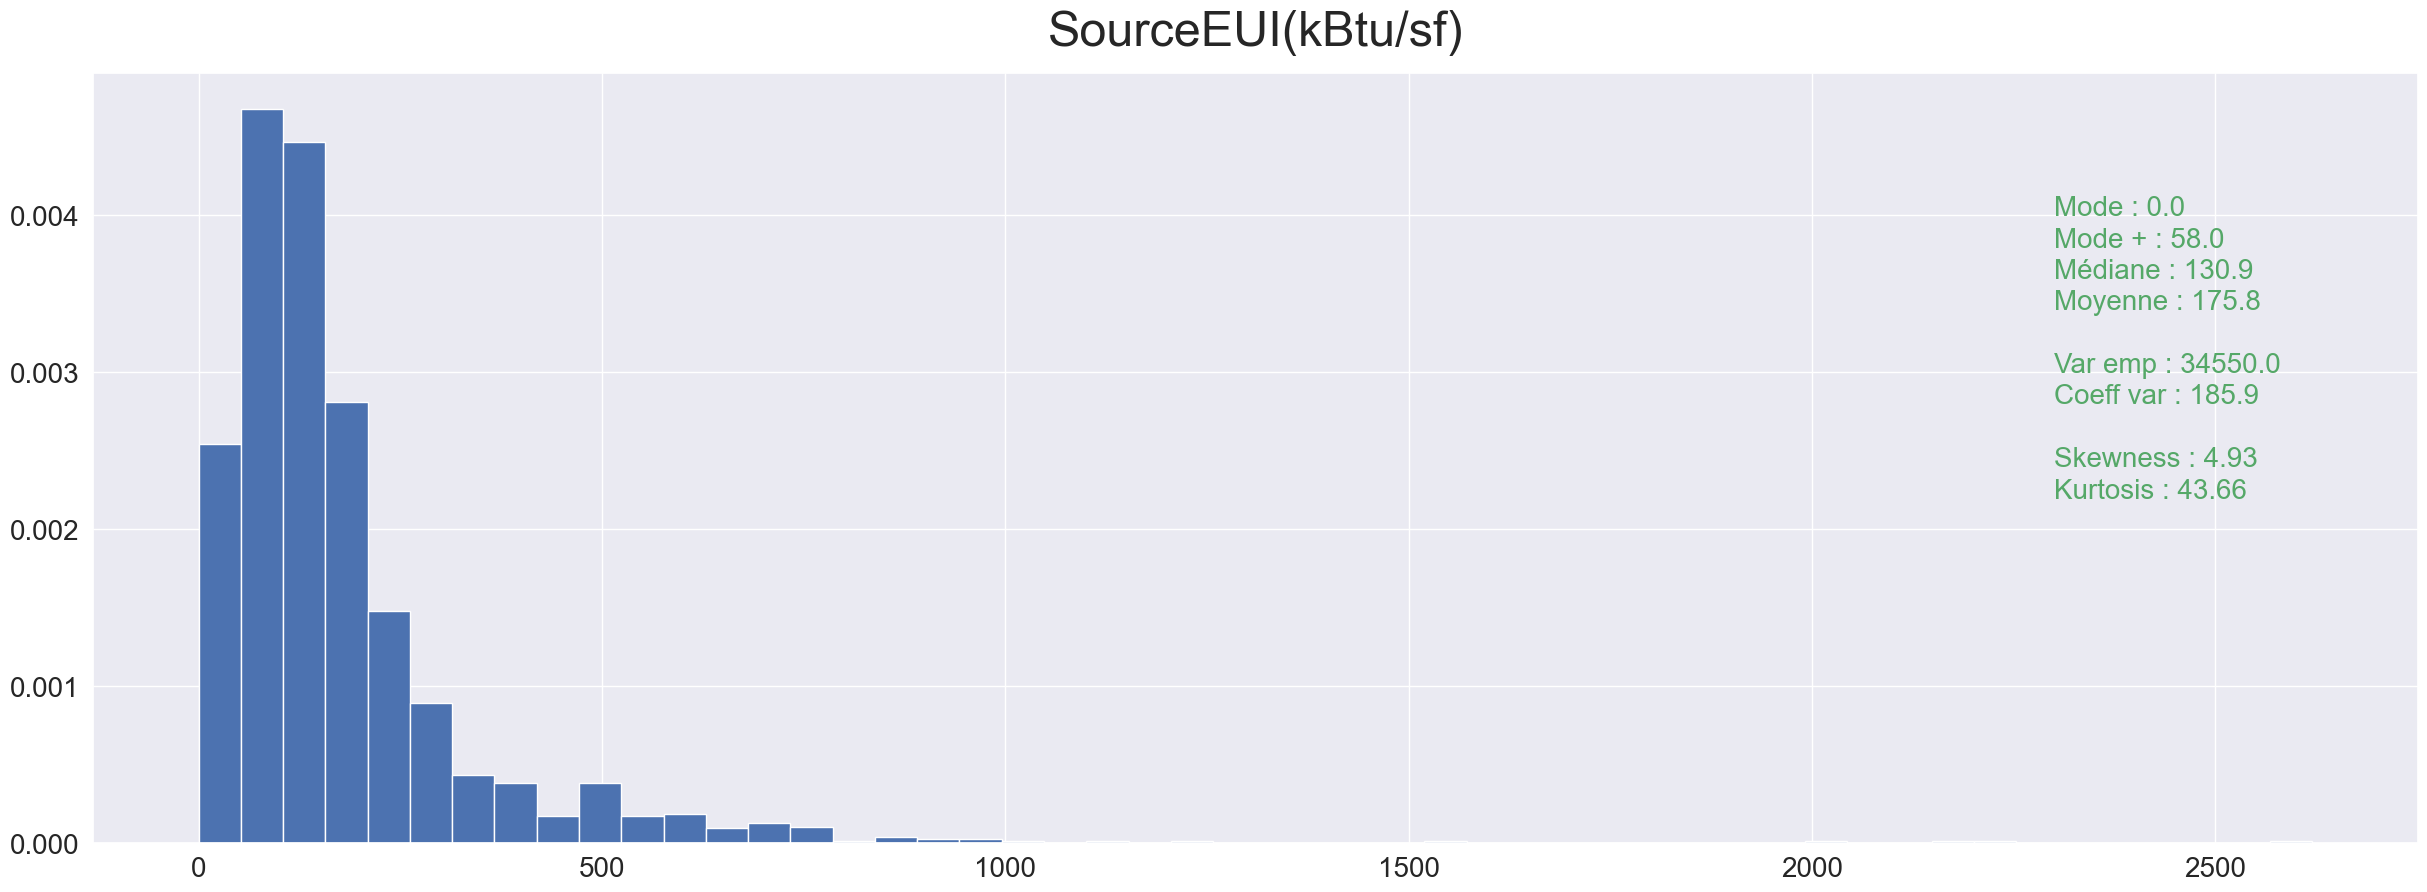

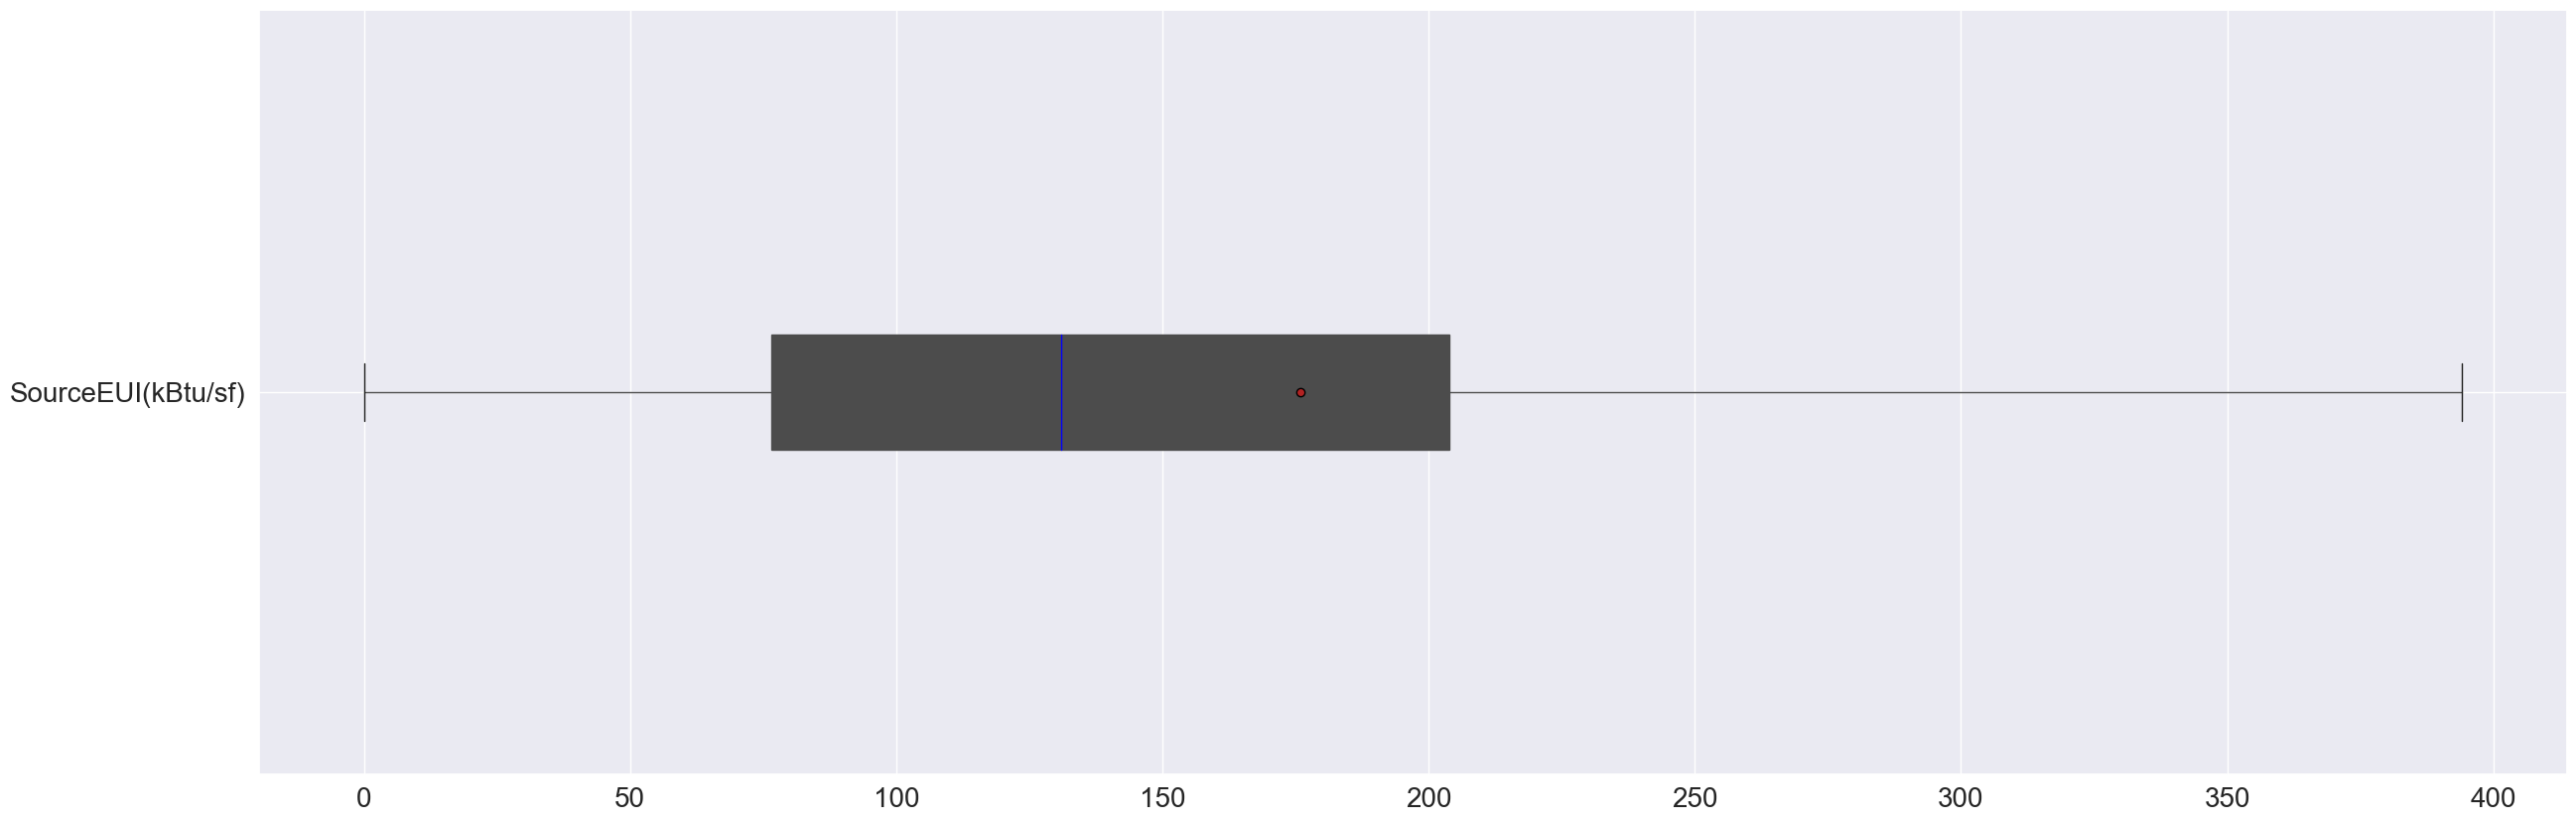

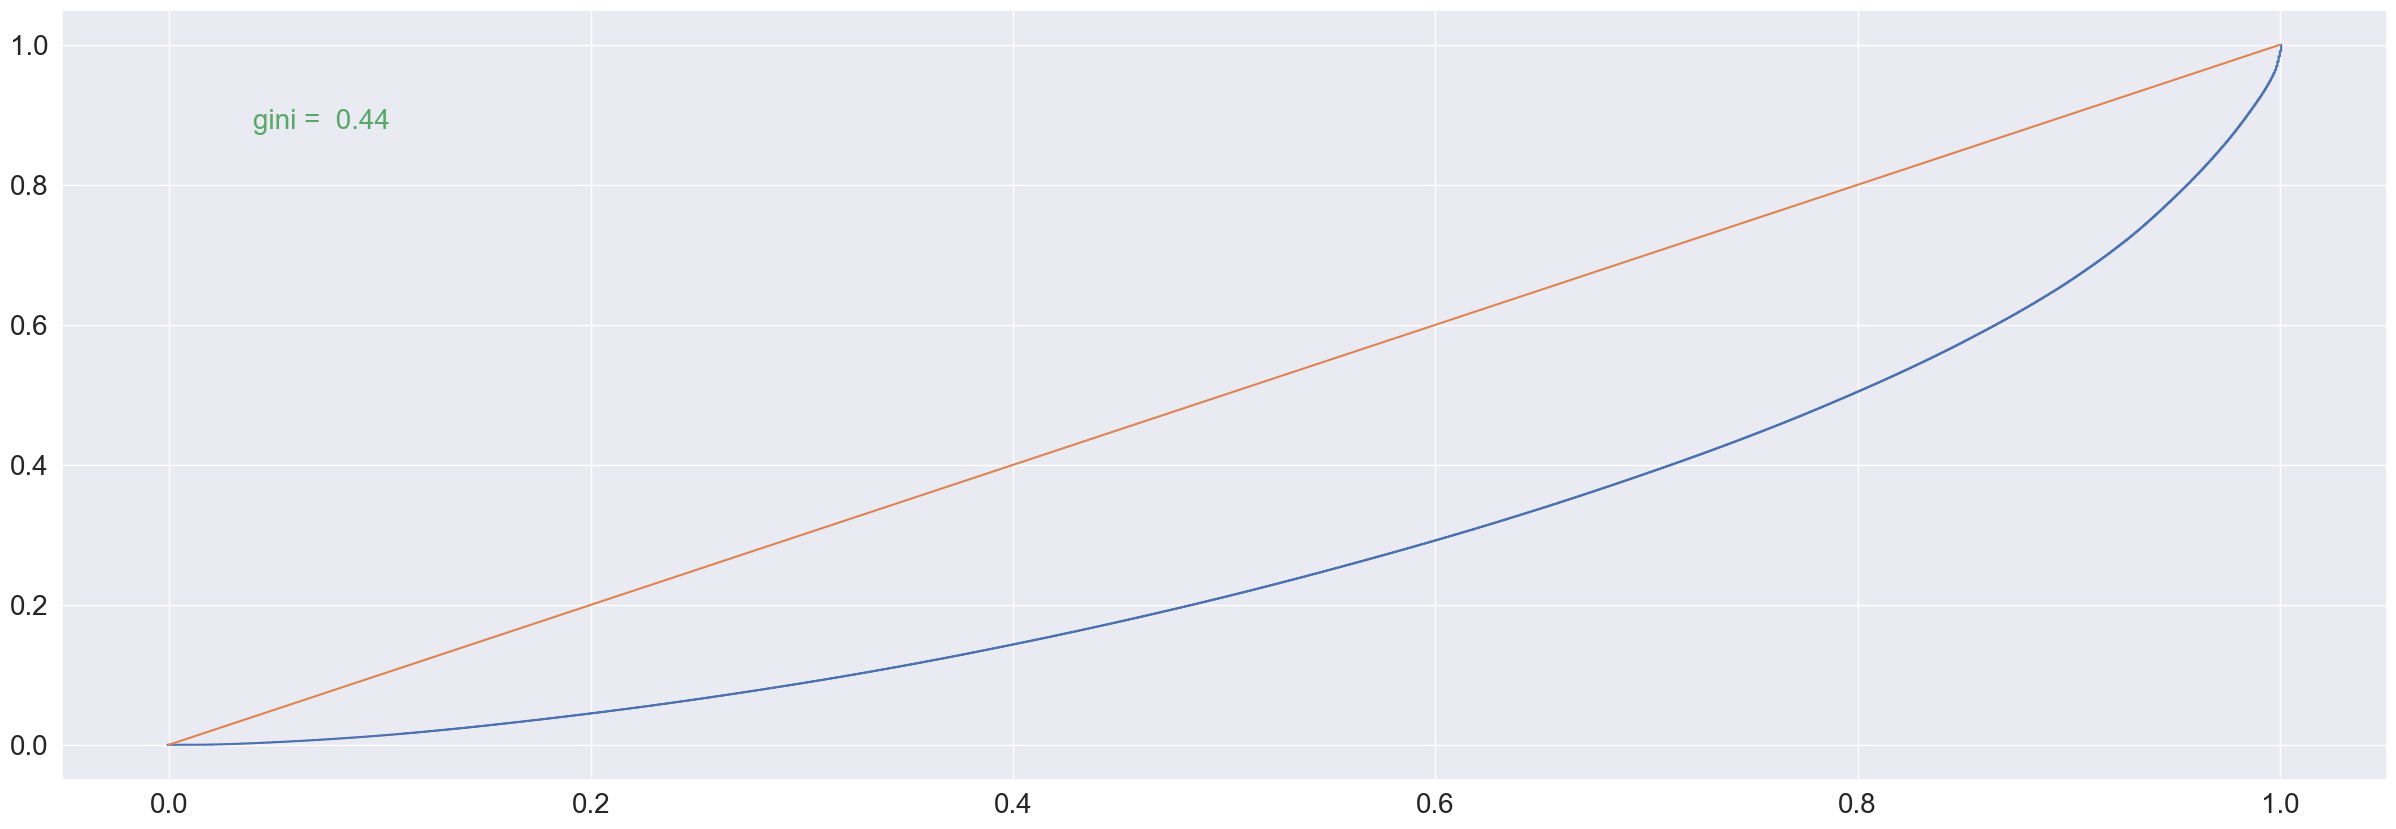

Résidentiel


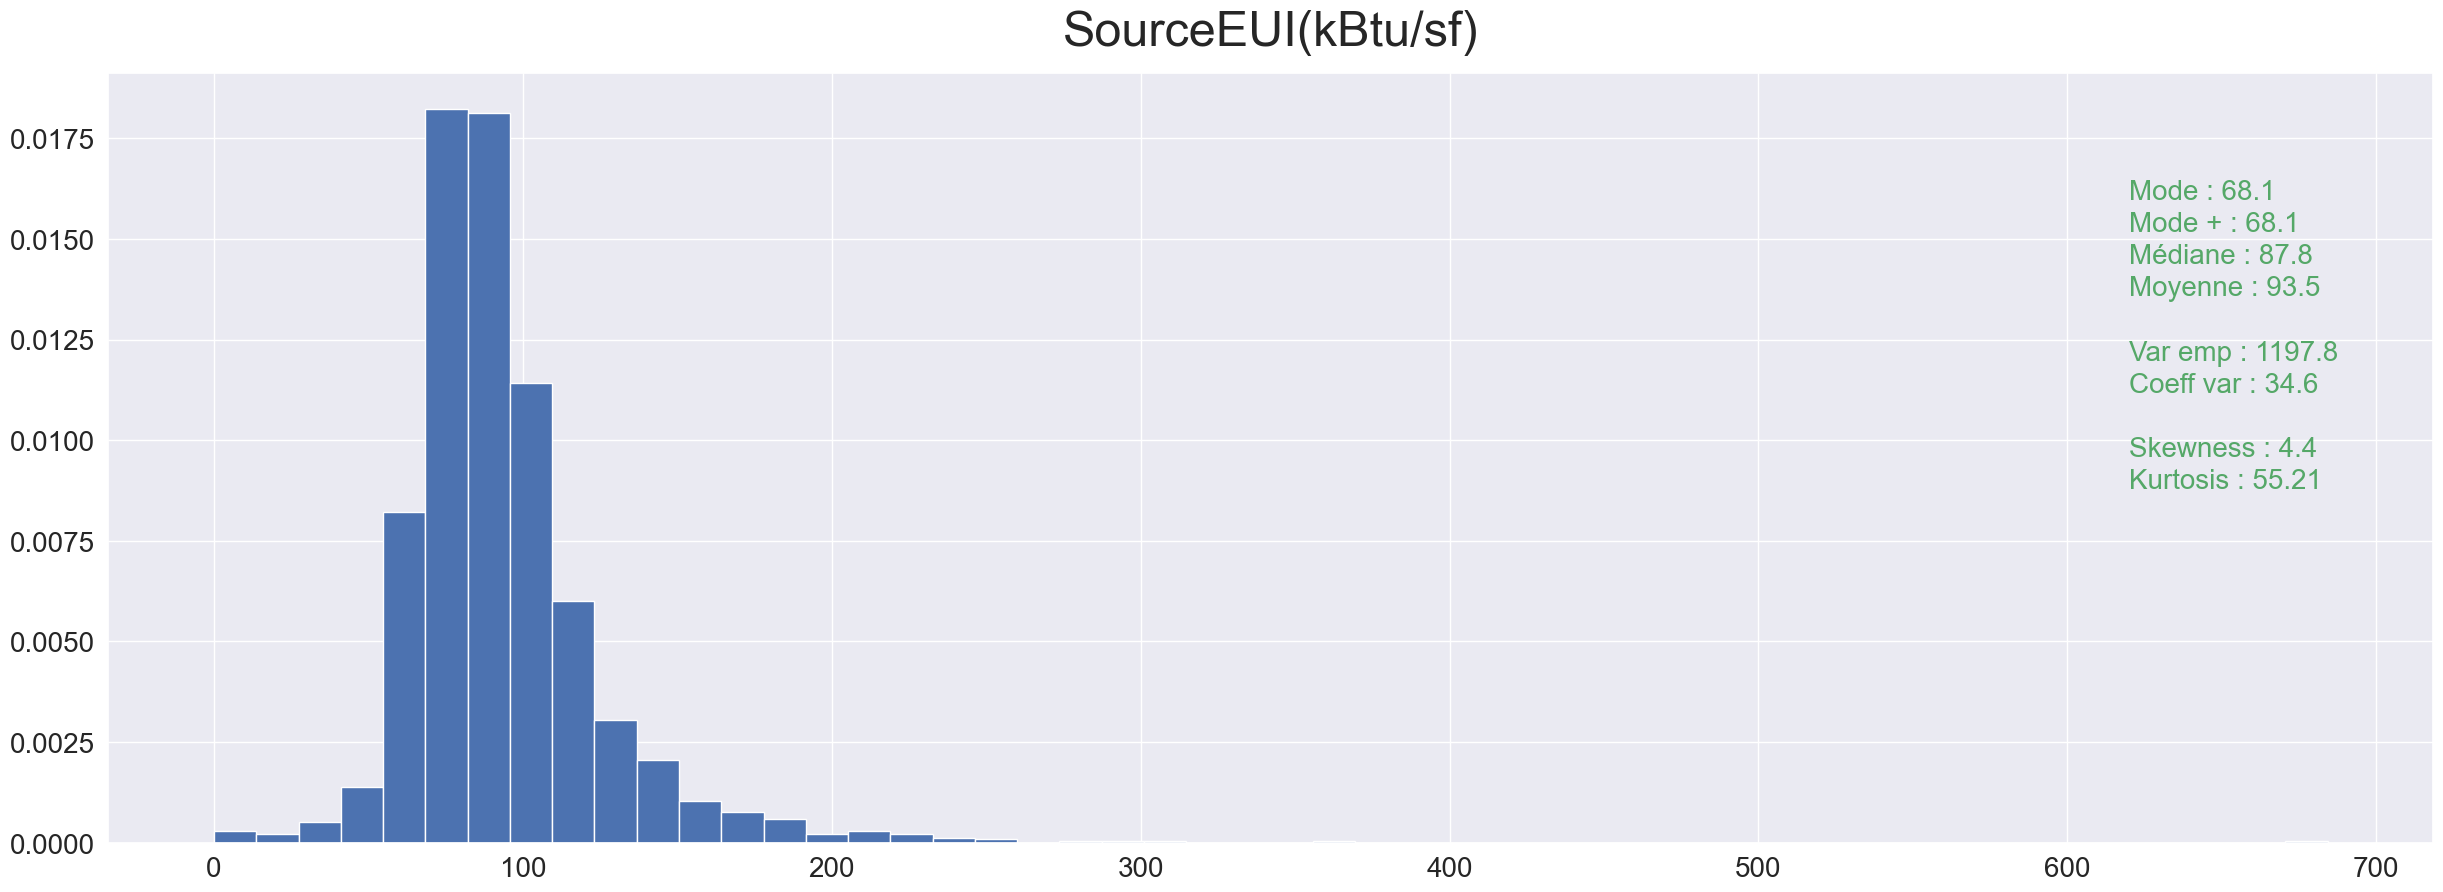

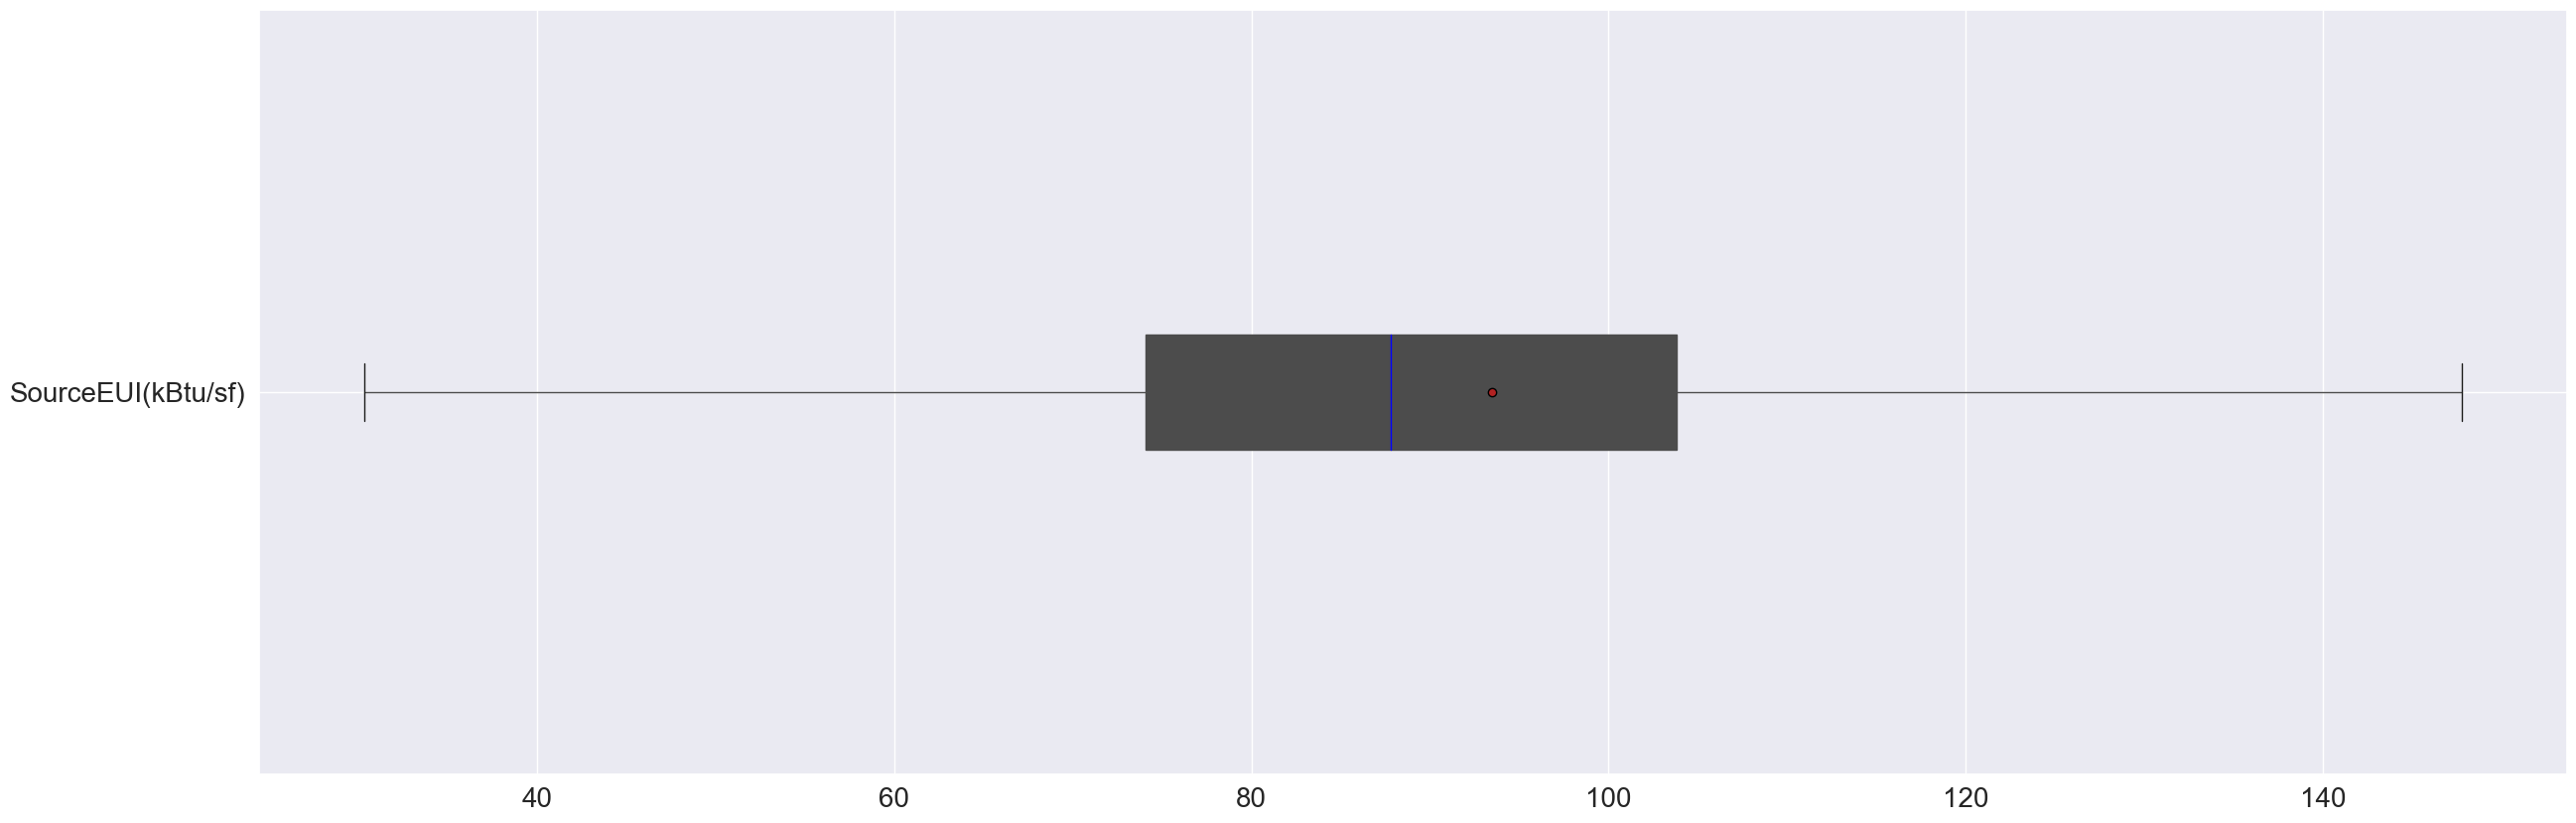

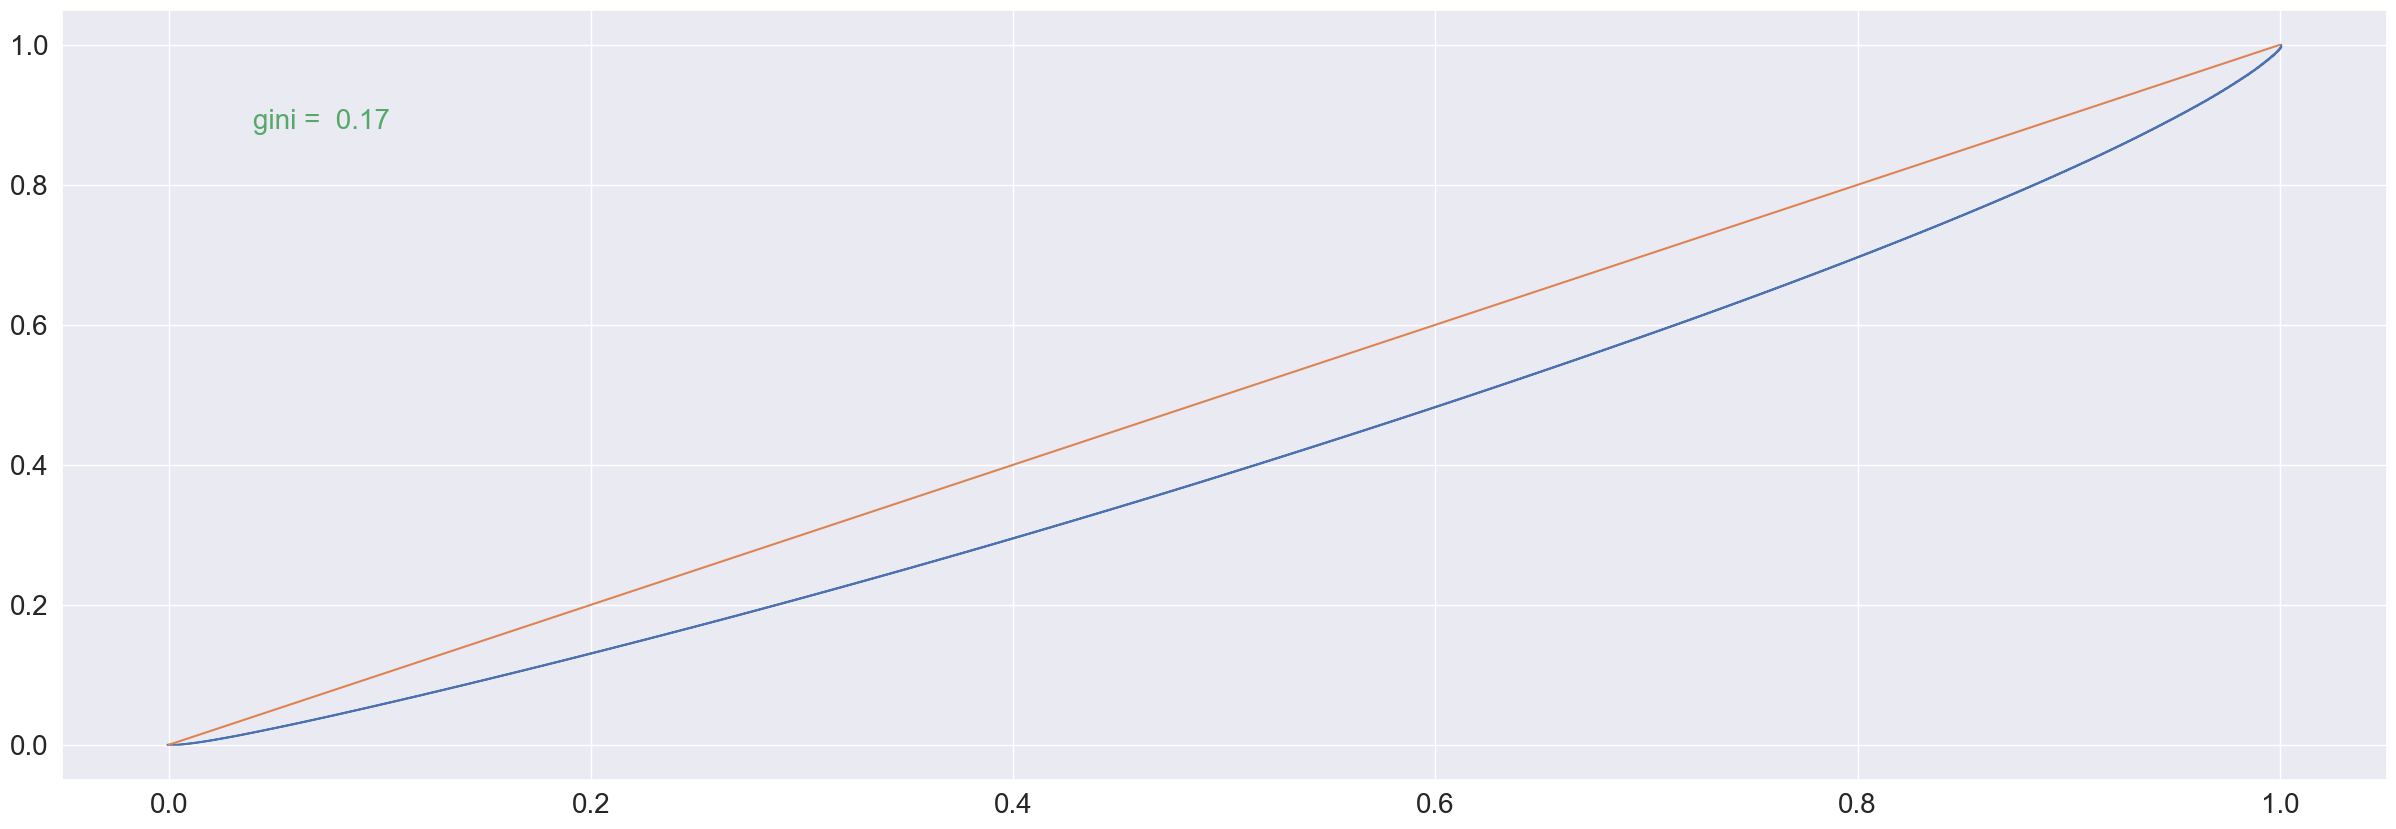

In [12]:
# Pour comparaison, rassemblons aussi les habitations résidentielles dans un même dataframe

subset_R = df.loc[df['BuildingType'].str.contains("Multifamily"), :].copy()

# Nous pouvons maintenant facilement observer les différences entre ces 2 échantillons
# Par exemple, concernant la consommation énergétique (en intensité) :

print("Non-résidentiel")
graphs_analyse_uni(subset_NR, 'SourceEUI(kBtu/sf)', bins=50, r=1)
print("Résidentiel")
graphs_analyse_uni(subset_R, 'SourceEUI(kBtu/sf)', bins=50, r=1)


In [13]:
# On constate en effet que les 2 échantillons diffèrent notablement.
# En particulier, les consommations des bâtiments NR sont en moyenne plus élevées
# ( > 125 kBtu/sf, contre +- 90 pour le résidentiel), 
# avec une variance environ 3x plus importante.
# Les disparités dans la répartition sont aussi presque 3x plus importantes.

# Pour ces raisons, il sera donc probablement plus difficile de faire des prédictions précises 
# sur nos bâtiments (NR).

# Et pour les GES ?

# sns.displot(df, x="GHGEmissionsIntensity", kind="kde", hue='residentiel')
# ?

# remplacer par / ajouter doughnut ?


Non-résidentiel


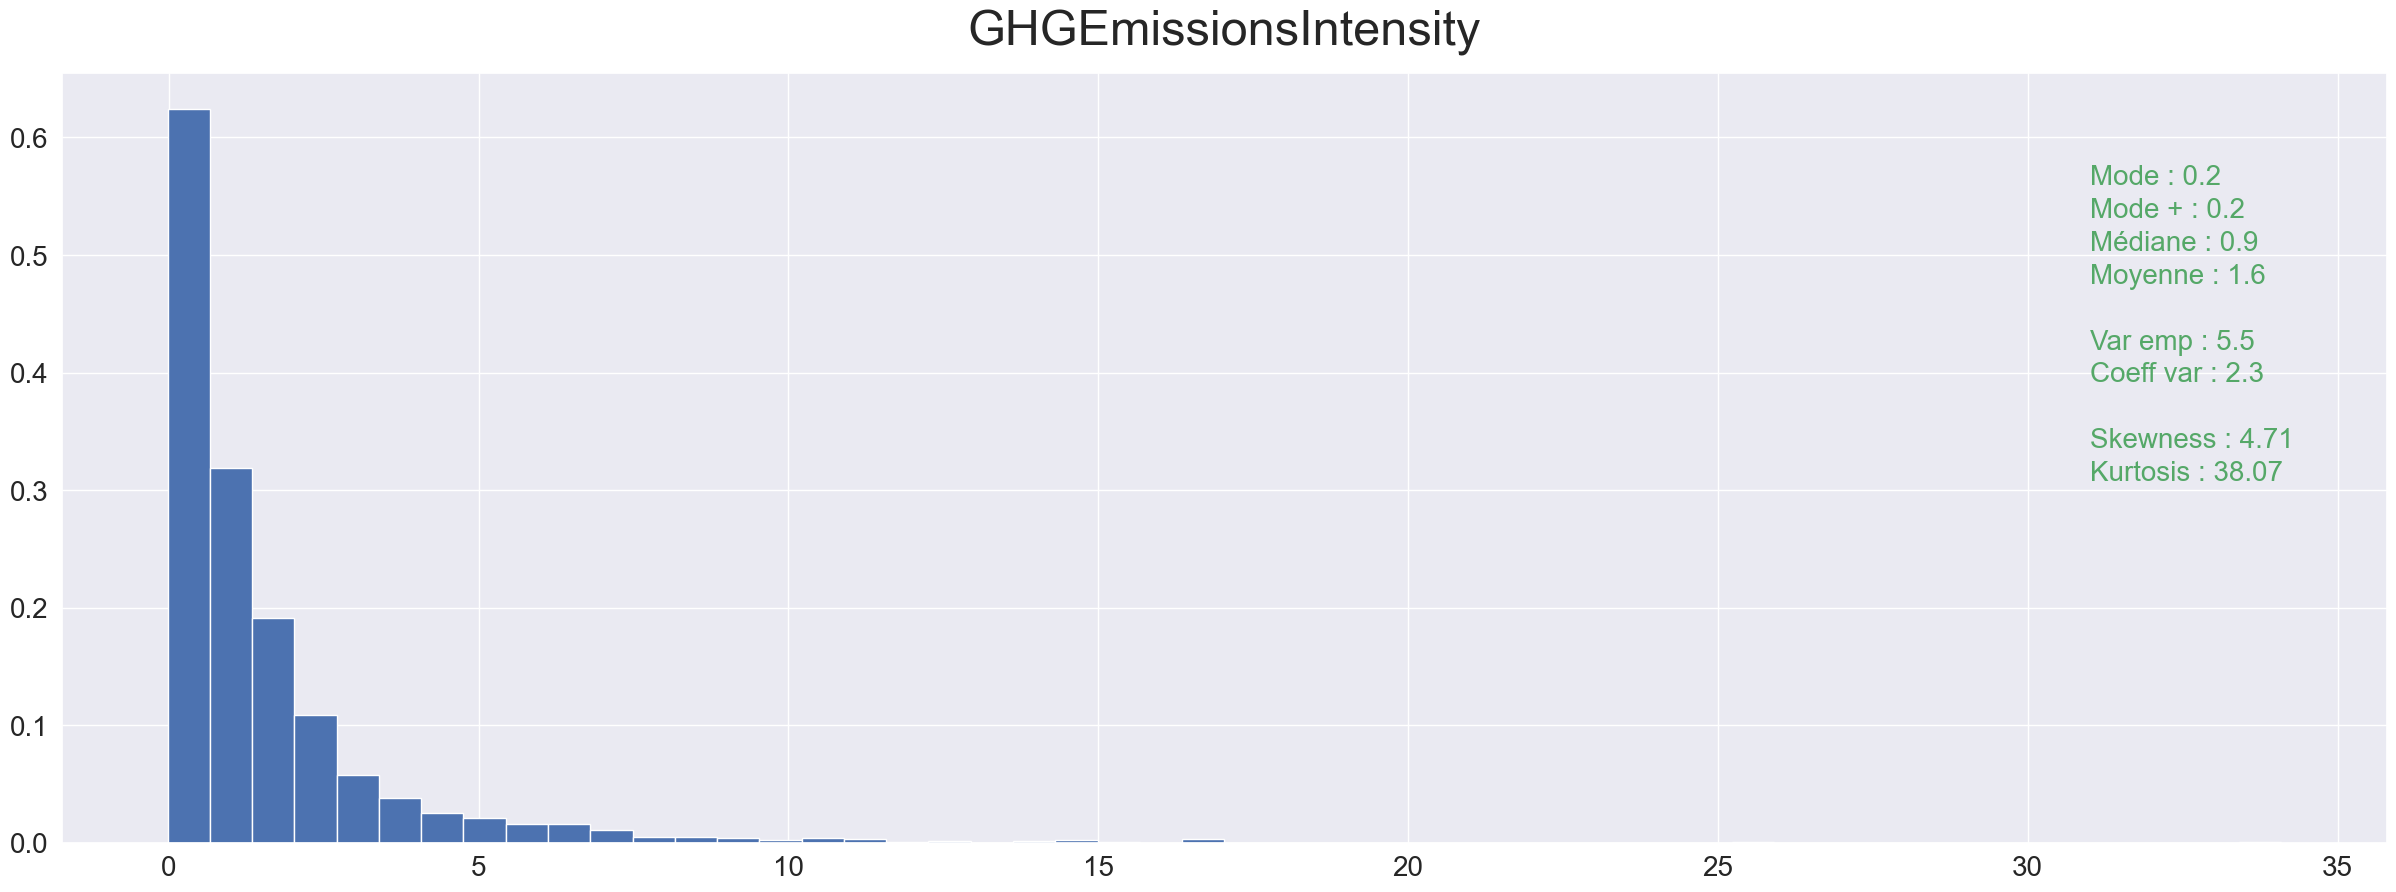

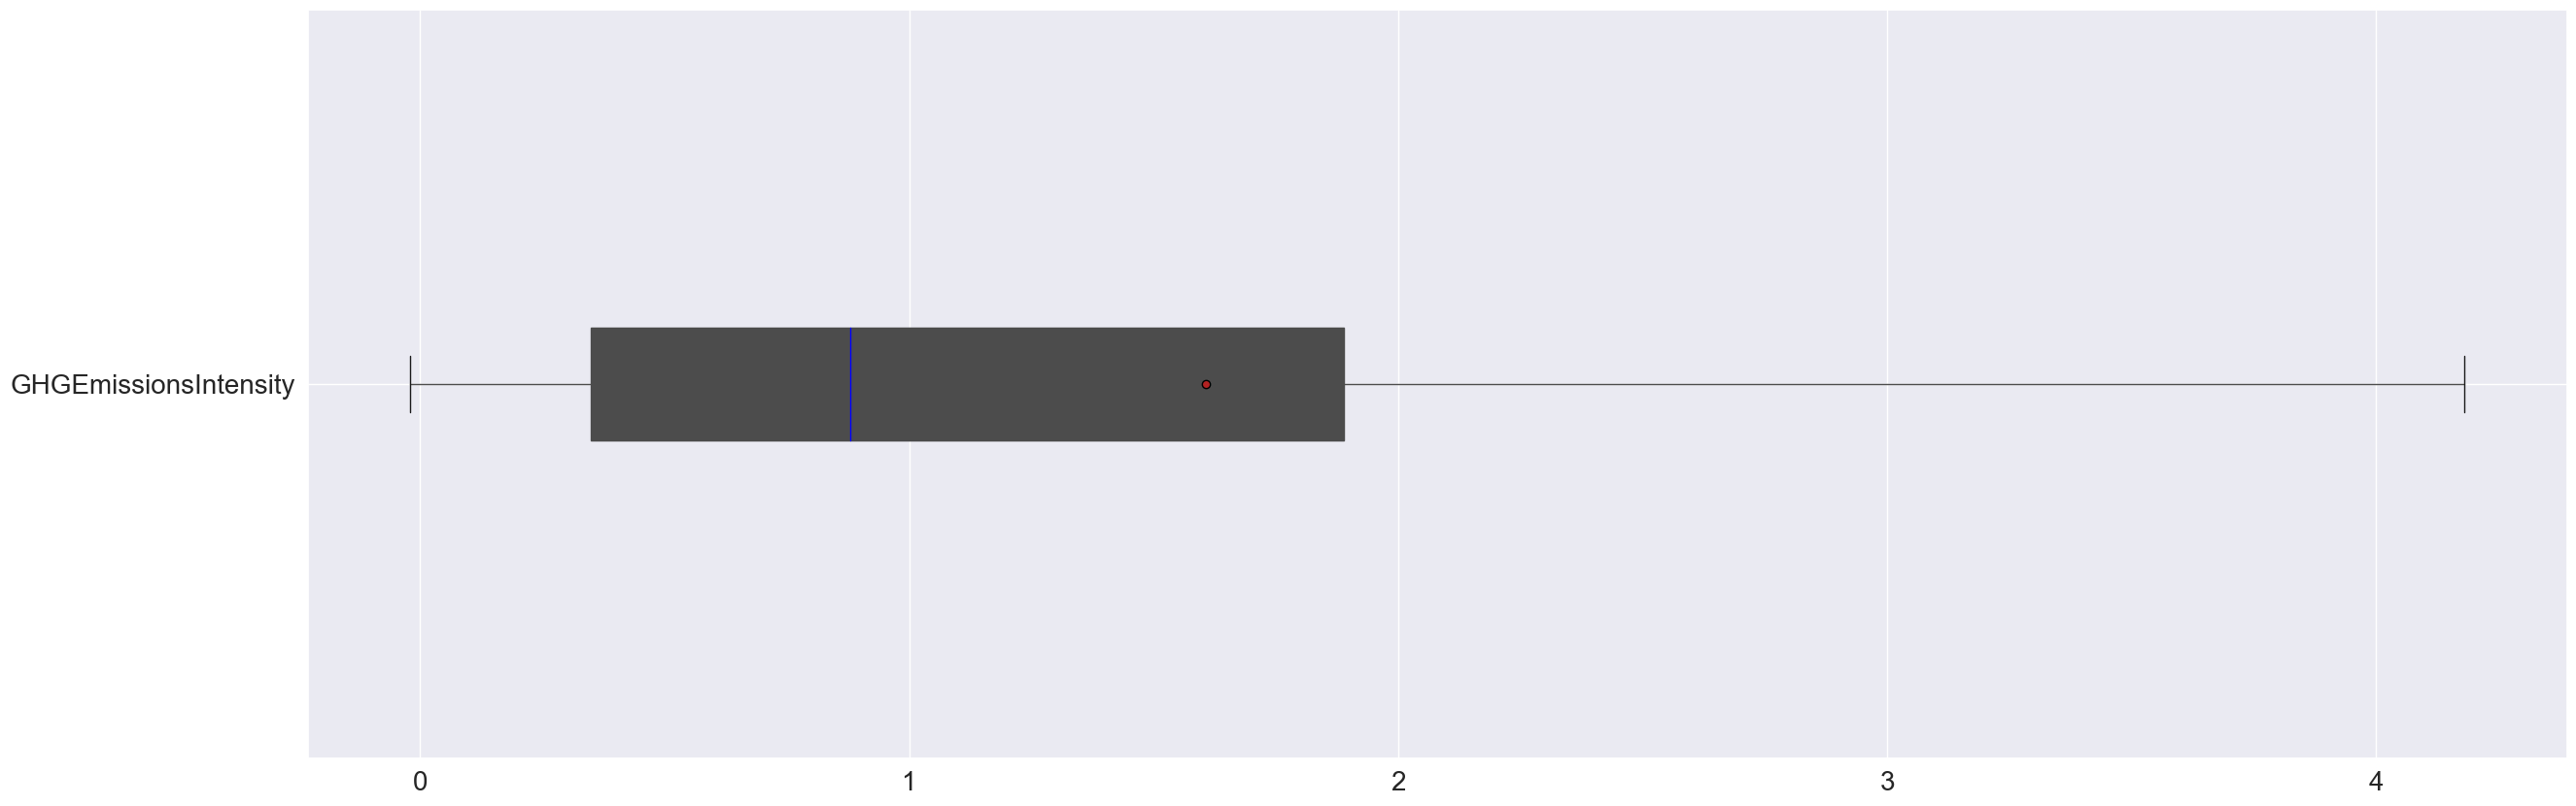

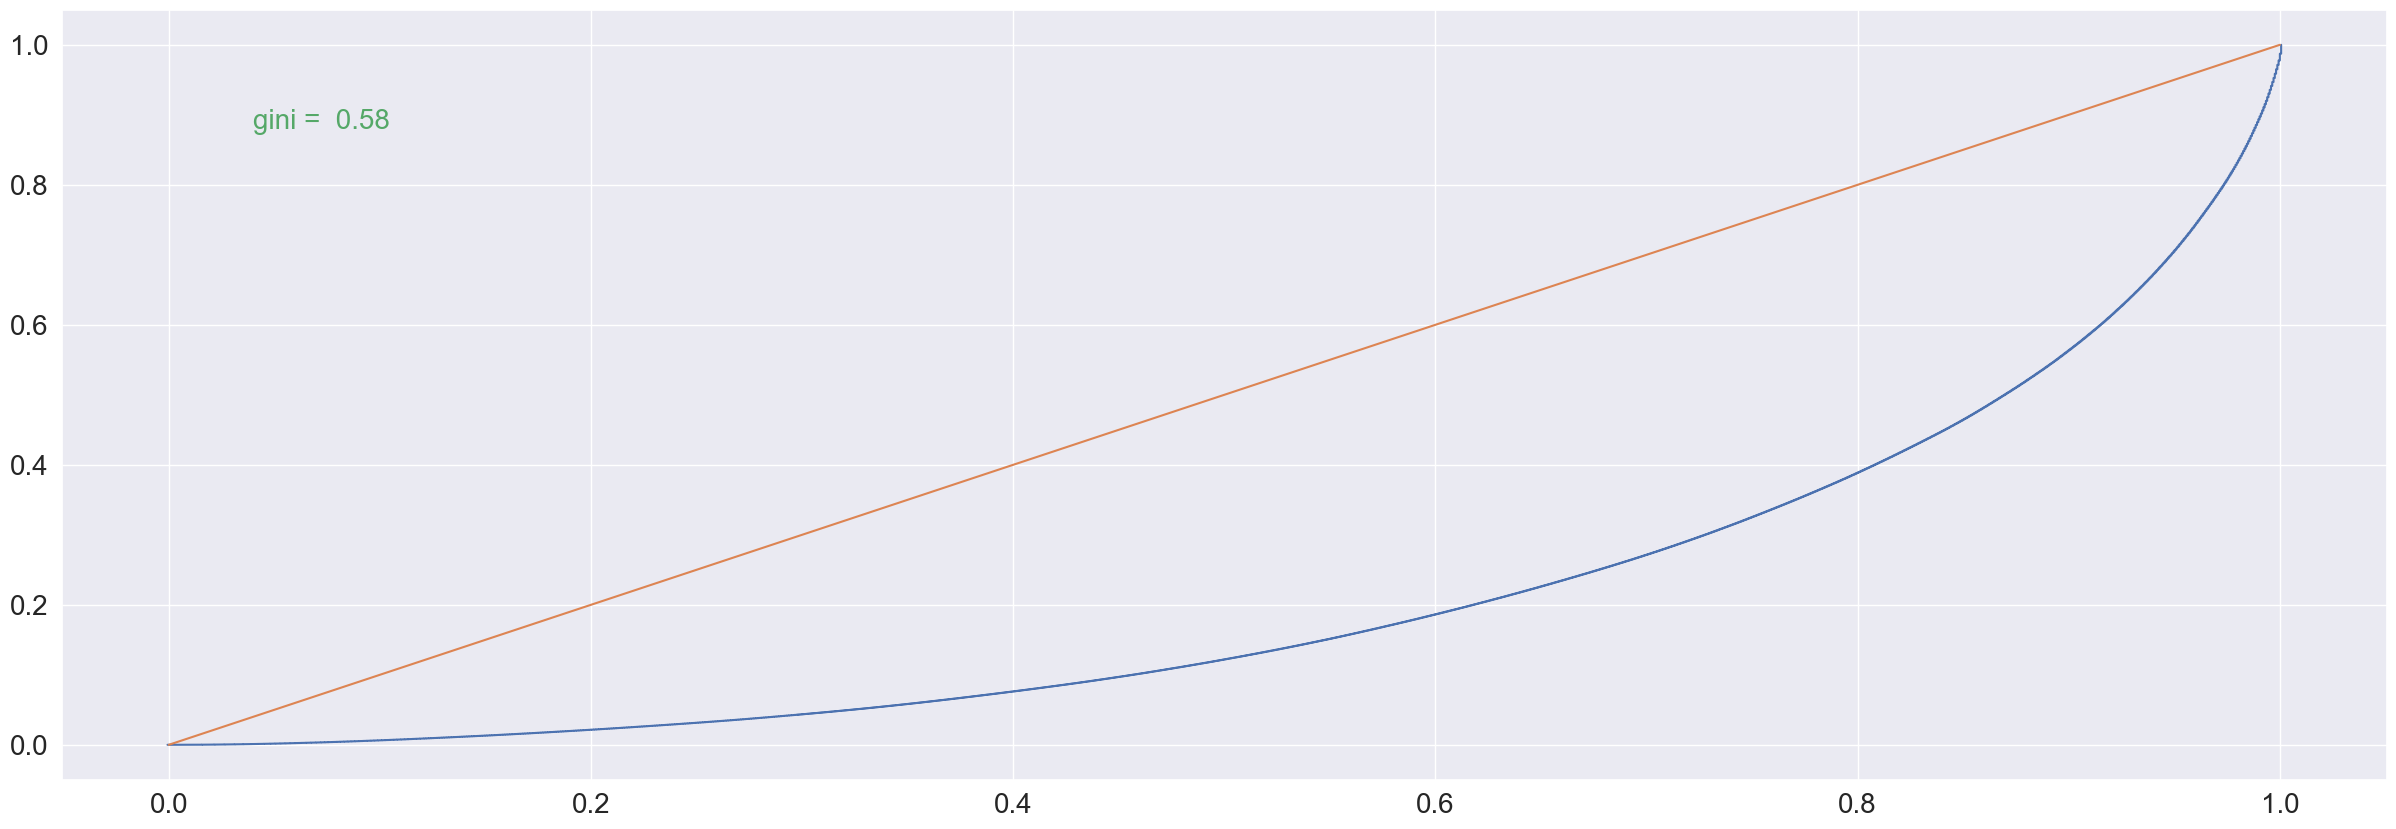

Résidentiel


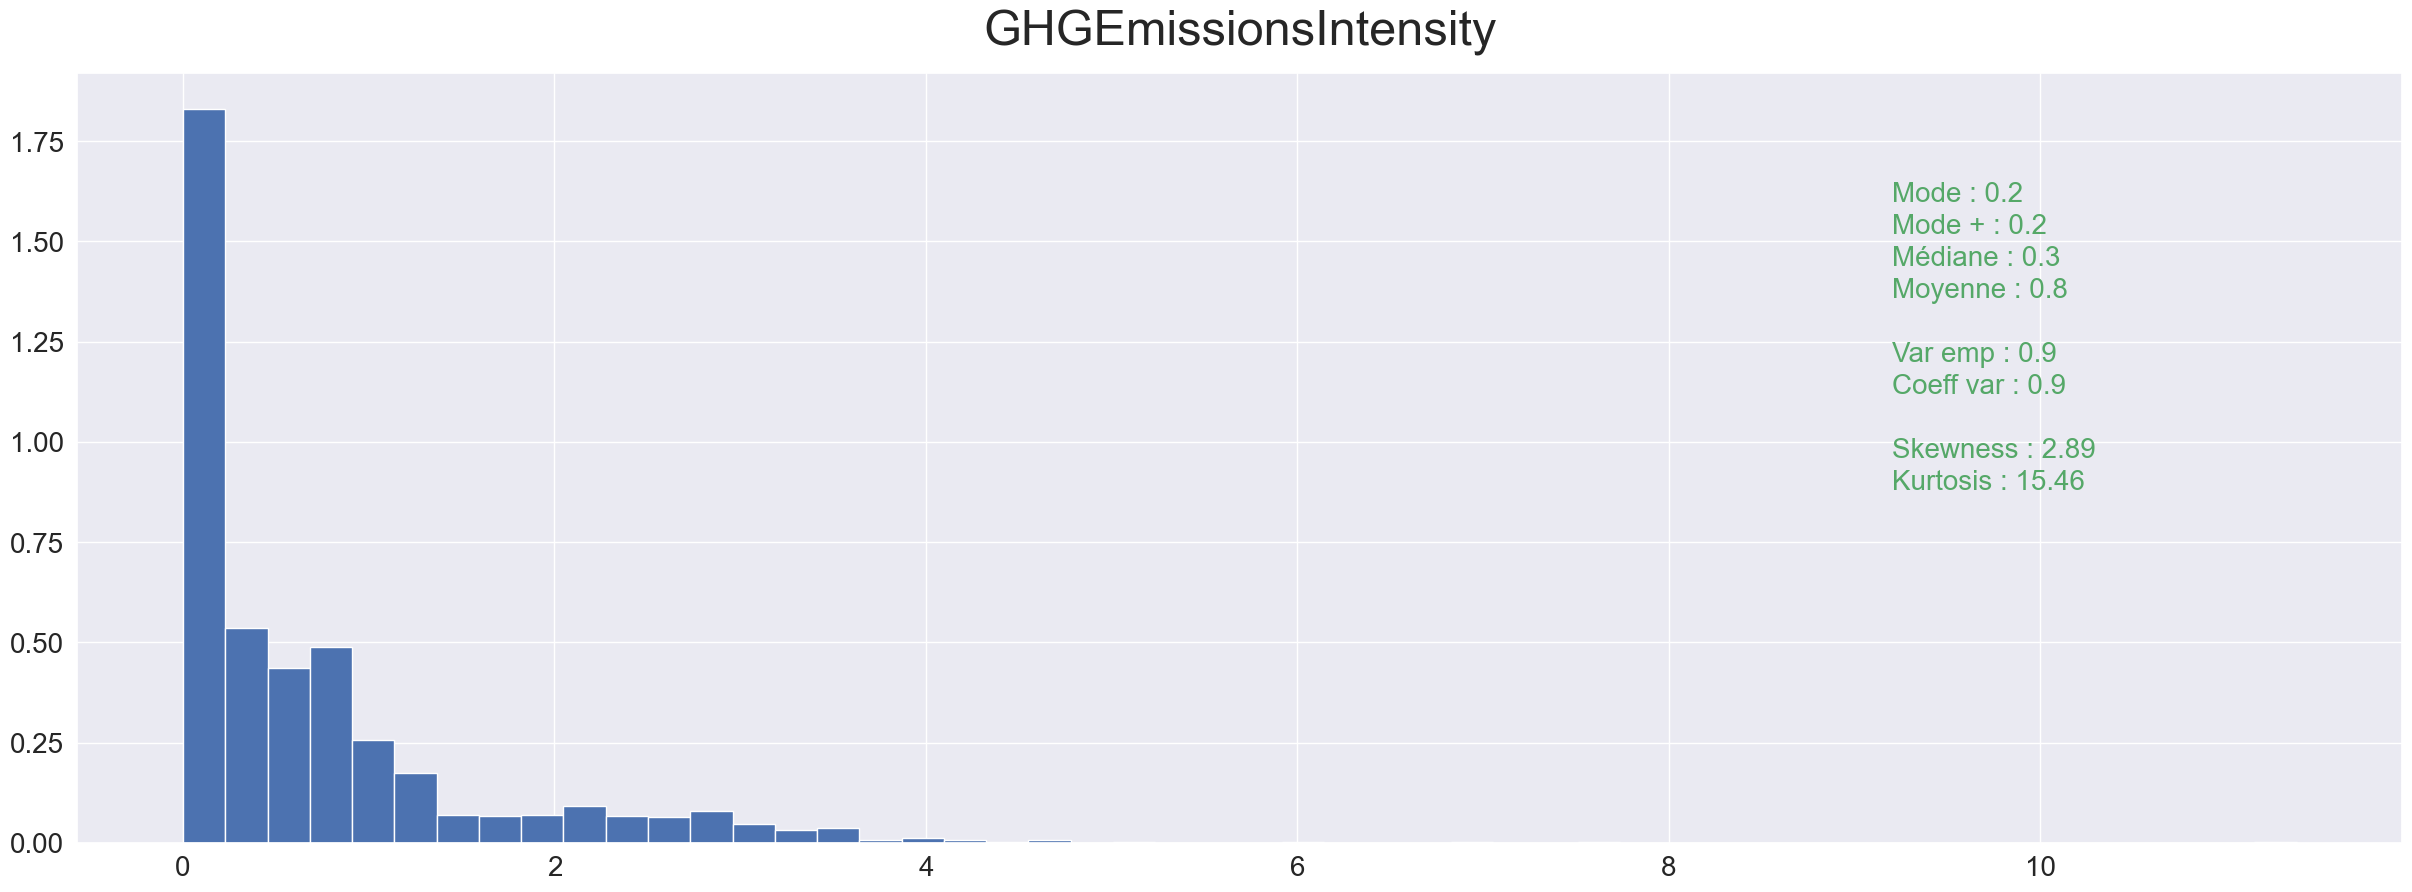

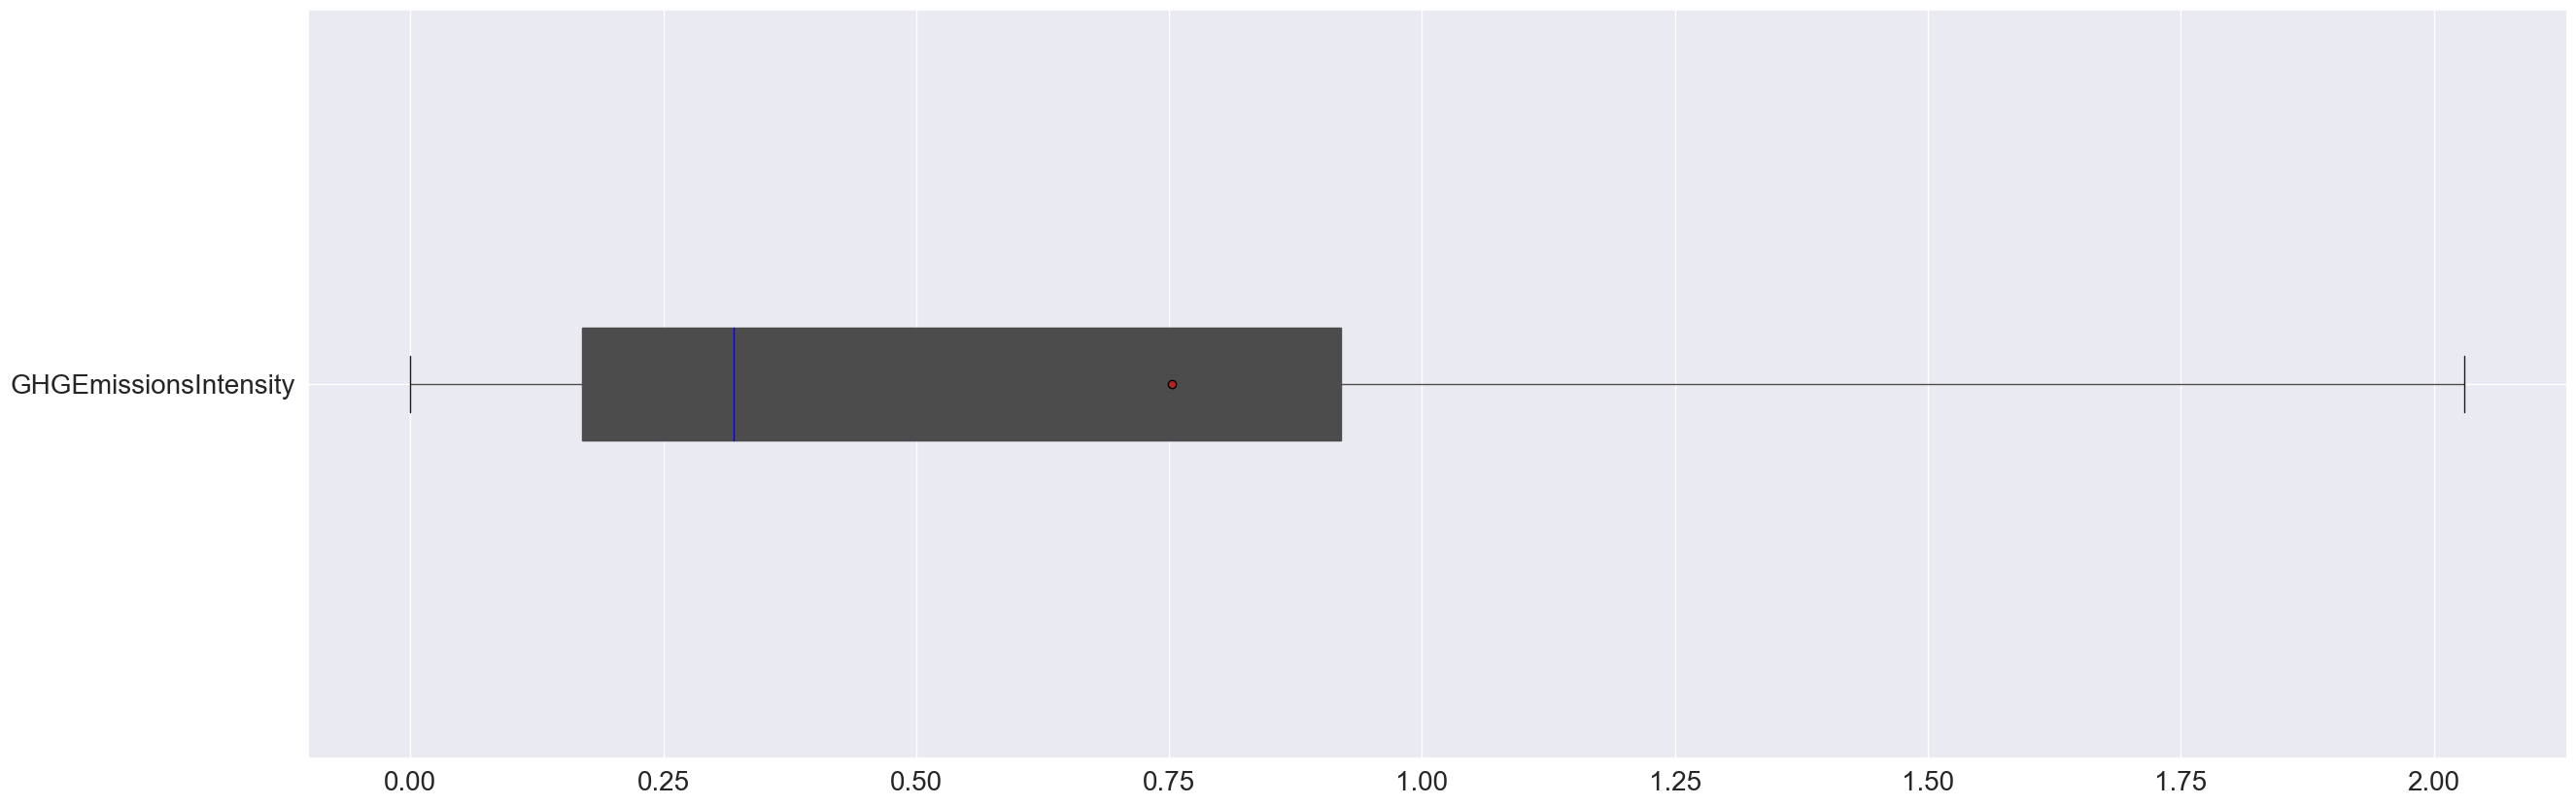

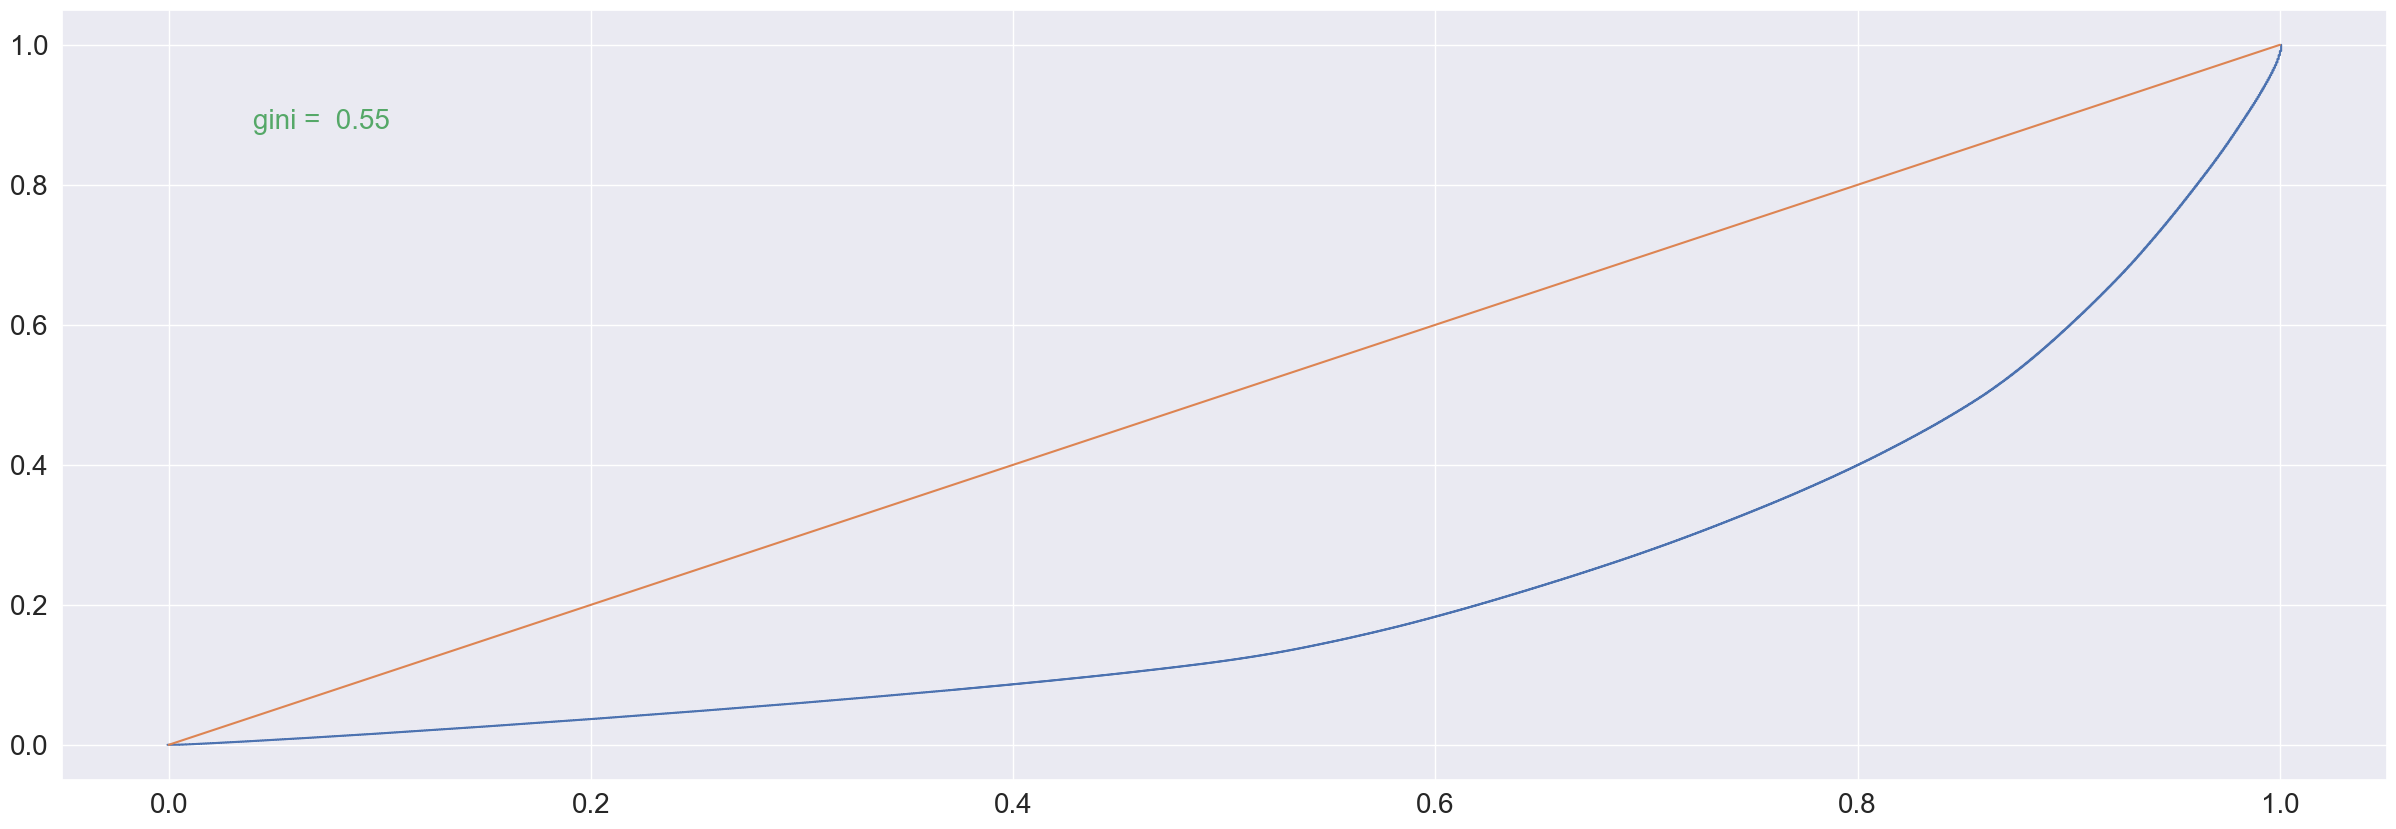

In [14]:
print("Non-résidentiel")
graphs_analyse_uni(subset_NR, 'GHGEmissionsIntensity', bins=50, r=1)
print("Résidentiel")
graphs_analyse_uni(subset_R, 'GHGEmissionsIntensity', bins=50, r=1)


In [15]:
# A peu près autant de disparités que pour l'énergie,
# en moyenne les habitations produisent 2x moins de GES.


### 1.7 Choix des targets

In [16]:
# Energie

# Plusieurs variables concernent la consommation énergétique.
# 2 d'entre elles nous intéressent tout particulièrement, celles qui sont "weather normalized".
# Nous voulons faire des prédictions, donc il est utile d'avoir un point de référence.
# Choisir comme référence la température moyenne permettra donc de comparer/prédire la consommation 
# d'immeubles situés dans des zones différentes, et d'établir des scénarios + ou - optimistes dans le tps.
# Problème : on ne sait pas comment la normalisation est faite, et 
# nous avons observé qu'elle produit des résultats surprenants
# (des consommation nulles deviennent négatives)

# Nous allons donc plutôt travailler sur des données brutes, relevées directement.

# A première vue, la + parlante des deux est "SiteEUIWN(kBtu/sf)"  ?
# (= énergie totale / surface)
# car elle permet de comparer facilement la consommation de deux immeubles ayant des surfaces différentes.
# Cependant il sera peut-être plus facile pour certains modèles linéaires de calculer "SiteEUWN(kBtu/sf)"
# (= énergie totale)
# A tester !

# Pour l'émission de GES (Gaz à effet de serre), curieusement ou n'a pas de variable normalisée par rapport
# aux températures moyennes. C'est curieux car l'émission de GES dépend avant tout de l'énergie consommée.
# La référence sera donc l'année 2016.
# Comme pour l'énergie, j'ai une préférence pour "GHGEmissionsIntensity"
# (total émissions / surface)
# Nous verrons si nos modèles sont capables de la prédire directement, aussi efficacement que 
# "TotalGHGEmissions" (total émissions)


In [17]:
# Targets retenues

# Pour l'énergie : "SiteEnergyUse(kBtu)", "SiteEUI(kBtu/sf)" (pour l'analyse)
# Pour les GES : "TotalGHGEmissions", "GHGEmissionsIntensity" (pour l'analyse)


/home/ubuntu/anaconda3/envs/myenv_p3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ubuntu/anaconda3/envs/myenv_p3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ubuntu/anaconda3/envs/myenv_p3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ubuntu/anaconda3/envs/myenv_p3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed i

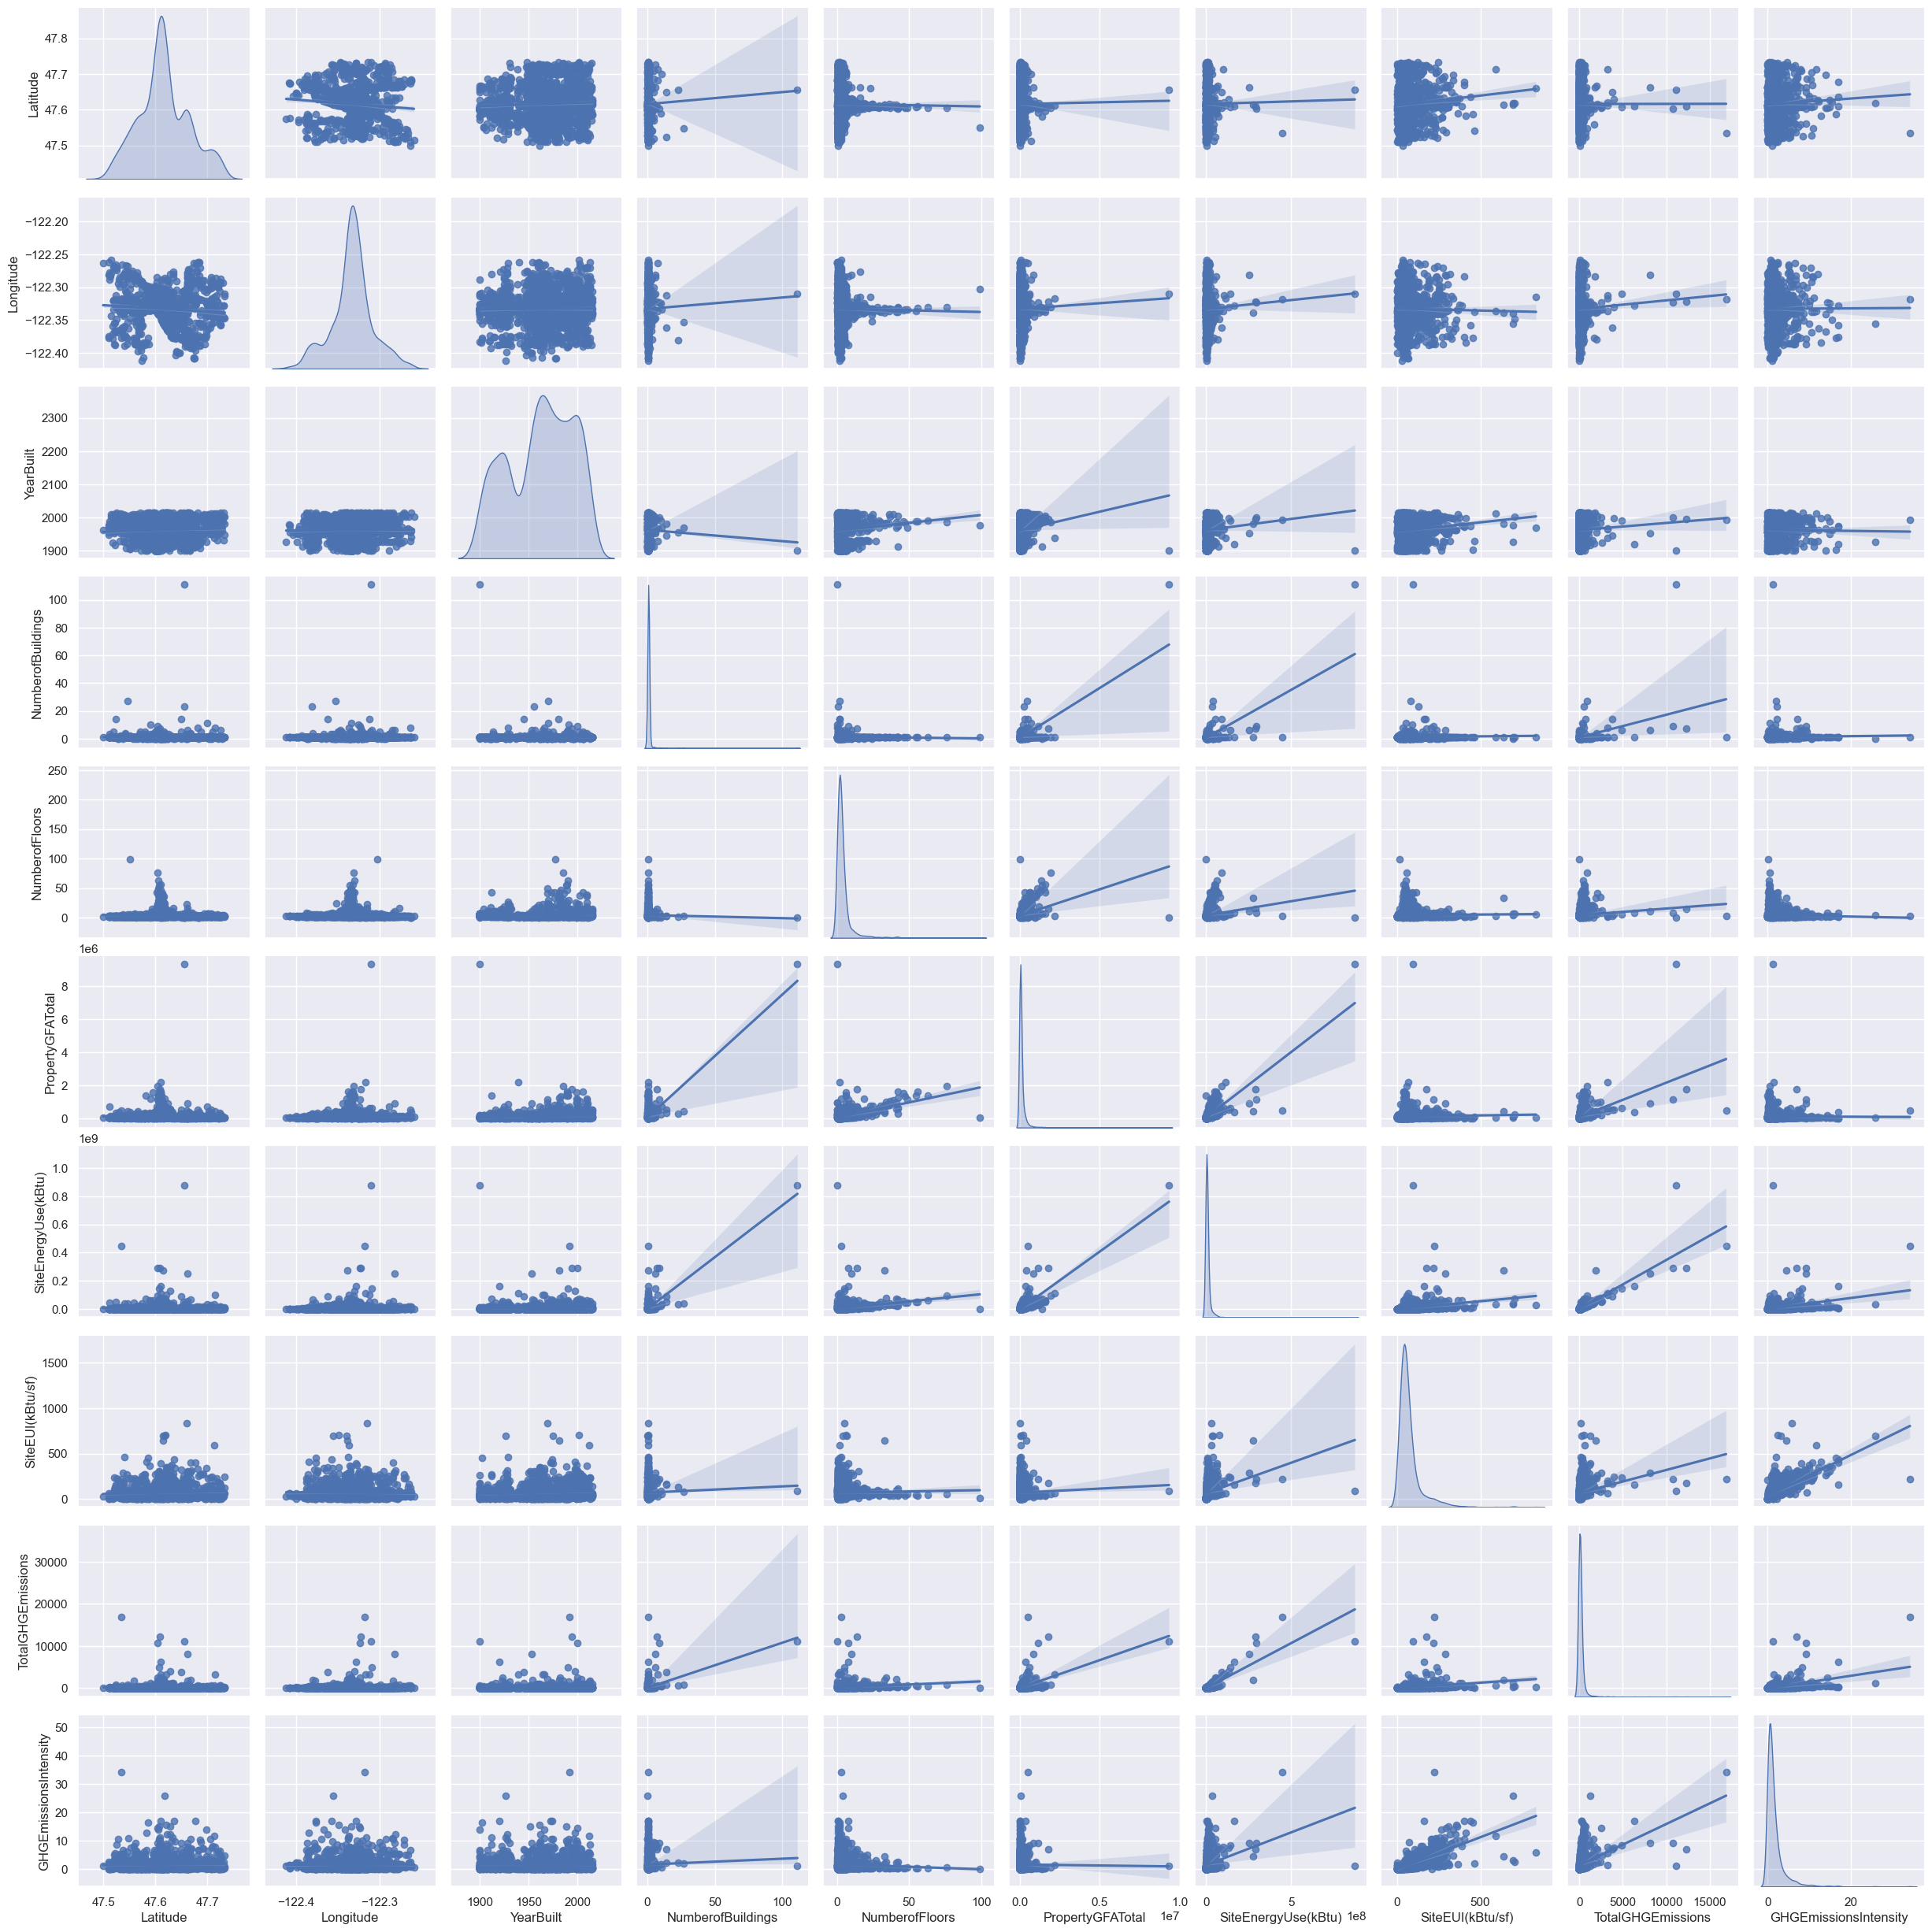

In [18]:
# modif

chosen_features = ['Latitude', 'Longitude', \
                    'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                    'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

_ = sns.pairplot(subset_NR[chosen_features], kind="reg", diag_kind="kde")


In [19]:
# many long tails...
# il y aura des passages au log / Box-Cox ?
# Pour les targets, et certaines variables

# Note that Box-Cox can only be applied to strictly positive data.
# Yeo-Johnson ?

# The energy used is increasing when surface, nb buildings, etc... is increasing. 
# Note that the dependence represented here is a marginal dependence, i.e., 
# it describes the behavior of a specific variable without keeping the others fixed.

# Also, certaines variables are strongly linearly correlated.


## 2. Pré-sélection des features

### 2.1 Observons les variables structurelles

In [20]:
# Observons davantage nos variables 

# On s'intéresse aux variables structurelles, donc dans un premier temps :
# 'BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 
# 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 
# 'proportion_electricity', 'proportion_gaz', 'proportion_steam'

# Certaines variables seront modifiées (partie 4, feature engineering)

shape_head(subset_NR)

subset_NR.describe()



(1668, 42)


OSEBuildingID    BuildingType PrimaryPropertyType  \
0              1  NonResidential               Hotel   
1              2  NonResidential               Hotel   
2              3  NonResidential               Hotel   
3              5  NonResidential               Hotel   
4              8  NonResidential               Hotel   

                  PropertyName          Address  ZipCode  \
0         Mayflower park hotel    405 Olive way  98101.0   
1              Paramount Hotel  724 Pine street  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  98101.0   
3                    HOTEL MAX   620 STEWART ST  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2           97.699997          241.899994            244.100006   
3          113.300003          216.199997            224.000000   
4          118.69

OSEBuildingID       ZipCode  CouncilDistrictCode     Latitude  \
count    1668.000000   1652.000000          1668.000000  1668.000000   
mean    16336.346523  98116.819613             4.356715    47.616054   
std     13835.292512     18.430353             2.191048     0.048168   
min         1.000000  98006.000000             1.000000    47.499170   
25%       582.750000  98105.000000             2.000000    47.585458   
50%     21143.500000  98109.000000             4.000000    47.612340   
75%     24602.250000  98125.000000             7.000000    47.649675   
max     50226.000000  98199.000000             7.000000    47.733870   

         Longitude    YearBuilt  NumberofBuildings  NumberofFloors  \
count  1668.000000  1668.000000        1666.000000     1668.000000   
mean   -122.332908  1961.913669           1.168667        4.121103   
std       0.024580    32.741755           2.931409        6.563407   
min    -122.411820  1900.000000           0.000000        0.000000   
25%    -122.343280  1930.000000           1.000000        1.000000   
50%    -122.332935  1965.000000           1.000000        2.000000   
75%    -122.321675  1989.000000           1.000000        4.000000   
max    -122.258640  2015.000000         111.000000       99.000000   

       PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count      1.668000e+03         1668.000000            1.668000e+03   
mean       1.188427e+05        12897.979017            1.059447e+05   
std        2.973622e+05        42274.511185            2.842116e+05   
min        1.128500e+04            0.000000            3.636000e+03   
25%        2.947775e+04            0.000000            2.847525e+04   
50%        4.928950e+04            0.000000            4.739150e+04   
75%        1.053250e+05            0.000000            9.475975e+04   
max        9.320156e+06       512608.000000            9.320156e+06   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count               1.662000e+03                       855.000000   
mean                9.876469e+04                     36804.160581   
std                 2.767111e+05                     69845.261024   
min                 5.656000e+03                         0.000000   
25%                 2.552750e+04                      5350.000000   
50%                 4.377050e+04                     12000.000000   
75%                 9.198375e+04                     31881.000000   
max                 9.320156e+06                    686750.000000   

       ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
count                       353.00000      1094.000000       1665.000000   
mean                      14923.13994        65.449726         72.158799   
std                       36790.55656        28.492928         74.048129   
min                           0.00000         1.000000          0.000000   
25%                        2663.00000        48.000000         33.700001   
50%                        5931.00000        73.000000         51.900002   
75%                       12941.00000        89.000000         81.699997   
max                      459748.00000       100.000000        834.400024   

       SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
count         1665.000000         1666.000000           1666.000000   
mean            74.568529          175.829892            178.090876   
std             75.028403          185.932121            185.918749   
min              0.000000            0.000000             -2.100000   
25%             35.400002           76.450001             79.325003   
50%             53.900002          130.949997            134.150002   
75%             85.199997          203.950001            205.700001   
max            834.400024         2620.000000           2620.000000   

       SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
count         1.666000e+03           1.665000e+03    1.666000e+03   
me

In [21]:
# NumberofBuildings 0... des bâtiments sans bâtiments ??
# Plus ancien(s), tjs 1900. cf cell suivante
# NumberofFloors ?


### 2.2 Building type

In [22]:
# En patie 1 nous avons ciblé les bâtiments non résidentiel,
# il nous reste donc 5 types de bâtiments :

print(subset_NR['BuildingType'].unique())


['NonResidential' 'Nonresidential COS' 'SPS-District K-12' 'Campus']


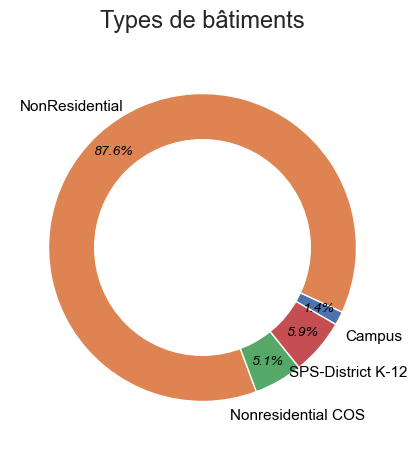

In [23]:
plt.rcParams["figure.figsize"] = (15,5)

doughnut(subset_NR, 'BuildingType', "Types de bâtiments")


### 2.3 PrimaryPropertyType

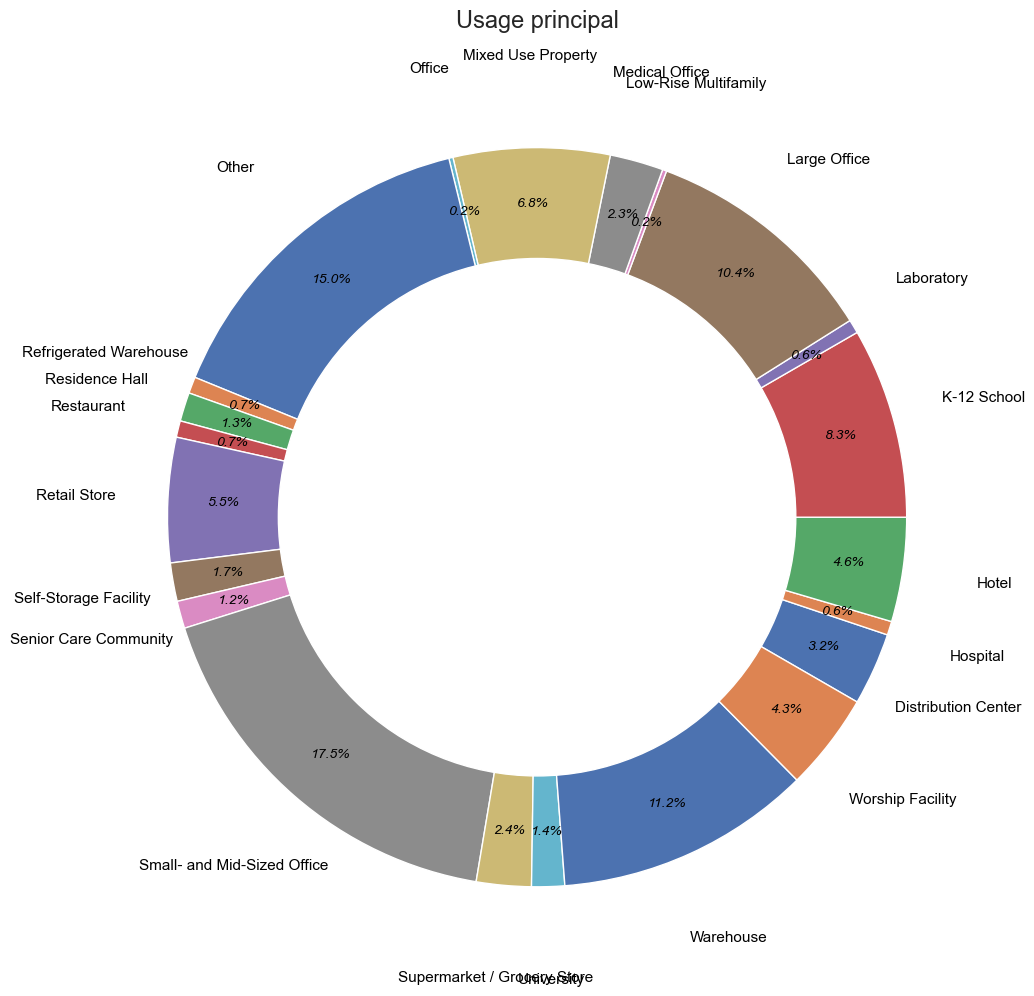

In [24]:
plt.rcParams["figure.figsize"] = (25,12)

doughnut(subset_NR, 'PrimaryPropertyType', "Usage principal")

# changer palette


In [25]:
grouped_NR_ppt = subset_NR.groupby('PrimaryPropertyType').size().to_frame("count_per_type").reset_index()
display(grouped_NR_ppt)

# Pas de singletons ! Youhou !


PrimaryPropertyType  count_per_type
0           Distribution Center              53
1                      Hospital              10
2                         Hotel              76
3                   K-12 School             139
4                    Laboratory              10
5                  Large Office             173
6          Low-Rise Multifamily               3
7                Medical Office              39
8            Mixed Use Property             114
9                        Office               3
10                        Other             250
11       Refrigerated Warehouse              12
12               Residence Hall              21
13                   Restaurant              12
14                 Retail Store              91
15        Self-Storage Facility              28
16        Senior Care Community              20
17  Small- and Mid-Sized Office             292
18  Supermarket / Grocery Store              40
19                   University              24
20                    Warehouse             187
21             Worship Facility              71

### 2.4 Neighborhood

In [26]:
# "peut-on déduire des choses intéressantes d’une simple adresse ?"

# Pour notre feature géographique, nous avons plusieurs choix possibles :

# Plusieurs features catégoriques :
# ZipCode, CouncilDistrictCode, Neighborhood

grouped_NR_neighbor = subset_NR.groupby('Neighborhood').size().to_frame("count_per_type").reset_index()
display(grouped_NR_neighbor)

# Encore une classe unique. 
subset_NR.loc[subset_NR['Neighborhood'] == 'DELRIDGE NEIGHBORHOODS', 'Neighborhood'] = 'Delridge'
# Delridge, comme la régression del ridge ? Café.

grouped_NR_neighbor = subset_NR.groupby('Neighborhood').size().to_frame("count_per_type").reset_index()
display(grouped_NR_neighbor)

# 2 features numériques : latitude et longitude

# Une feature texte, plus difficile à exploiter directement : address

# Pourquoi pas simplement latitude et longitude ??
# Cela evite l'explosion du nombre de dimensions apres o h encoding

# Neighborhood 19 unique values
# zipcode 55
# 19 better ici ? Car on n'a pas bcp d'individus
# de plus, zipcode aurait qq valeurs manquantes à traiter, neighborhood non


Neighborhood  count_per_type
0                  BALLARD              64
1                  Ballard               6
2                  CENTRAL              51
3                  Central               5
4                 DELRIDGE              42
5   DELRIDGE NEIGHBORHOODS               1
6                 DOWNTOWN             361
7                 Delridge               4
8                     EAST             121
9         GREATER DUWAMISH             346
10              LAKE UNION             148
11   MAGNOLIA / QUEEN ANNE             151
12                   NORTH              58
13               NORTHEAST             128
14               NORTHWEST              81
15                   North               9
16               Northwest               5
17               SOUTHEAST              46
18               SOUTHWEST              41

Neighborhood  count_per_type
0                 BALLARD              64
1                 Ballard               6
2                 CENTRAL              51
3                 Central               5
4                DELRIDGE              42
5                DOWNTOWN             361
6                Delridge               5
7                    EAST             121
8        GREATER DUWAMISH             346
9              LAKE UNION             148
10  MAGNOLIA / QUEEN ANNE             151
11                  NORTH              58
12              NORTHEAST             128
13              NORTHWEST              81
14                  North               9
15              Northwest               5
16              SOUTHEAST              46
17              SOUTHWEST              41

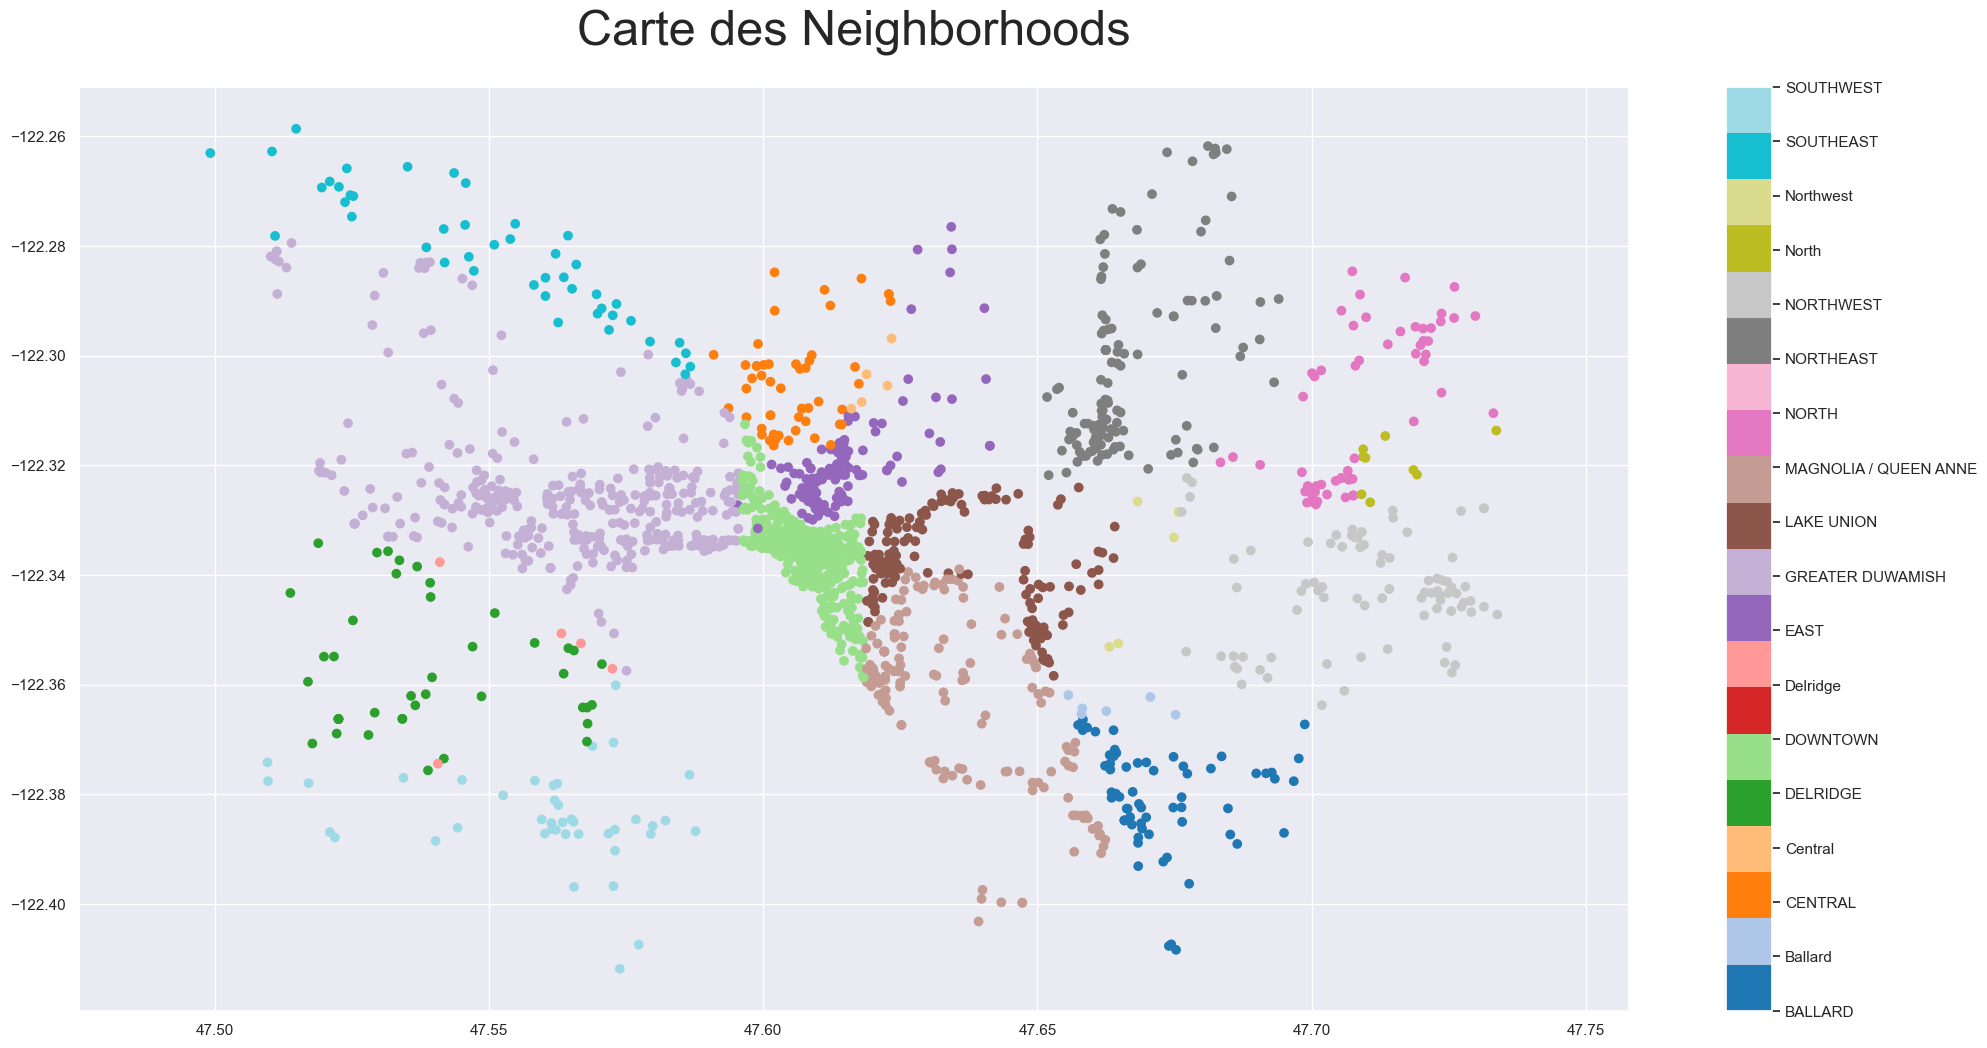

In [66]:
# Assuming 'Neighborhood' is a categorical variable
neighborhood_colors = subset_NR['Neighborhood'].astype('category')
neighborhood_labels = neighborhood_colors.cat.categories
neighborhood_codes = neighborhood_colors.cat.codes

# Set a custom colormap (e.g., 'viridis')
custom_cmap = 'tab20'

plt.scatter(subset_NR['Latitude'], subset_NR['Longitude'], c=neighborhood_codes, cmap=custom_cmap)

# Set equal aspect ratio to maintain real proportions
plt.axis('equal')

# Create a custom colorbar with labels
cbar = plt.colorbar(ticks=range(len(neighborhood_labels)))
cbar.set_ticklabels(neighborhood_labels)

plt.title('Carte des Neighborhoods', fontsize=35)
plt.show()


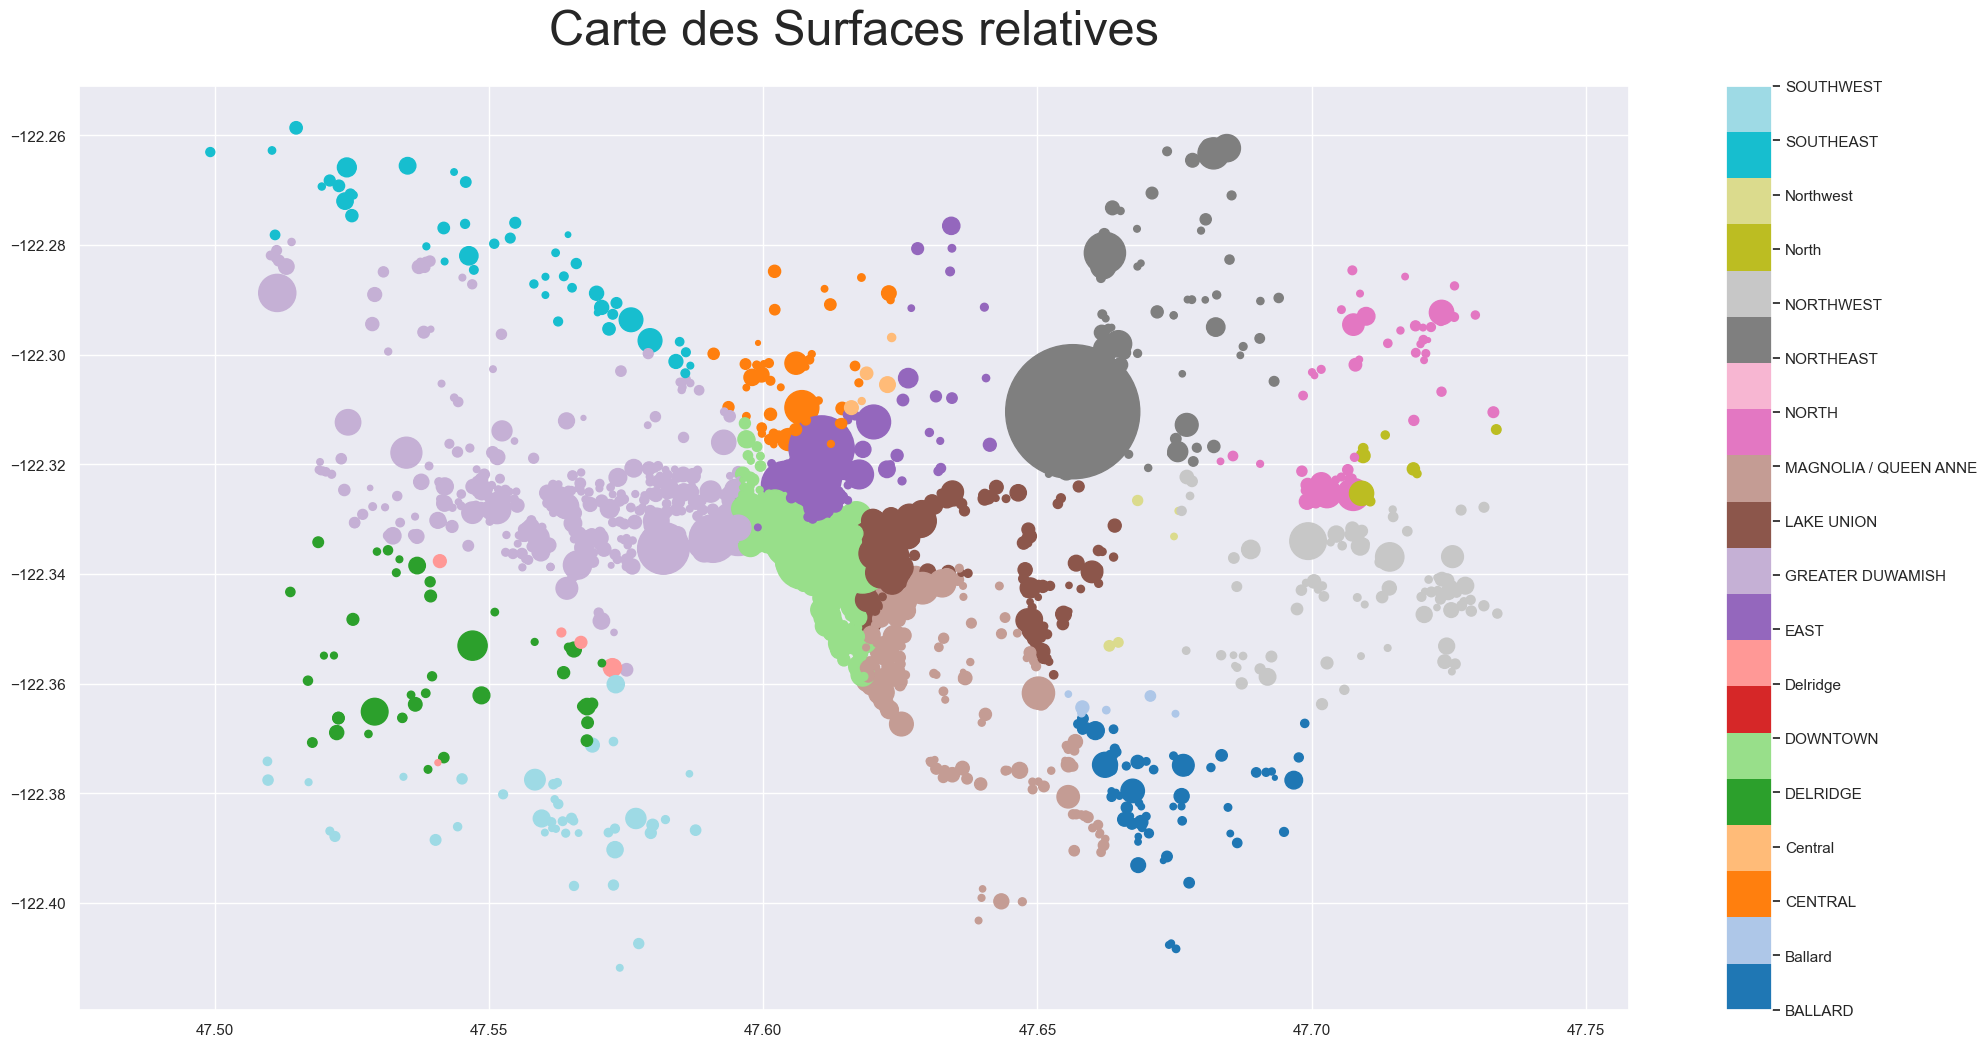

In [64]:
# Assuming 'Neighborhood' is a categorical variable
neighborhood_colors = subset_NR['Neighborhood'].astype('category')
neighborhood_labels = neighborhood_colors.cat.categories
neighborhood_codes = neighborhood_colors.cat.codes

# Set a custom colormap (e.g., 'viridis')
custom_cmap = 'tab20'

# Size of the points based on the 'surface' feature (adjust the scaling factor as needed)
point_size = subset_NR['PropertyGFATotal'] * 0.001

plt.scatter(subset_NR['Latitude'], subset_NR['Longitude'], c=neighborhood_codes, cmap=custom_cmap, s=point_size)

# Set equal aspect ratio to maintain real proportions
plt.axis('equal')

# Create a custom colorbar with labels
cbar = plt.colorbar(ticks=range(len(neighborhood_labels)))
cbar.set_ticklabels(neighborhood_labels)

plt.title('Carte des Surfaces relatives', fontsize=35)
plt.show()


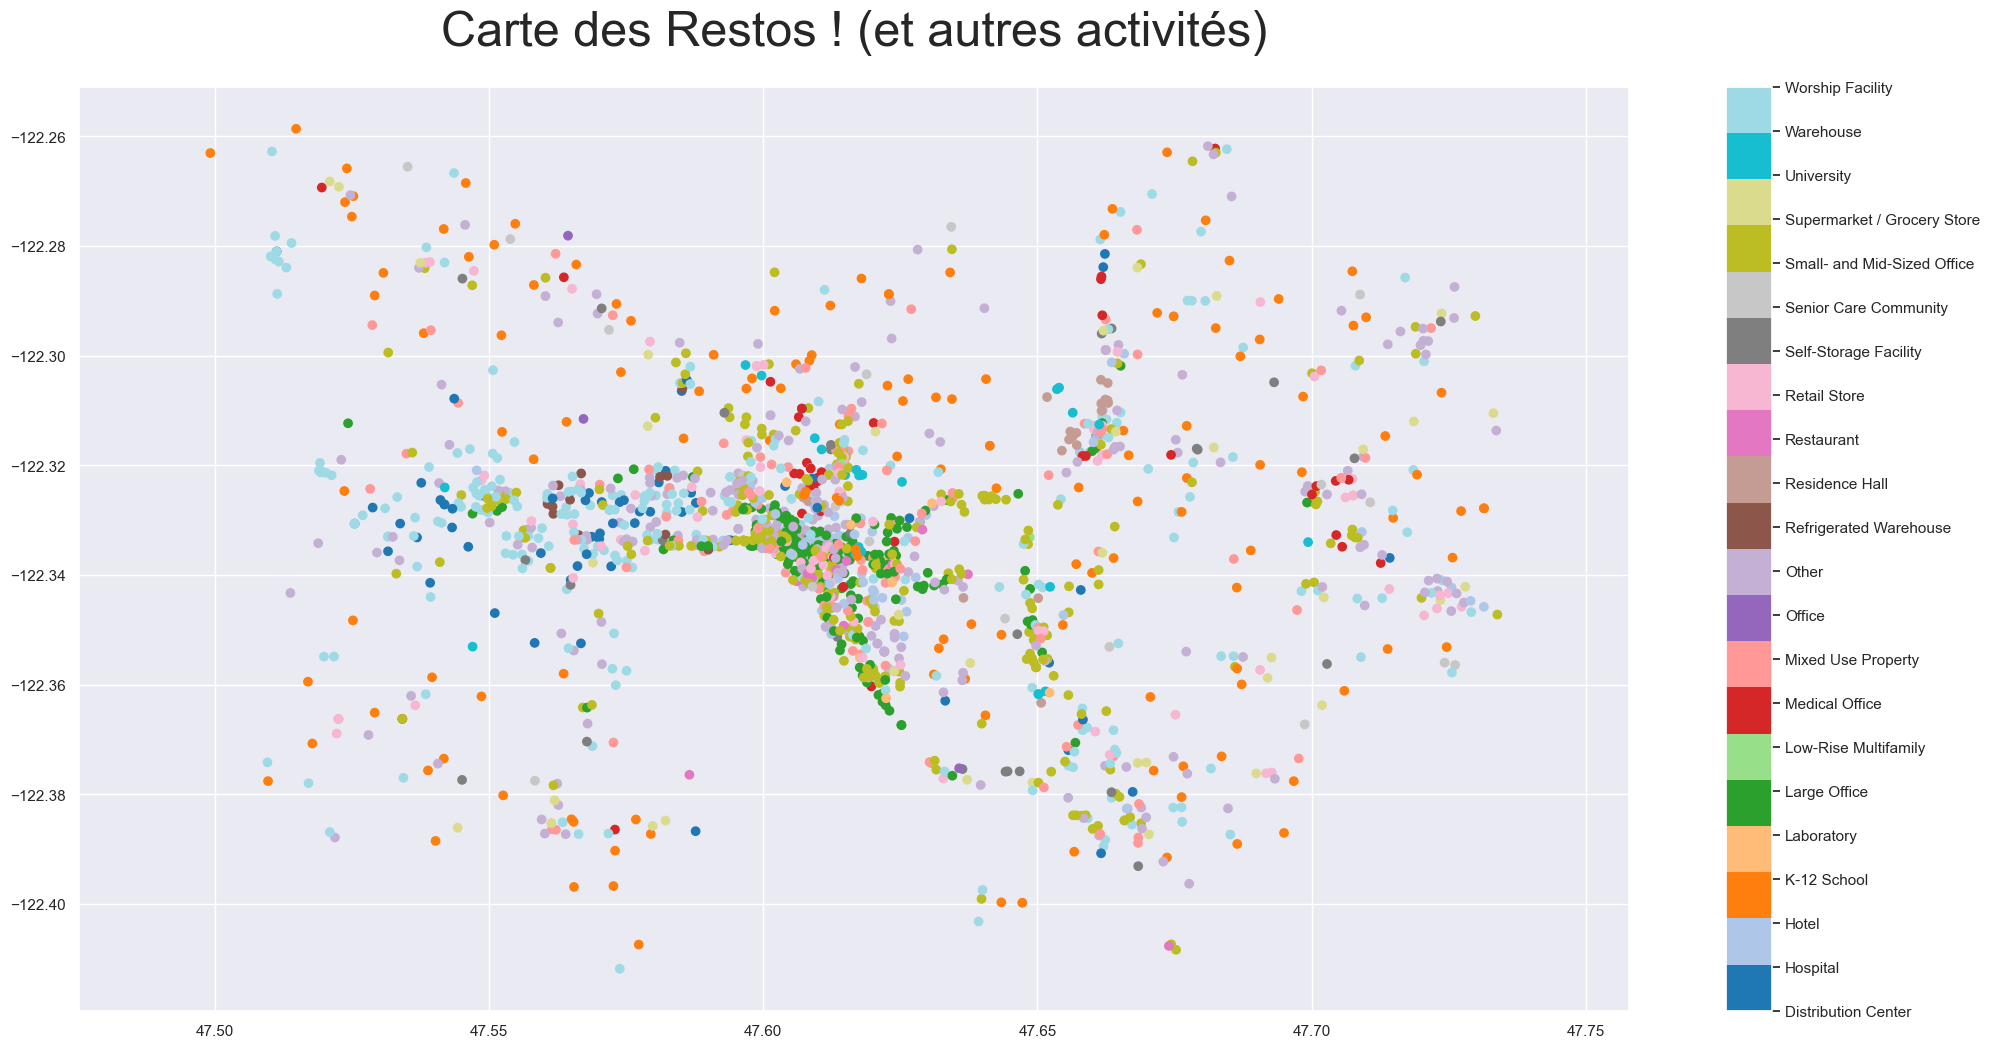

In [61]:
# Assuming 'Neighborhood' is a categorical variable
neighborhood_colors = subset_NR['PrimaryPropertyType'].astype('category')
neighborhood_labels = neighborhood_colors.cat.categories
neighborhood_codes = neighborhood_colors.cat.codes

# Set a custom colormap (e.g., 'viridis')
custom_cmap = 'tab20'

plt.scatter(subset_NR['Latitude'], subset_NR['Longitude'], c=neighborhood_codes, cmap=custom_cmap)

# Set equal aspect ratio to maintain real proportions
plt.axis('equal')

# Create a custom colorbar with labels
cbar = plt.colorbar(ticks=range(len(neighborhood_labels)))
cbar.set_ticklabels(neighborhood_labels)

plt.title('Carte des Restos ! (et autres activités)', fontsize=35)
plt.show()


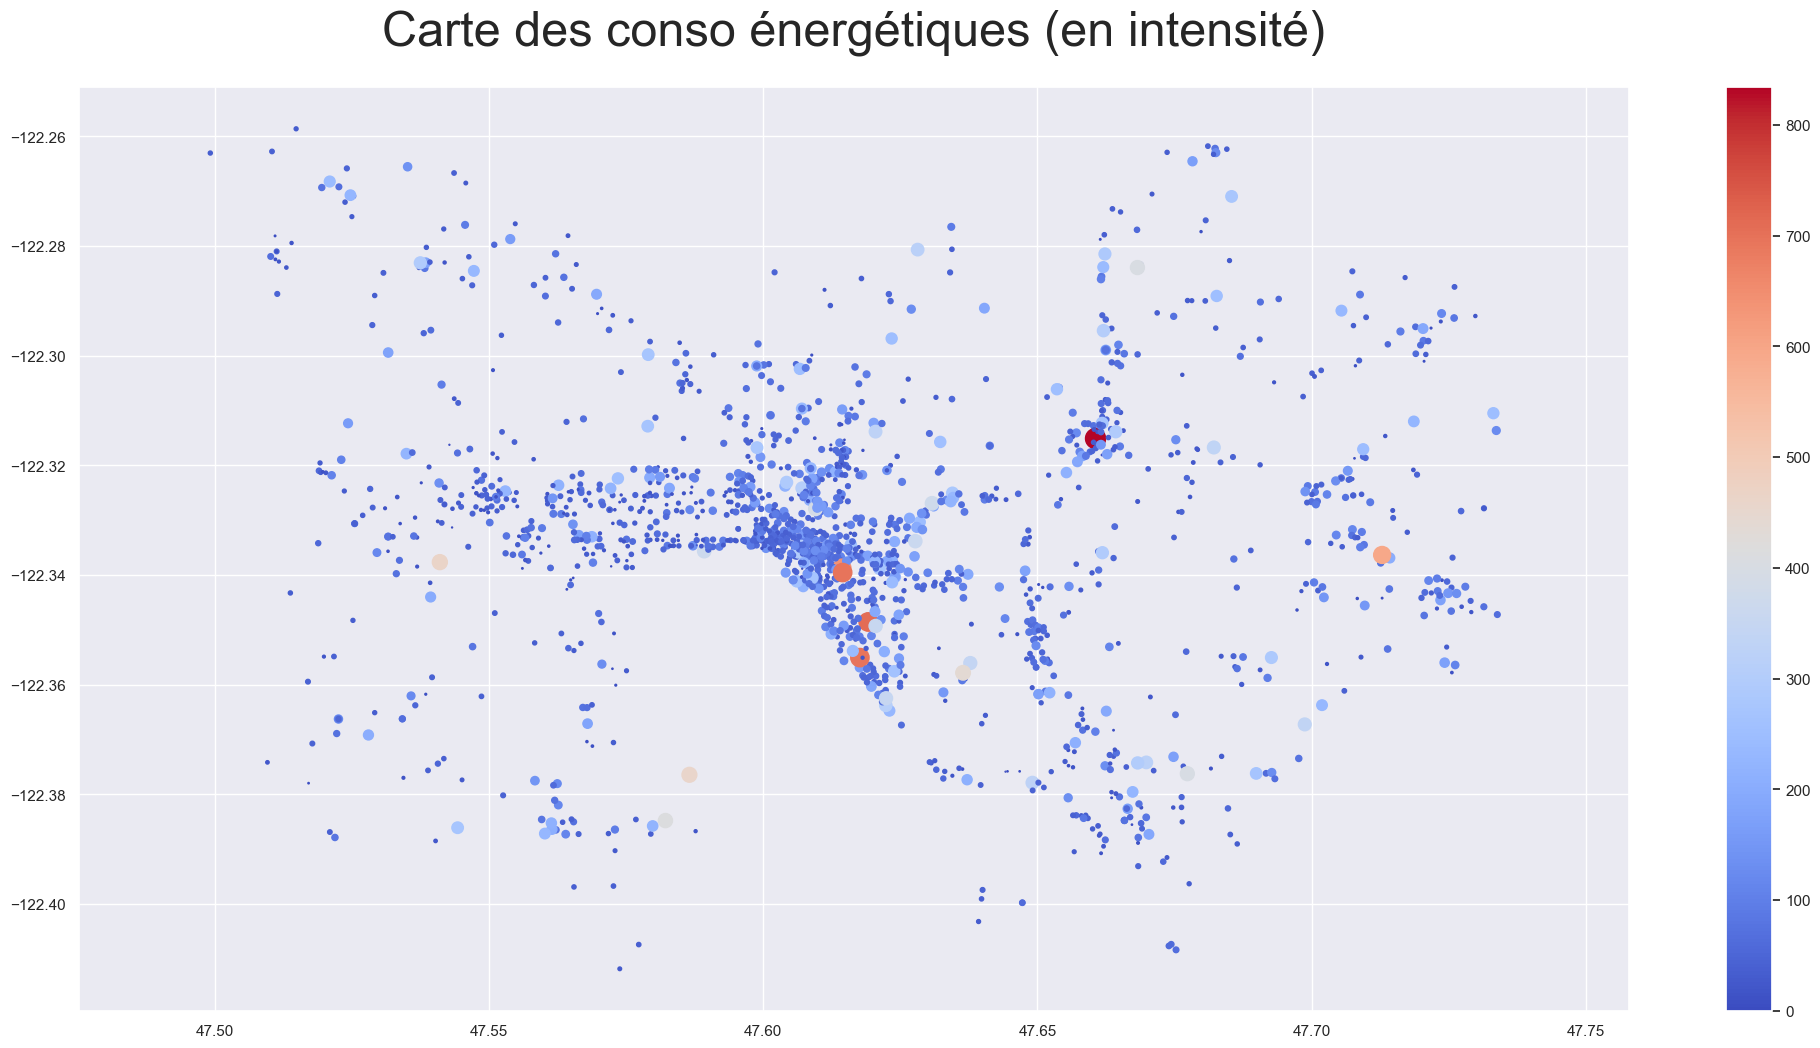

In [90]:
# cmap = 'inferno'
cmap = 'coolwarm'
# cmap = 'plasma'
# cmap = 'cividis'

# Size of the points based on the energy conso
point_size = subset_NR['SiteEUI(kBtu/sf)'] * 0.25

plt.scatter(subset_NR['Latitude'], subset_NR['Longitude'], c=subset_NR['SiteEUI(kBtu/sf)'], cmap=cmap, s=point_size)

# plt.xlim([47.5, 47.75])
# plt.ylim([-122.45, -122.2])

# You can set custom labels for the colorbar
plt.colorbar()

# Set equal aspect ratio to maintain real proportions
plt.axis('equal')

plt.title('Carte des conso énergétiques (en intensité)', fontsize=35)
plt.show()


### 2.5 YearBuilt

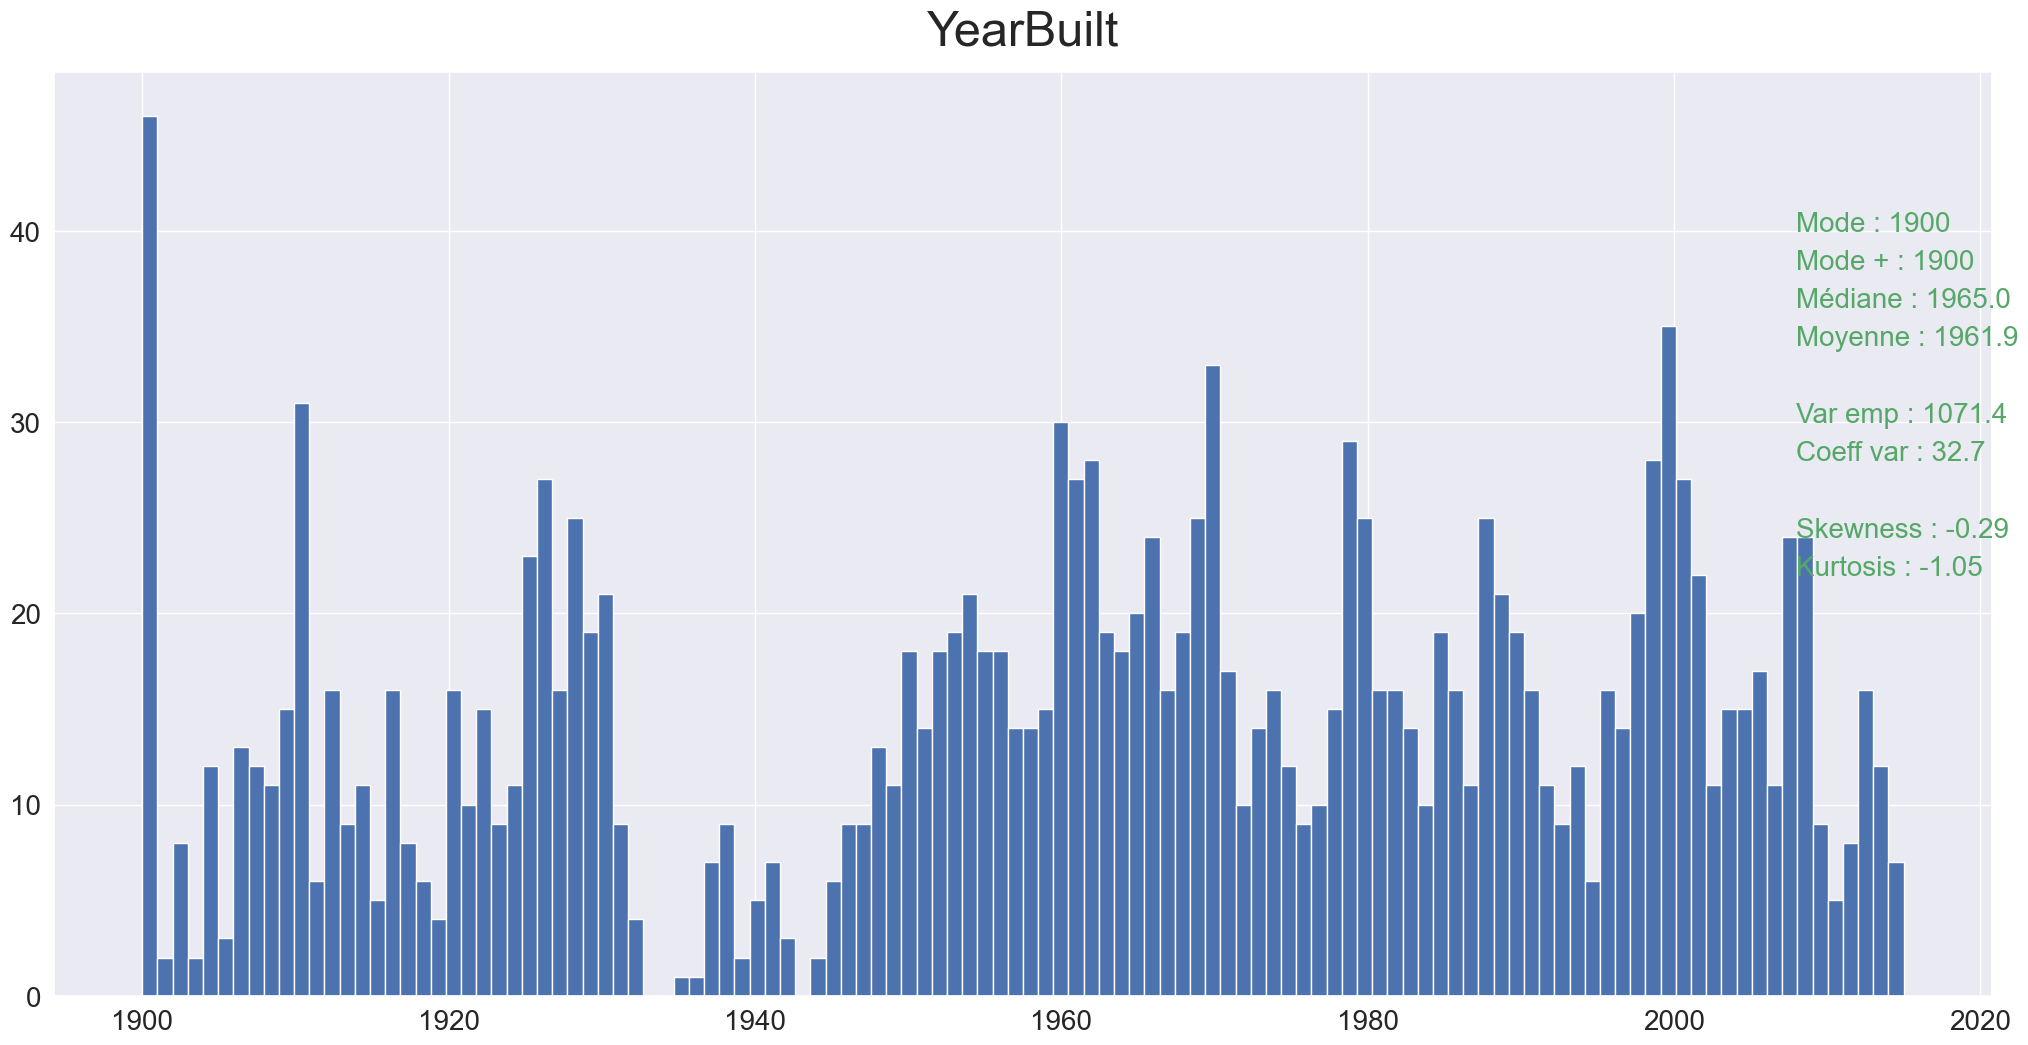

-0.29

In [ ]:
hist_distrib(subset_NR, 'YearBuilt', 116, 1, density=False)
# Un siècle d'Histoire, vue par un maçon de Seattle


### 2.6 NumberofBuildings

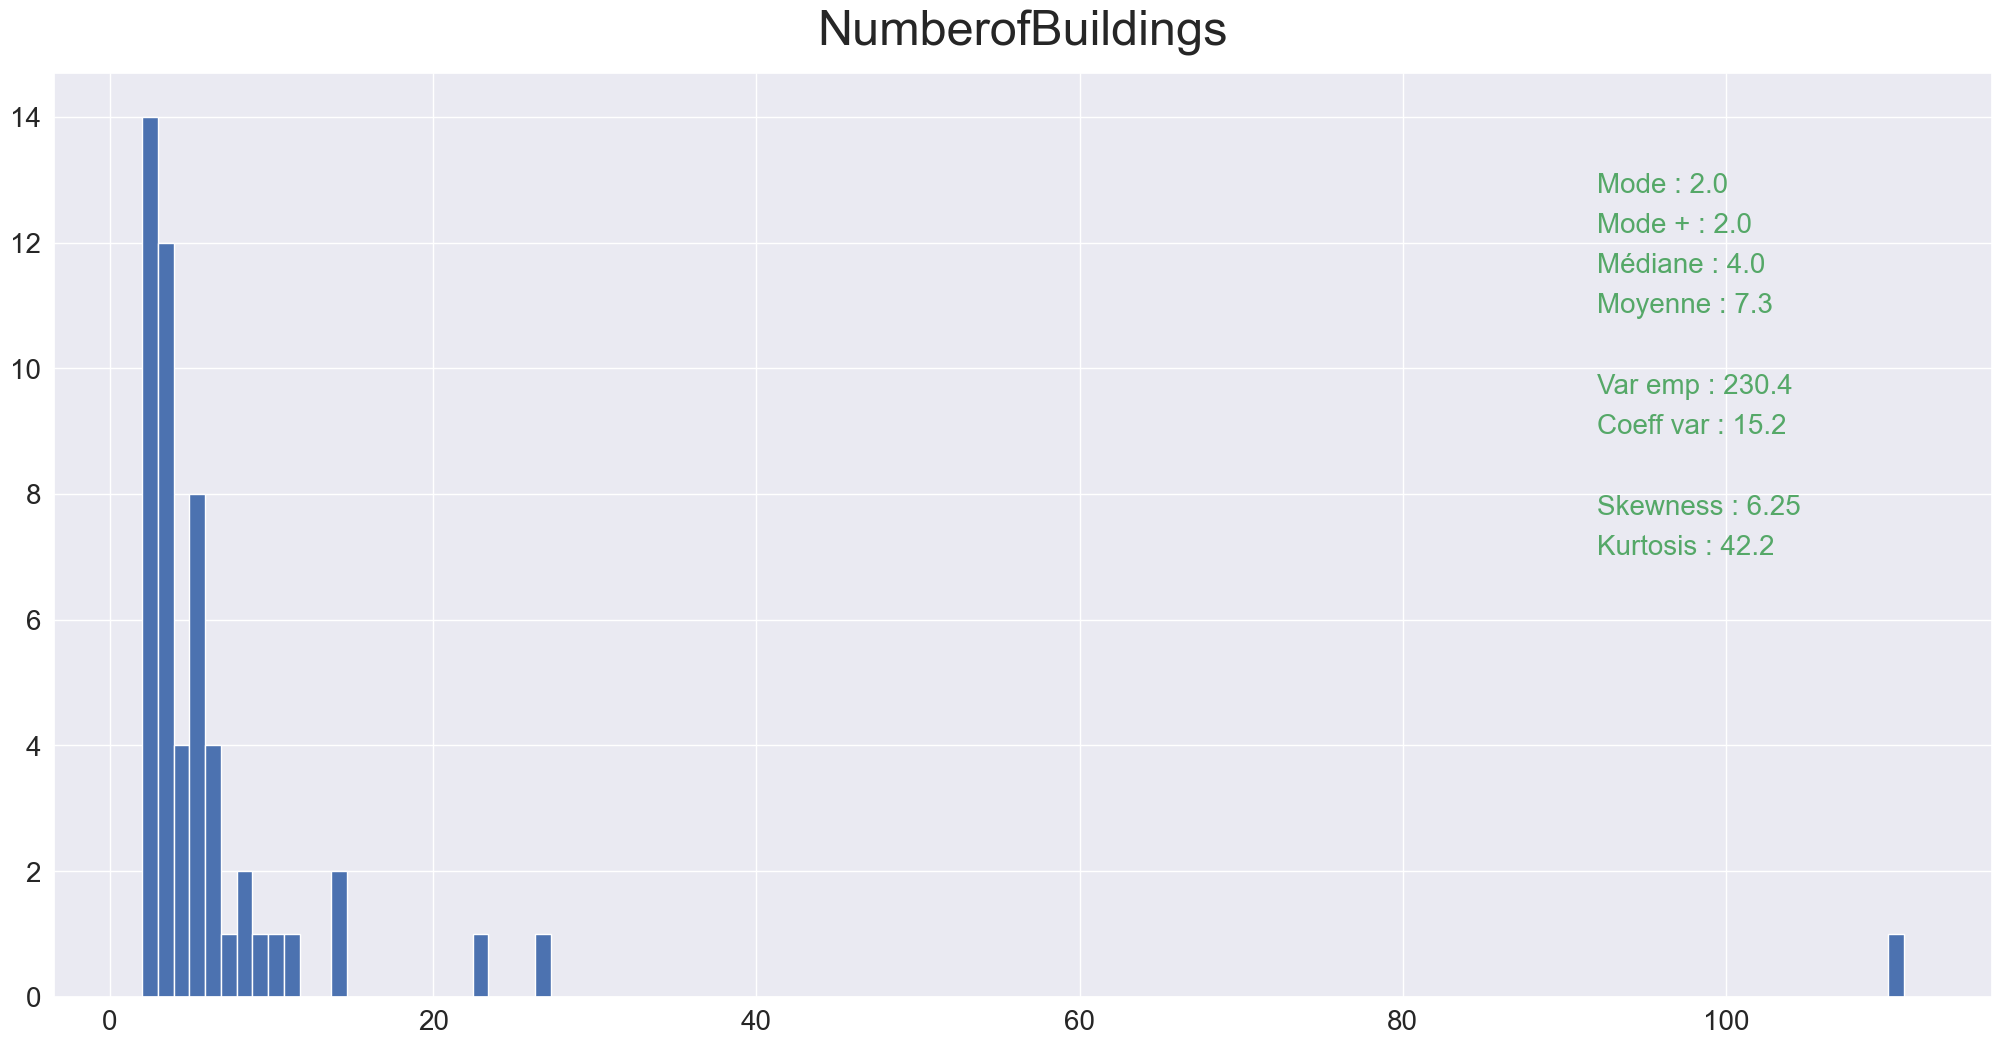

6.25

In [ ]:
hist_distrib(subset_NR.loc[subset_NR['NumberofBuildings'] > 1, :], 'NumberofBuildings', 112, 1, density=False)


In [ ]:
display(subset_NR.loc[subset_NR['NumberofBuildings'] > 100, :])
# Big fac !


OSEBuildingID BuildingType PrimaryPropertyType  \
3274          49967       Campus          University   

                                   PropertyName                    Address  \
3274  University of Washington - Seattle Campus  NE 45th St & Brooklyn Ave   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
3274  98105.0                    1625049001                    4    NORTHEAST   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
3274  47.65644 -122.31041       1900              111.0               0   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
3274           9320156                   0                 9320156   

     ListOfAllPropertyUseTypes LargestPropertyUseType  \
3274        College/University     College/University   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
3274                  9320156.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
3274                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
3274                             NaN                      NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
3274              NaN         93.800003                 0.0   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
3274          246.600006                   0.0          873923712.0   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
3274                    0.0      84985240.0       192577488.0   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
3274        657074389.0                 0.0               0.0        False   

     ComplianceStatus Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
3274        Compliant     NaN           11140.56                    1.2

### 2.7 NumberofFloors

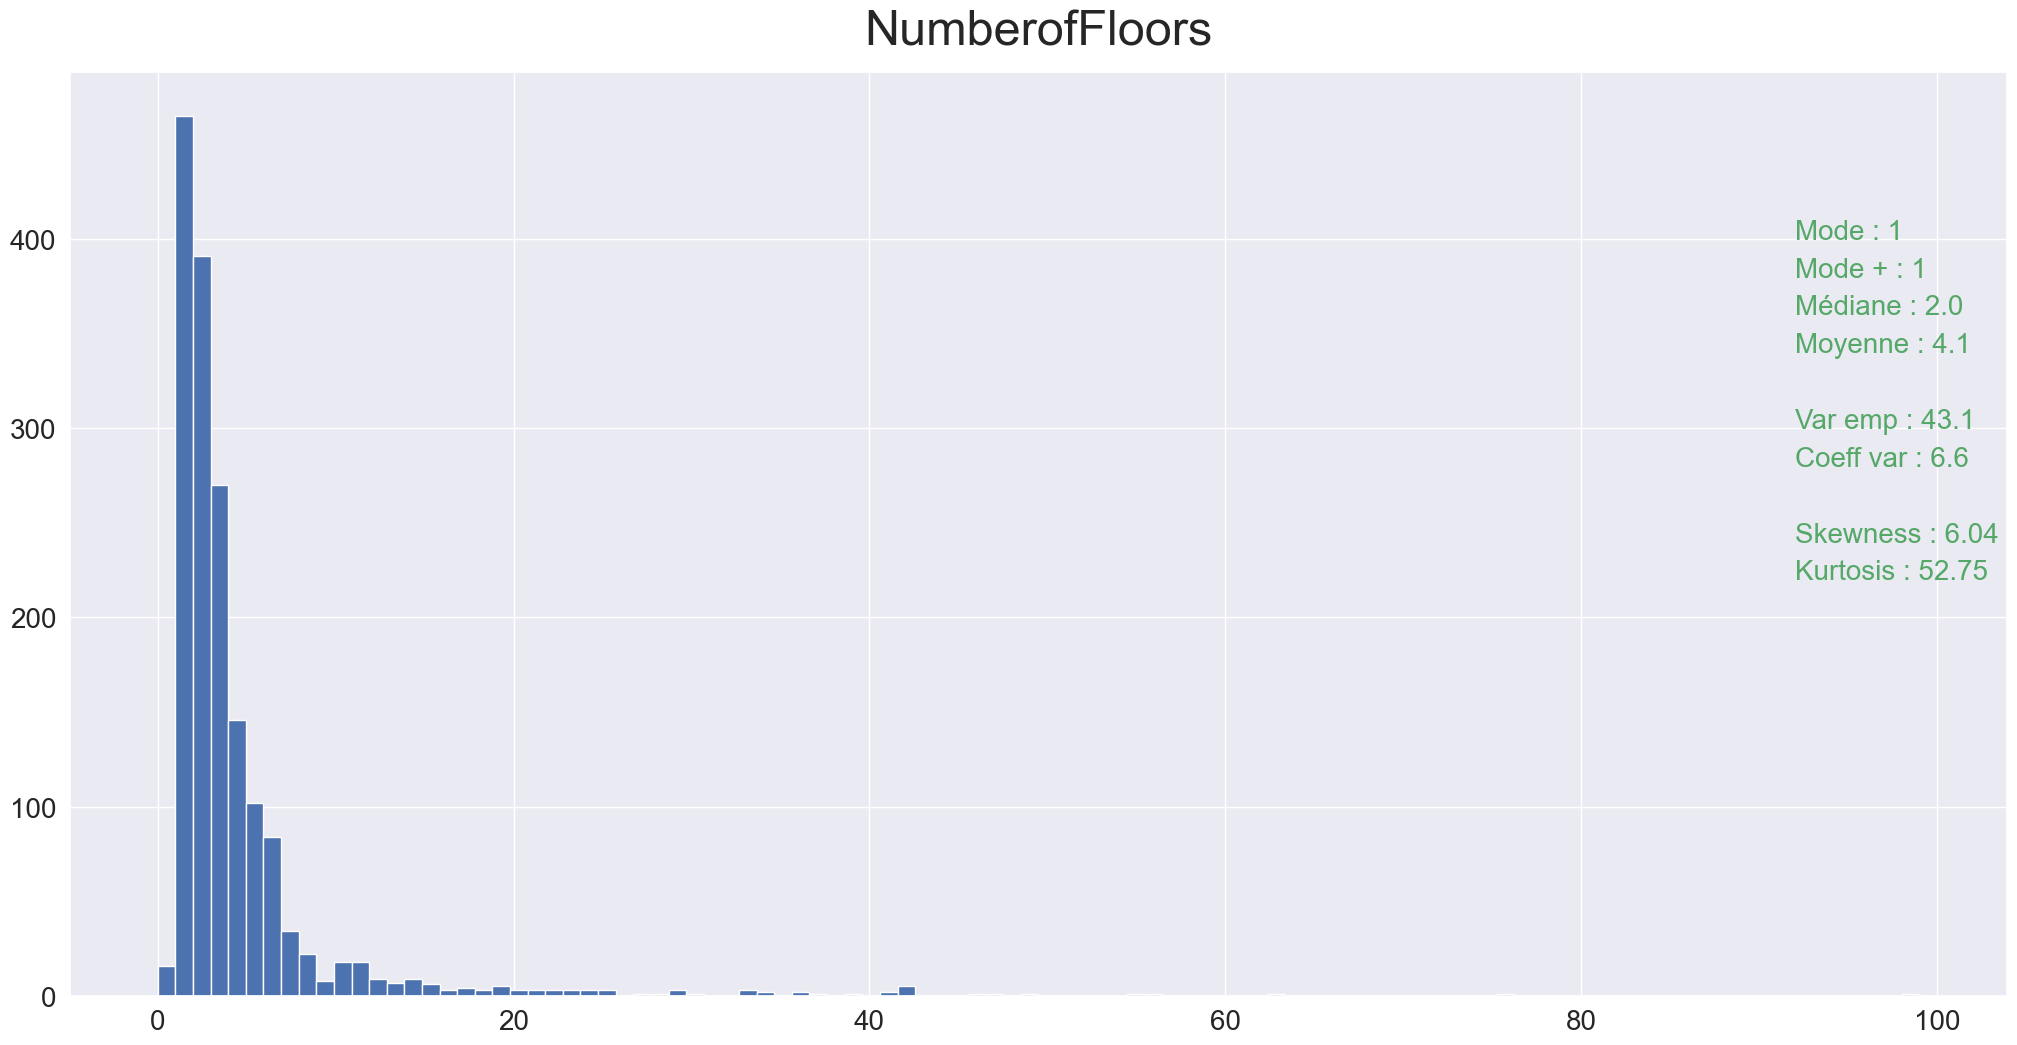

6.04

In [ ]:
hist_distrib(subset_NR, 'NumberofFloors', 100, 1, density=False)
# Ca donne le vertige !


In [ ]:
display(subset_NR.loc[subset_NR['NumberofFloors'] > 45, :])


OSEBuildingID        BuildingType PrimaryPropertyType  \
221             345      NonResidential        Large Office   
229             353      NonResidential        Large Office   
233             357  Nonresidential COS        Large Office   
271             399      NonResidential        Large Office   
273             402      NonResidential        Large Office   
292             422      NonResidential        Large Office   
559             775      NonResidential        Large Office   
1359          21611      NonResidential    Worship Facility   

                        PropertyName                     Address  ZipCode  \
221                 999 Third Avenue  999 3rd Avenue, Suite 1550  98104.0   
229                     Safeco Plaza          1001 Fourth Avenue  98154.0   
233   Seattle Municipal Tower (2030)            700 Fifth Avenue  98104.0   
271                1201 Third Avenue                1201 3rd ave  98101.0   
273                   US Bank Centre             1420 5th Avenue  98101.0   
292                 Two Union Square               601 Union St.  98101.0   
559           Columbia Center - 2015              701 5th Avenue  98104.0   
1359  Seattle Chinese Baptist Church    5801 Beacon Avenue South  98108.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode      Neighborhood  \
221                     0939000435                    7          DOWNTOWN   
229                     0942000300                    7          DOWNTOWN   
233                     0942000720                    3          DOWNTOWN   
271                     1974700120                    7          DOWNTOWN   
273                     1975700080                    7          DOWNTOWN   
292                     1976700125                    7          DOWNTOWN   
559                     0942000640                    7          DOWNTOWN   
1359                    2124049098                    2  GREATER DUWAMISH   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
221   47.60505 -122.33427       1983                1.0              47   
229   47.60615 -122.33388       1969                1.0              49   
233   47.60501 -122.32988       1990                1.0              63   
271   47.60723 -122.33611       1988                1.0              55   
273   47.61054 -122.33466       1989                1.0              46   
292   47.61043 -122.33206       1989                1.0              56   
559   47.60454 -122.33072       1985                1.0              76   
1359  47.55072 -122.30265       1977                1.0              99   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
221            1323055                   0                 1323055   
229            1123435              368980                  754455   
233            1354987              159600                 1195387   
271            1400000              285000                 1115000   
273            1536606              512608                 1023998   
292            1605578              389860                 1215718   
559            1952220              319400                 1632820   
1359             21948                   0                   21948   

                              ListOfAllPropertyUseTypes  \
221                         Office, Parking, Restaurant   
229   Financial Office, Food Sales, Office, Other, P...   
233                                     Office, Parking   
271                  Office, Other, Parking, Restaurant   
273   Financial Office, Office, Other, Parking, Rest...   
292                              Office, Other, Parking   
559                                     Office, Parking   
1359                                   Worship Facility   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
221                  Office                  1011135.0   
229                  Office                   808980.0   
233                  Office          

In [ ]:
# Notre outlier du nb d'étages est donc la Seattle Chinese Baptist Church.
# En réalité elle comporte 1 étage, on peut donc corriger notre valeur

subset_NR.loc[subset_NR['NumberofFloors'] == 99, 'NumberofFloors'] = 1

subset_NR.describe()


OSEBuildingID       ZipCode  CouncilDistrictCode     Latitude  \
count    1668.000000   1652.000000          1668.000000  1668.000000   
mean    16336.346523  98116.819613             4.356715    47.616054   
std     13835.292512     18.430353             2.191048     0.048168   
min         1.000000  98006.000000             1.000000    47.499170   
25%       582.750000  98105.000000             2.000000    47.585458   
50%     21143.500000  98109.000000             4.000000    47.612340   
75%     24602.250000  98125.000000             7.000000    47.649675   
max     50226.000000  98199.000000             7.000000    47.733870   

         Longitude    YearBuilt  NumberofBuildings  NumberofFloors  \
count  1668.000000  1668.000000        1666.000000      1668.00000   
mean   -122.332908  1961.913669           1.168667         4.06235   
std       0.024580    32.741755           2.931409         6.13845   
min    -122.411820  1900.000000           0.000000         0.00000   
25%    -122.343280  1930.000000           1.000000         1.00000   
50%    -122.332935  1965.000000           1.000000         2.00000   
75%    -122.321675  1989.000000           1.000000         4.00000   
max    -122.258640  2015.000000         111.000000        76.00000   

       PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count      1.668000e+03         1668.000000            1.668000e+03   
mean       1.188427e+05        12897.979017            1.059447e+05   
std        2.973622e+05        42274.511185            2.842116e+05   
min        1.128500e+04            0.000000            3.636000e+03   
25%        2.947775e+04            0.000000            2.847525e+04   
50%        4.928950e+04            0.000000            4.739150e+04   
75%        1.053250e+05            0.000000            9.475975e+04   
max        9.320156e+06       512608.000000            9.320156e+06   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count               1.662000e+03                       855.000000   
mean                9.876469e+04                     36804.160581   
std                 2.767111e+05                     69845.261024   
min                 5.656000e+03                         0.000000   
25%                 2.552750e+04                      5350.000000   
50%                 4.377050e+04                     12000.000000   
75%                 9.198375e+04                     31881.000000   
max                 9.320156e+06                    686750.000000   

       ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
count                       353.00000      1094.000000       1665.000000   
mean                      14923.13994        65.449726         72.158799   
std                       36790.55656        28.492928         74.048129   
min                           0.00000         1.000000          0.000000   
25%                        2663.00000        48.000000         33.700001   
50%                        5931.00000        73.000000         51.900002   
75%                       12941.00000        89.000000         81.699997   
max                      459748.00000       100.000000        834.400024   

       SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
count         1665.000000         1666.000000           1666.000000   
mean            74.568529          175.829892            178.090876   
std             75.028403          185.932121            185.918749   
min              0.000000            0.000000             -2.100000   
25%             35.400002           76.450001             79.325003   
50%             53.900002          130.949997            134.150002   
75%             85.199997          203.950001            205.700001   
max            834.400024         2620.000000           2620.000000   

       SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
count         1.666000e+03           1.665000e+03    1.666000e+03   
me

### 2.8 Surfaces

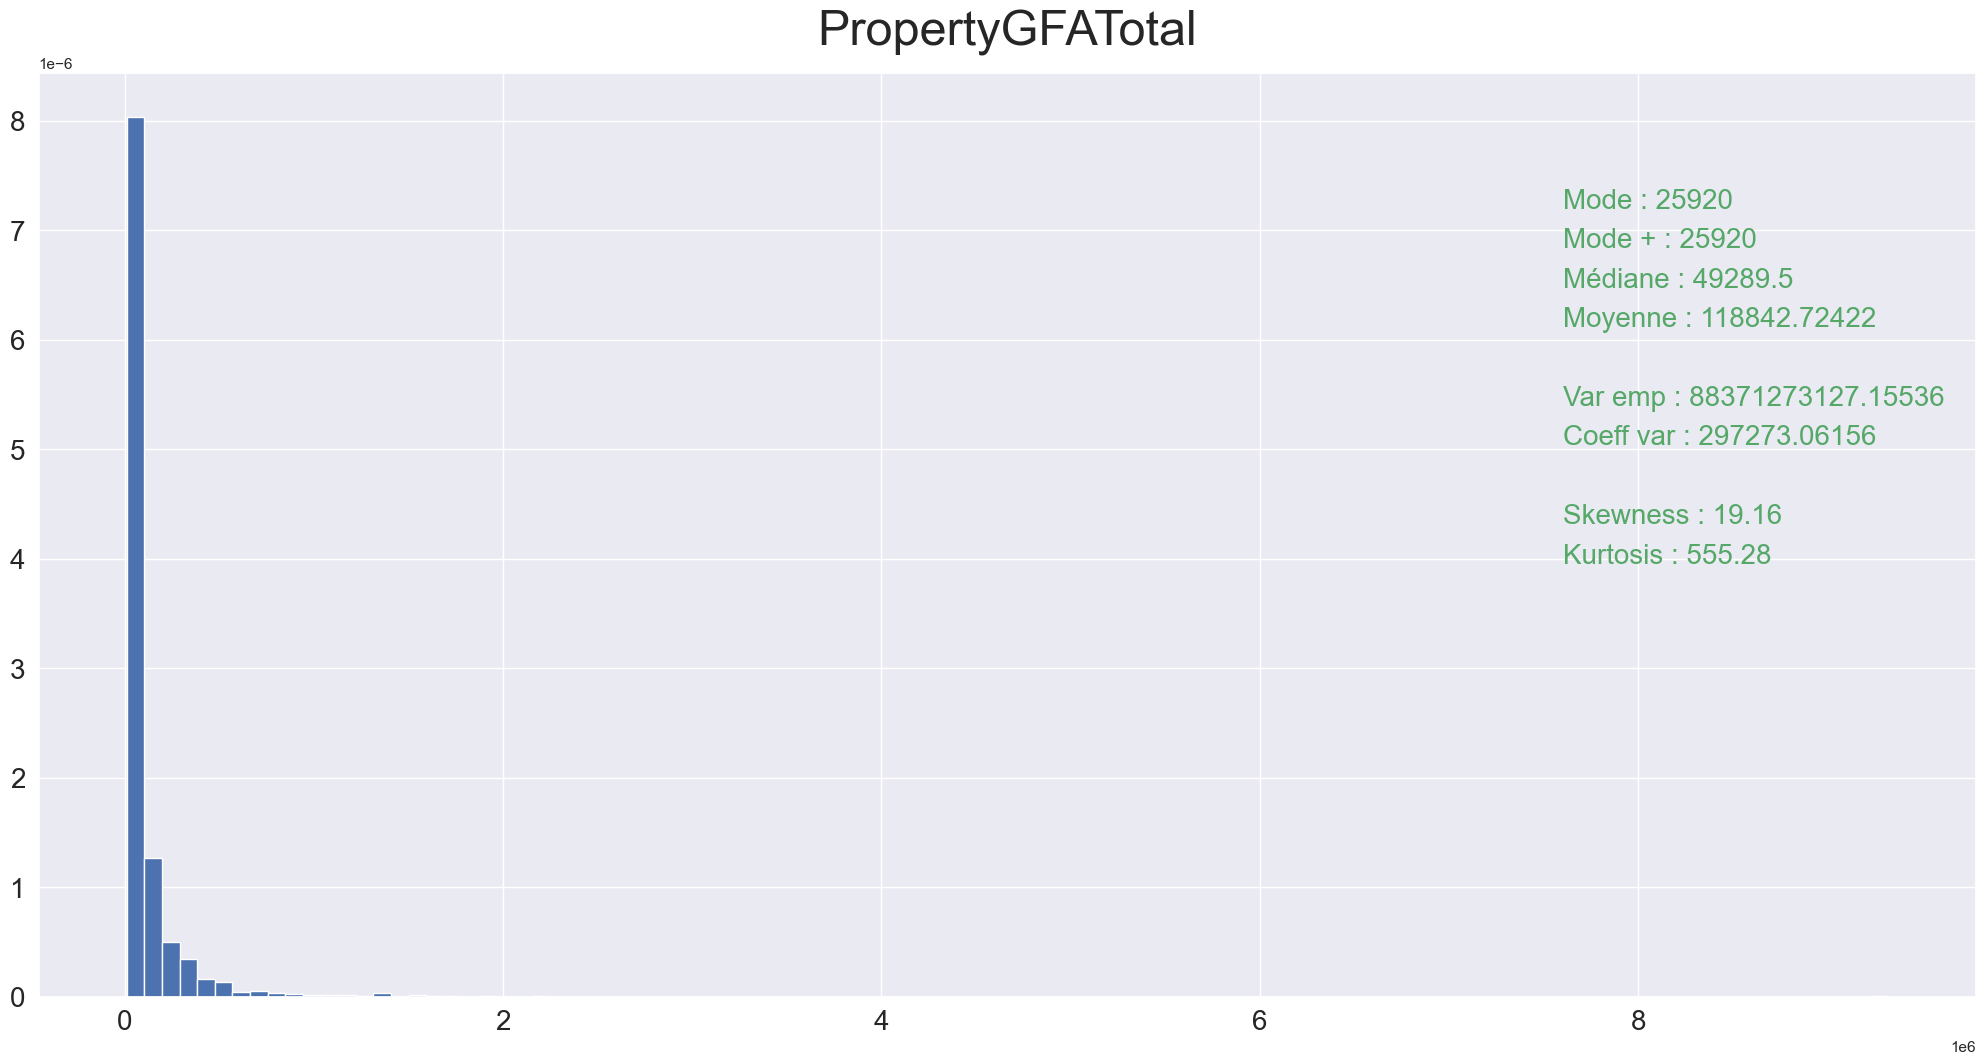

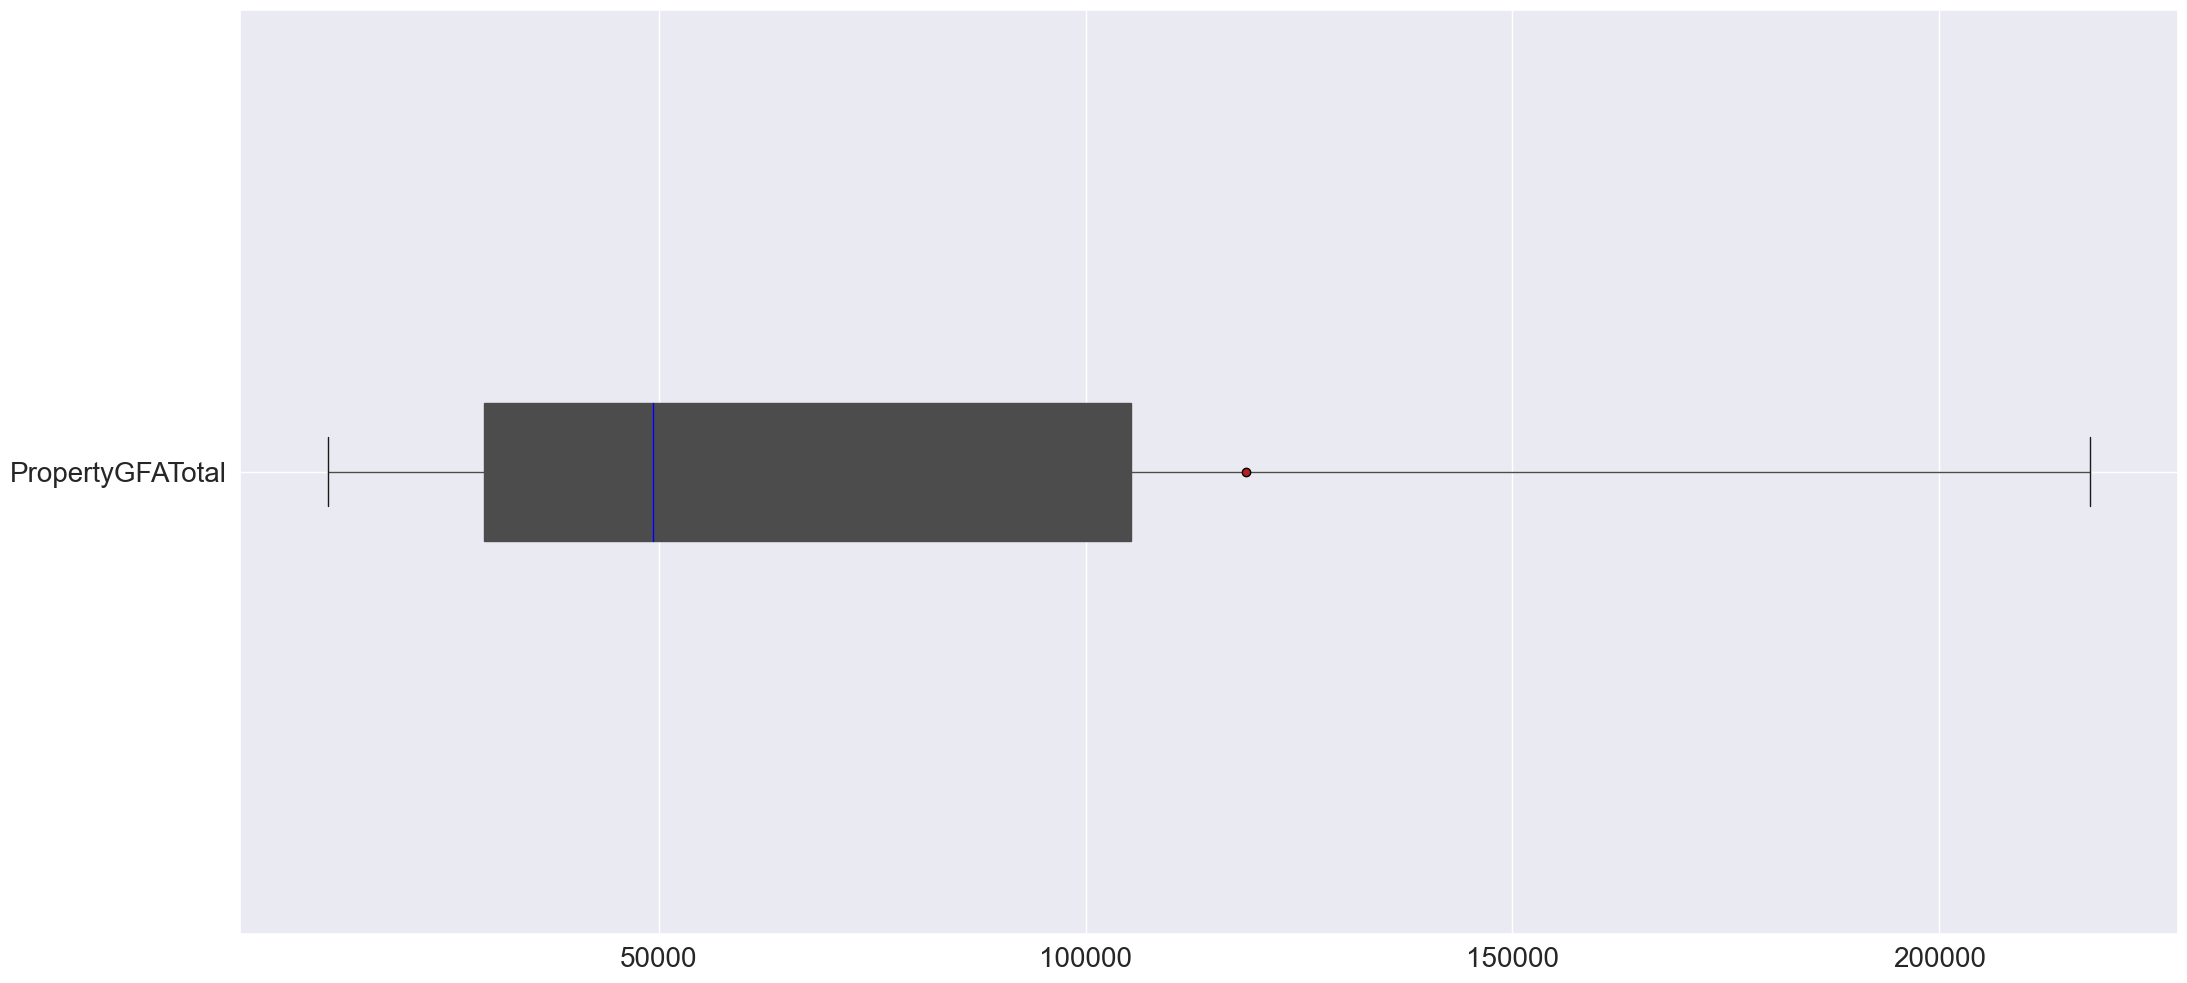

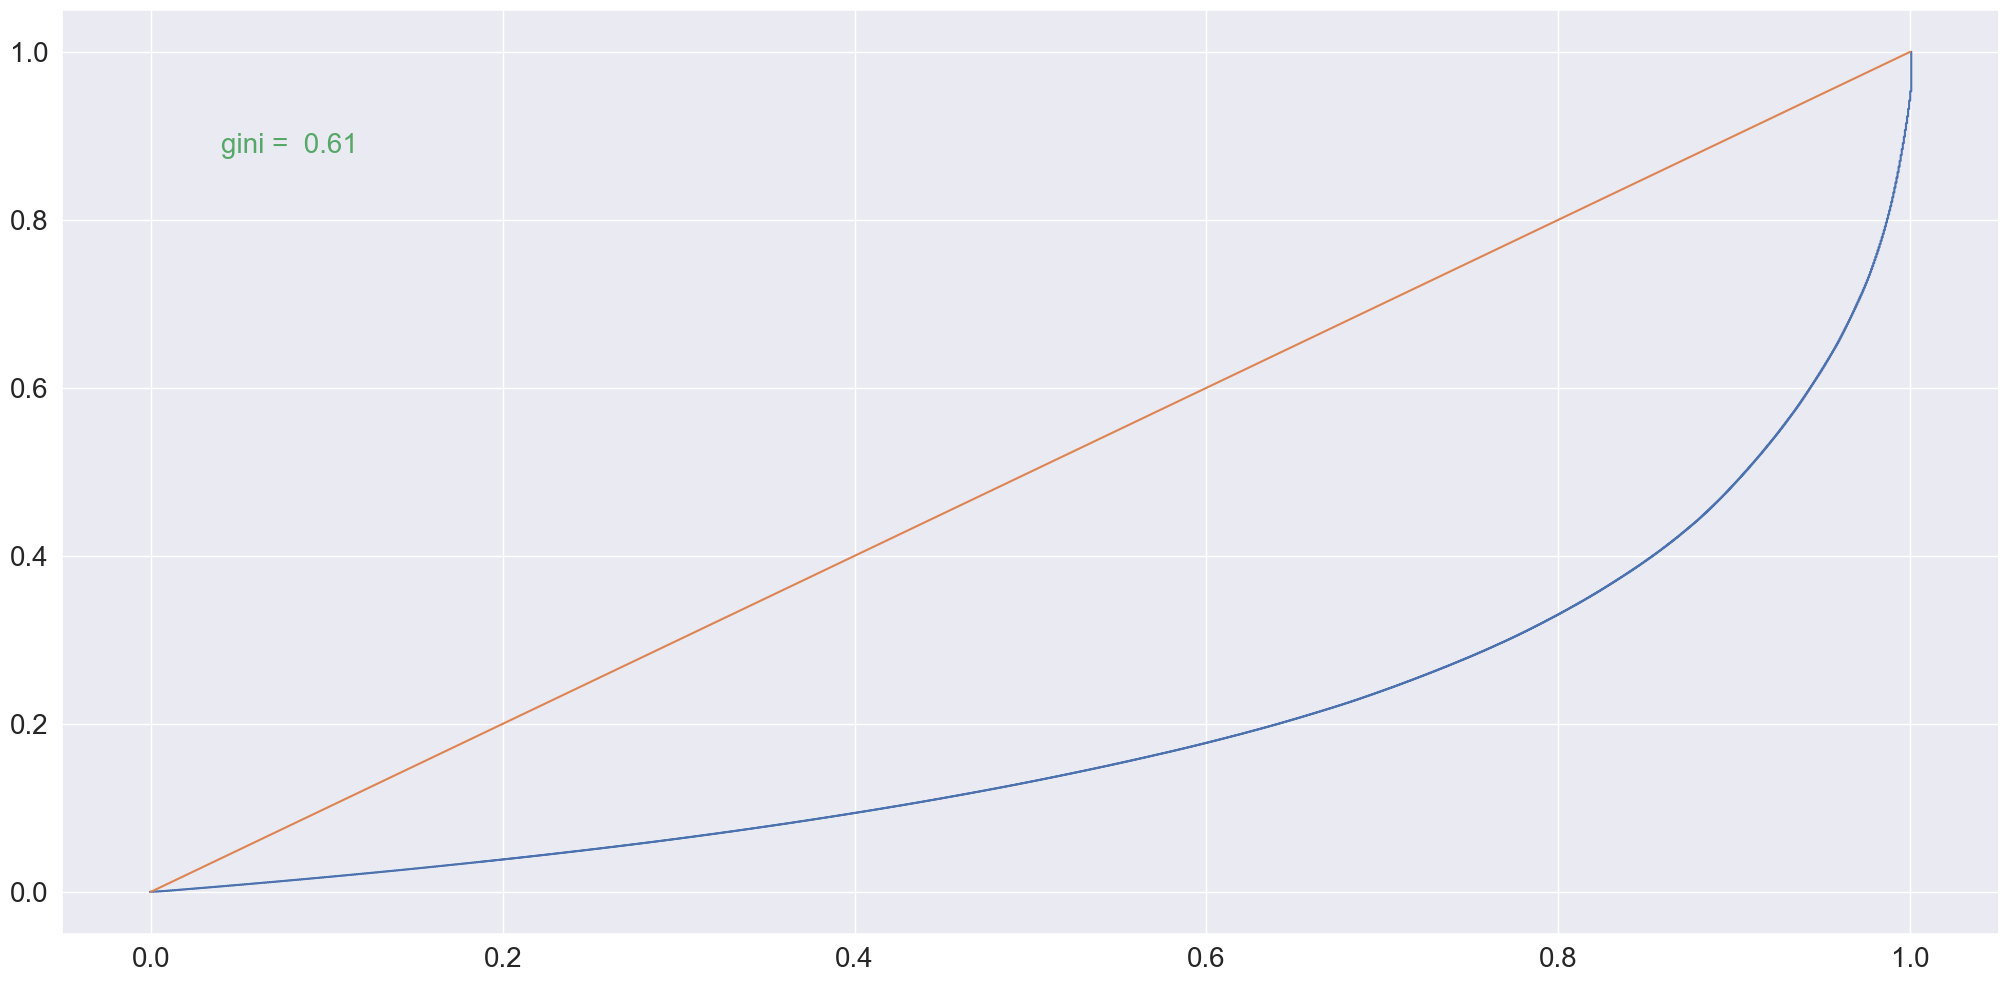

OSEBuildingID        BuildingType PrimaryPropertyType  \
0                 1      NonResidential               Hotel   
1                 2      NonResidential               Hotel   
2                 3      NonResidential               Hotel   
3                 5      NonResidential               Hotel   
4                 8      NonResidential               Hotel   
...             ...                 ...                 ...   
3371          50222  Nonresidential COS              Office   
3372          50223  Nonresidential COS               Other   
3373          50224  Nonresidential COS               Other   
3374          50225  Nonresidential COS  Mixed Use Property   
3375          50226  Nonresidential COS  Mixed Use Property   

                             PropertyName           Address  ZipCode  \
0                    Mayflower park hotel     405 Olive way  98101.0   
1                         Paramount Hotel   724 Pine street  98101.0   
2                 5673-The Westin Seattle   1900 5th Avenue  98101.0   
3                               HOTEL MAX    620 STEWART ST  98101.0   
4             WARWICK SEATTLE HOTEL (ID8)     401 LENORA ST  98121.0   
...                                   ...               ...      ...   
3371                Horticulture building  1600 S Dakota St      NaN   
3372  International district/Chinatown CC     719 8th Ave S      NaN   
3373                      Queen Anne Pool    1920 1st Ave W      NaN   
3374          South Park Community Center    8319 8th Ave S      NaN   
3375          Van Asselt Community Center  2820 S Myrtle St      NaN   

     TaxParcelIdentificationNumber  CouncilDistrictCode  \
0                       0659000030                    7   
1                       0659000220                    7   
2                       0659000475                    7   
3                       0659000640                    7   
4                       0659000970                    7   
...                            ...                  ...   
3371                    1624049080                    2   
3372                    3558300000                    2   
3373                    1794501150                    7   
3374                    7883603155                    1   
3375                    7857002030                    2   

               Neighborhood  Latitude  Longitude  YearBuilt  \
0                  DOWNTOWN  47.61220 -122.33799       1927   
1                  DOWNTOWN  47.61317 -122.33393       1996   
2                  DOWNTOWN  47.61393 -122.33810       1969   
3                  DOWNTOWN  47.61412 -122.33664       1926   
4                  DOWNTOWN  47.61375 -122.34047       1980   
...                     ...       ...        ...        ...   
3371       GREATER DUWAMISH  47.56722 -122.31154       1990   
3372               DOWNTOWN  47.59625 -122.32283       2004   
3373  MAGNOLIA / QUEEN ANNE  47.63644 -122.35784       1974   
3374       GREATER DUWAMISH  47.52832 -122.32431       1989   
3375       GREATER DUWAMISH  47.53939 -122.29536       1938   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0                   1.0              12             88434                   0   
1                   1.0              11            103566               15064   
2                   1.0              41            956110              196718   
3                   1.0              10             61320                   0   
4                   1.0              18            175580               62000   
...                 ...             ...               ...                 ...   
3371                1.0               1             12294                   0   
3372                1.0               1             16000                   0   
3373                1.0               1             13157                   0   
3374                1.0               1             14101                   0   
3375                1.0    

In [ ]:
# Les valeurs des surfaces sont-elles cohérentes ?

surface_test = \
    subset_NR['PropertyGFABuilding(s)'] + subset_NR['PropertyGFAParking'] - subset_NR['PropertyGFATotal']

surface_test.unique()
# ok. (Trop?) parfait. Une des 3 variables (parking ?) doit être calculée à partir des 2 autres

graphs_analyse_uni(subset_NR.loc[subset_NR['PropertyGFATotal'] > 0, :], 'PropertyGFATotal', bins=100, r=5, density=True)
# Les inégalités chez les ultra-riches !
# Ah non c des bureaux, hopitaux, facs.

display(subset_NR.loc[subset_NR['PropertyGFATotal'] > 0, :])


### 2.9 Sources d'énergie

In [ ]:
# Energie (intensité) = Energit ttle / surface
# Mais quelle surface est prise en compte ? Totale ? Building ?

# SiteEnergyUse(kBtu) / SiteEUI(kBtu/sf) = surface
# Prenons un exemple qui n'est pas un outlier (ici, )
# 9.293764e+07 / 55.299999 = 1680608,35

# Ici aucune valeur ne correspond exactement. Les plus proches sont
# LargestPropertyUseTypeGFA et PropertyGFABuilding(s)

# Vérifions que 
# Energie ttle = somme energies (electricity, gaz, steam)

subset_NR['energy_test'] = subset_NR['SteamUse(kBtu)'] + subset_NR['Electricity(kBtu)'] \
    + subset_NR['NaturalGas(kBtu)'] - subset_NR['SiteEnergyUse(kBtu)']

subset_NR['energy_test'].describe()
# pas ok..

# Outliers ?


count    1.666000e+03
mean    -1.110232e+05
std      3.341107e+06
min     -1.318641e+08
25%     -7.500000e-01
50%     -2.500000e-01
75%      0.000000e+00
max      4.993620e+06
Name: energy_test, dtype: float64

In [ ]:
shape_head(subset_NR.loc[subset_NR['energy_test'].abs() > 10, :], 60)

# A supprimer ?


(48, 43)


OSEBuildingID        BuildingType          PrimaryPropertyType  \
31               37   SPS-District K-12                  K-12 School   
35               43              Campus           Mixed Use Property   
62               87   SPS-District K-12                  K-12 School   
69              103  Nonresidential COS                        Other   
70              104  Nonresidential COS                        Other   
71              106  Nonresidential COS                        Other   
73              110  Nonresidential COS                        Other   
75              112  Nonresidential COS                        Other   
81              118   SPS-District K-12                  K-12 School   
85              122   SPS-District K-12                  K-12 School   
95              140   SPS-District K-12                  K-12 School   
98              147      NonResidential                     Hospital   
124             198      NonResidential                     Hospital   
133             217   SPS-District K-12                  K-12 School   
139             227   SPS-District K-12                  K-12 School   
170             276      NonResidential                     Hospital   
206             328      NonResidential                 Large Office   
309             440      NonResidential           Mixed Use Property   
329             466      NonResidential                        Other   
371             523      NonResidential                 Large Office   
403             561      NonResidential                 Large Office   
448             608      NonResidential                 Large Office   
513             700      NonResidential  Supermarket / Grocery Store   
558             753      NonResidential                        Other   
559             775      NonResidential                 Large Office   
563             757      NonResidential                 Large Office   
601             803      NonResidential  Small- and Mid-Sized Office   
614             820   SPS-District K-12                  K-12 School   
618             828      NonResidential                     Hospital   
630             850   SPS-District K-12                  K-12 School   
1105          20868      NonResidential                 Large Office   
1280          21436  Nonresidential COS                        Other   
1291          21464  Nonresidential COS                        Other   
1292          21465  Nonresidential COS                        Other   
1894          23722   SPS-District K-12                  K-12 School   
2037          24216      NonResidential  Small- and Mid-Sized Office   
2441          25661      NonResidential  Small- and Mid-Sized Office   
2761          26849      NonResidential                 Retail Store   
2791          26973      NonResidential           Mixed Use Property   
3166          49703   SPS-District K-12                  K-12 School   
3182          49725      NonResidential                        Other   
3206          49784      NonResidential  Small- and Mid-Sized Office   
3230          49850      NonResidential                  K-12 School   
3264          49940      NonResidential                     Hospital   
3270          49958  Nonresidential COS                        Other   
3274          49967              Campus                   University   
3275          49968      NonResidential                   University   
3277          49972      NonResidential                   University   

                                           PropertyName  \
31                                  John Hay Elementary   
35                                         Plant 2 Site   
62                             Arbor Heights Elementary   
69                                            Key Arena   
70                                Bagley Wright Theatre   
71                                               Armory   
73                                      Exhibition Hall   
75   

### 2.10 Variables équivalentes (différentes unités)

In [ ]:
# Verifier que les valeurs à unités différentes sont cohérentes entre elles

# Electricity(kWh) vs Electricity(kBtu)

subset_NR['quotient_elec'] = subset_NR['Electricity(kBtu)'] / subset_NR['Electricity(kWh)']
display(subset_NR['quotient_elec'].describe())

shape_head(subset_NR.loc[subset_NR['quotient_elec'] < 3.41, :])
# Ils n'ont pas le même taux de conversion !?

# NaturalGas(therms) vs NaturalGas(kBtu)

# Bcp de gens n'utilisent pas le gaz naturel, seulement l'électricité
# On va donc éviter de diviser par 0

subset_gaz = subset_NR.loc[subset_NR['NaturalGas(kBtu)'] != 0, :].copy()

subset_gaz['quotient_gaz'] = subset_gaz['NaturalGas(kBtu)'] / subset_gaz['NaturalGas(therms)']

display(subset_gaz['quotient_gaz'].describe())
# C à peu près ça


count    1655.000000
mean        3.411751
std         0.010127
min         3.000000
25%         3.412000
50%         3.412000
75%         3.412000
max         3.412085
Name: quotient_elec, dtype: float64

(1, 44)


OSEBuildingID    BuildingType PrimaryPropertyType        PropertyName  \
1670          23064  NonResidential               Other  Evergreen Washelli   

                  Address  ZipCode TaxParcelIdentificationNumber  \
1670  11111 Aurora Ave. N  98133.0                    3026049008   

      CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  \
1670                    5    NORTHWEST  47.70969 -122.34557       1970   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
1670                5.0               1             23166                   0   

      PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
1670                   23166                     Other                  Other   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
1670                    23166.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
1670                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
1670                             NaN                      NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
1670              NaN             150.0               157.5   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
1670               157.5            165.399994           3475804.25   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
1670              3648465.5             0.0               1.0   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
1670                3.0         34758.00781         3475801.0        False   

     ComplianceStatus Outlier  TotalGHGEmissions  GHGEmissionsIntensity  \
1670        Compliant     NaN              184.6                   7.97   

      energy_test  quotient_elec  
1670        -0.25            3.0

count    1189.000000
mean      100.000014
std         0.000828
min        99.987152
25%        99.999996
50%       100.000000
75%       100.000004
max       100.019019
Name: quotient_gaz, dtype: float64

## 3 Outliers, nettoyage

### 3.1 Visualisation

In [ ]:
# 44 individus sont répertoriés comme outliers

print(subset_NR['Outlier'].unique())
print(subset_NR.shape)

outliers = subset_NR.loc[(subset_NR['Outlier'] == 'High outlier') 
                  | (subset_NR['Outlier'] == 'Low outlier'), :].copy()

print(outliers.shape)

no_outliers = subset_NR.loc[~((subset_NR['Outlier'] == 'High outlier') | \
    (subset_NR['Outlier'] == 'Low outlier')), :].copy()

print(no_outliers.shape)

display(outliers)




[nan 'High outlier' 'Low outlier']
(1668, 44)
(17, 44)
(1651, 44)


OSEBuildingID        BuildingType          PrimaryPropertyType  \
226             350      NonResidential                 Large Office   
384             539      NonResidential                 Retail Store   
448             608      NonResidential                 Large Office   
517             704      NonResidential                 Large Office   
839           19967   SPS-District K-12                  K-12 School   
1045          20617      NonResidential                 Retail Store   
1229          21315      NonResidential  Small- and Mid-Sized Office   
1295          21474      NonResidential                        Other   
1611          22830      NonResidential             Worship Facility   
1945          23912      NonResidential  Small- and Mid-Sized Office   
2129          24547      NonResidential                  K-12 School   
2189          24717      NonResidential                        Other   
2216          24825      NonResidential  Small- and Mid-Sized Office   
2410          25553      NonResidential                        Hotel   
2450          25674      NonResidential         Low-Rise Multifamily   
2801          27007      NonResidential             Worship Facility   
3152          43948  Nonresidential COS                        Other   

                        PropertyName                    Address  ZipCode  \
226       Second And Spring Building         1100 Second Avenue  98101.0   
384                University Center      4501 Roosevelt Way NE  98105.0   
448           411 1ST AVE  S (ID608)              411 1ST AVE S  98104.0   
517             401 Elliott Ave West        401 Elliot Ave West  98119.0   
839                   Queen Anne Gym             1431 2nd Ave N  98109.0   
1045           Seattle Habitat Store             21 S Nevada St  98134.0   
1229                 1518 Fifith Ave             1520 Fifth Ave  98101.0   
1295                  The Lusty Lady               1315 1st Ave  98101.0   
1611                  Freedom Church              9601 35th Ave  98126.0   
1945                  1416 S Jackson  1416 South Jackson Street  98133.0   
2129       Islamic School of Seattle               720 25TH AVE  98122.0   
2189        1701 First Ave South LLC       1701 First Ave South  98134.0   
2216                   2233 Building         2233 1st AVE.South  98104.0   
2410  J & M HOTEL BUILDING (ID25553)              210 1St Ave S  98104.0   
2450          (ID25674) COMET TAVERN              916 E PIKE ST  98122.0   
2801        Seattle Community Church        4501 46th Avenue NE  98105.0   
3152           Georgetown Steamplant     6605 13th Avenue South  98108.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode  \
226                     0942000045                    7   
384                     5335200380                    4   
448                     5247800200                    2   
517                     7666202110                    7   
839                     0811000005                    7   
1045                    1824049074                    2   
1229                    1975700135                    7   
1295                    1976200060                    7   
1611                    2858600090                    1   
1945                    3320000165                    3   
2129                    6840700175                    3   
2189                    7666207085                    2   
2216                    7666207190                    2   
2410                    5247800130                    7   
2450                    6003500480                    3   
2801                    5364200005                    4   
3152                    0000000000                    2   

               Neighborhood  Latitude  Longitude  YearBuilt  \
226                DOWNTOWN  47.60642 -122.33581       1958   
384               NORTHEAST  47.66178 -122.31812       1987   
448                DOWNTOWN  47.59878 -122.33458       1913   
517   MAGNOLIA / QUEEN AN

### 3.2 Comportement des ouliers / énergie

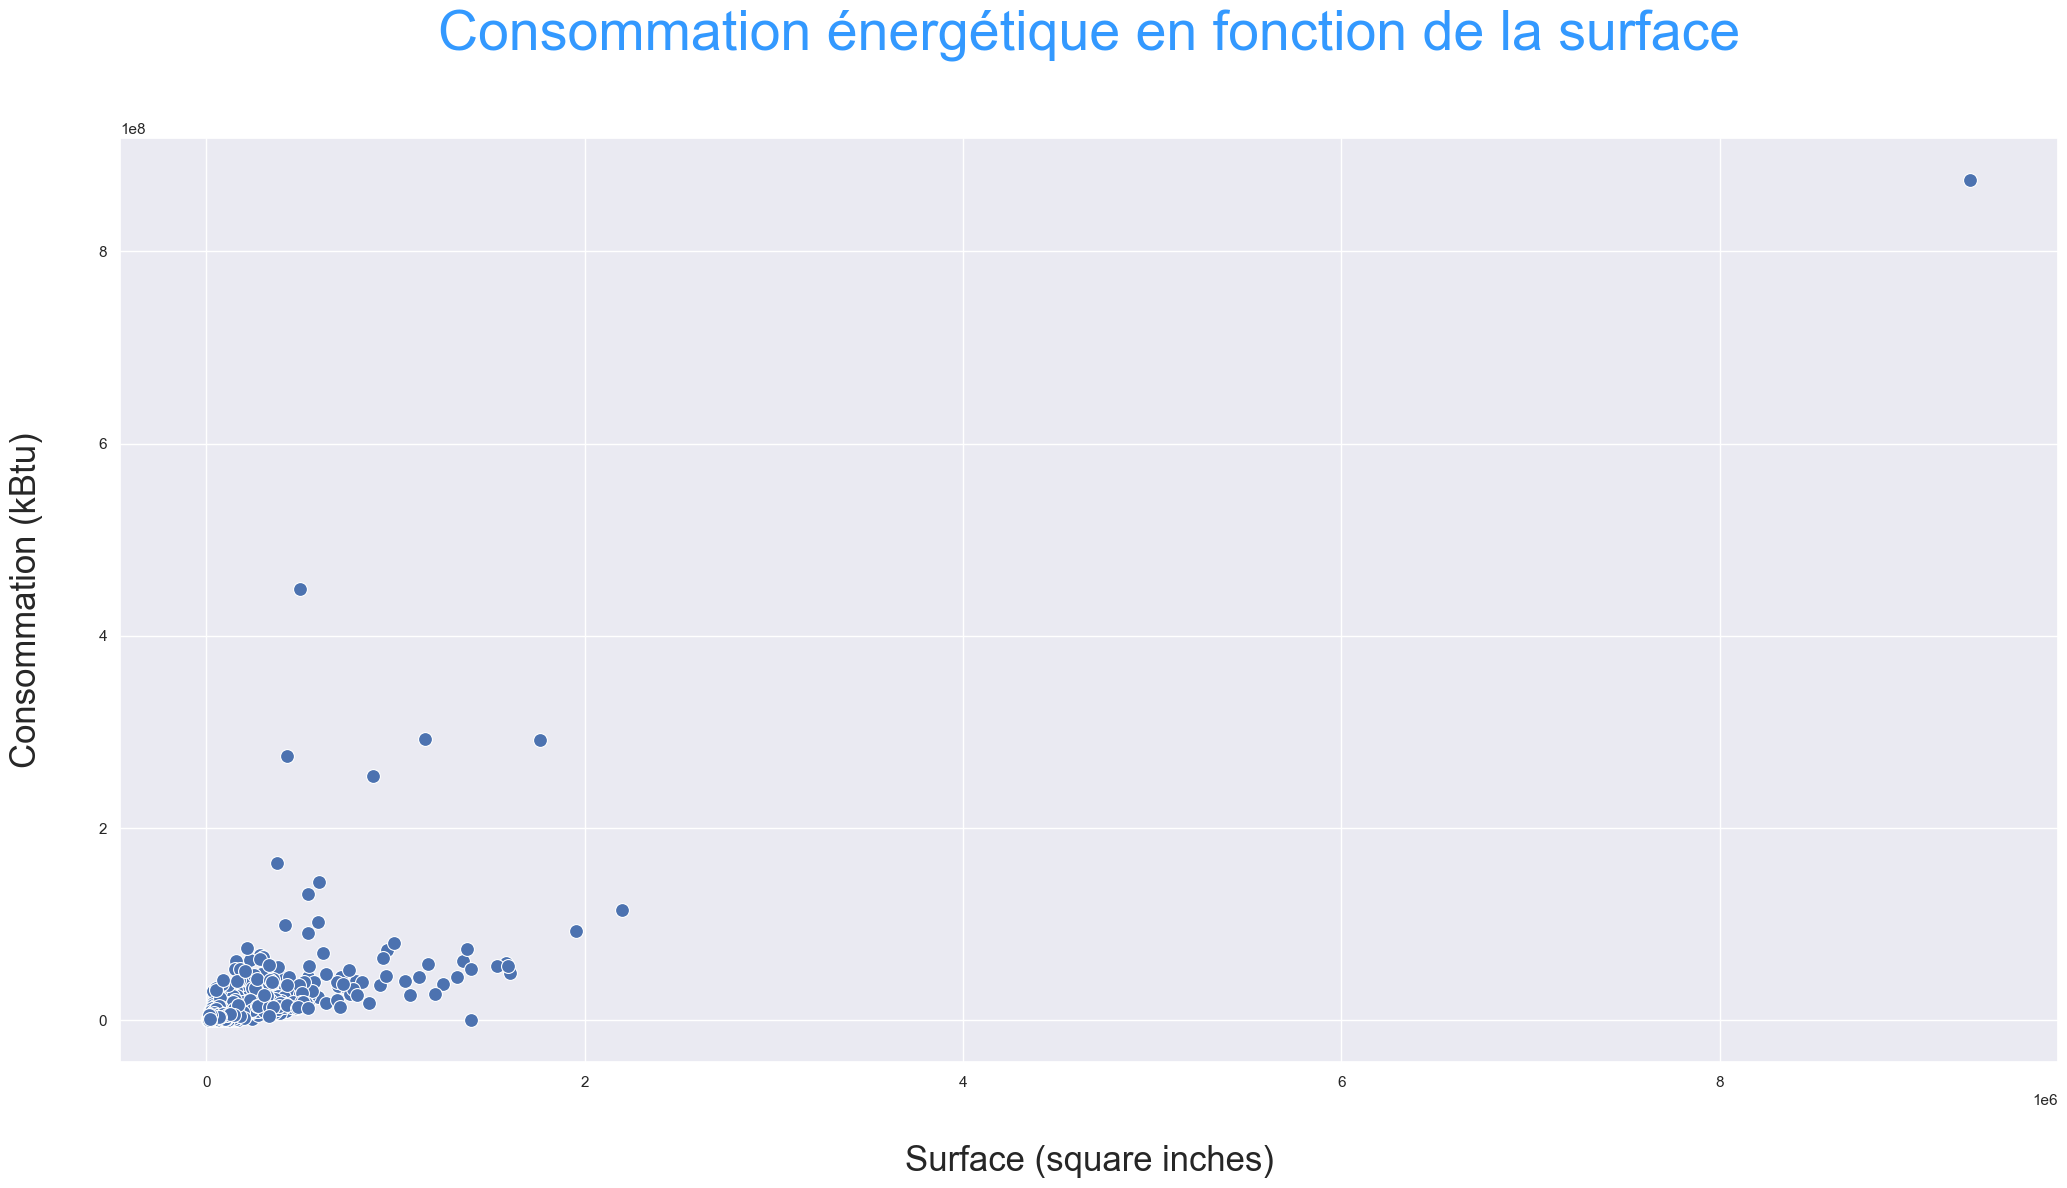

In [ ]:
# PropertyGFATotal

sns.scatterplot(subset_NR, x="PropertyGFATotal", y="SiteEnergyUse(kBtu)", s=100)
#plt.legend(title='Non outliers', fontsize=25, loc='upper left')
plt.xlabel('Surface (square inches)', fontsize=25, labelpad=40)
plt.ylabel('Consommation (kBtu)', fontsize=25, labelpad=40)

plt.title('Consommation énergétique en fonction de la surface', fontsize=40, y=1.05, color='#39f')
plt.show()

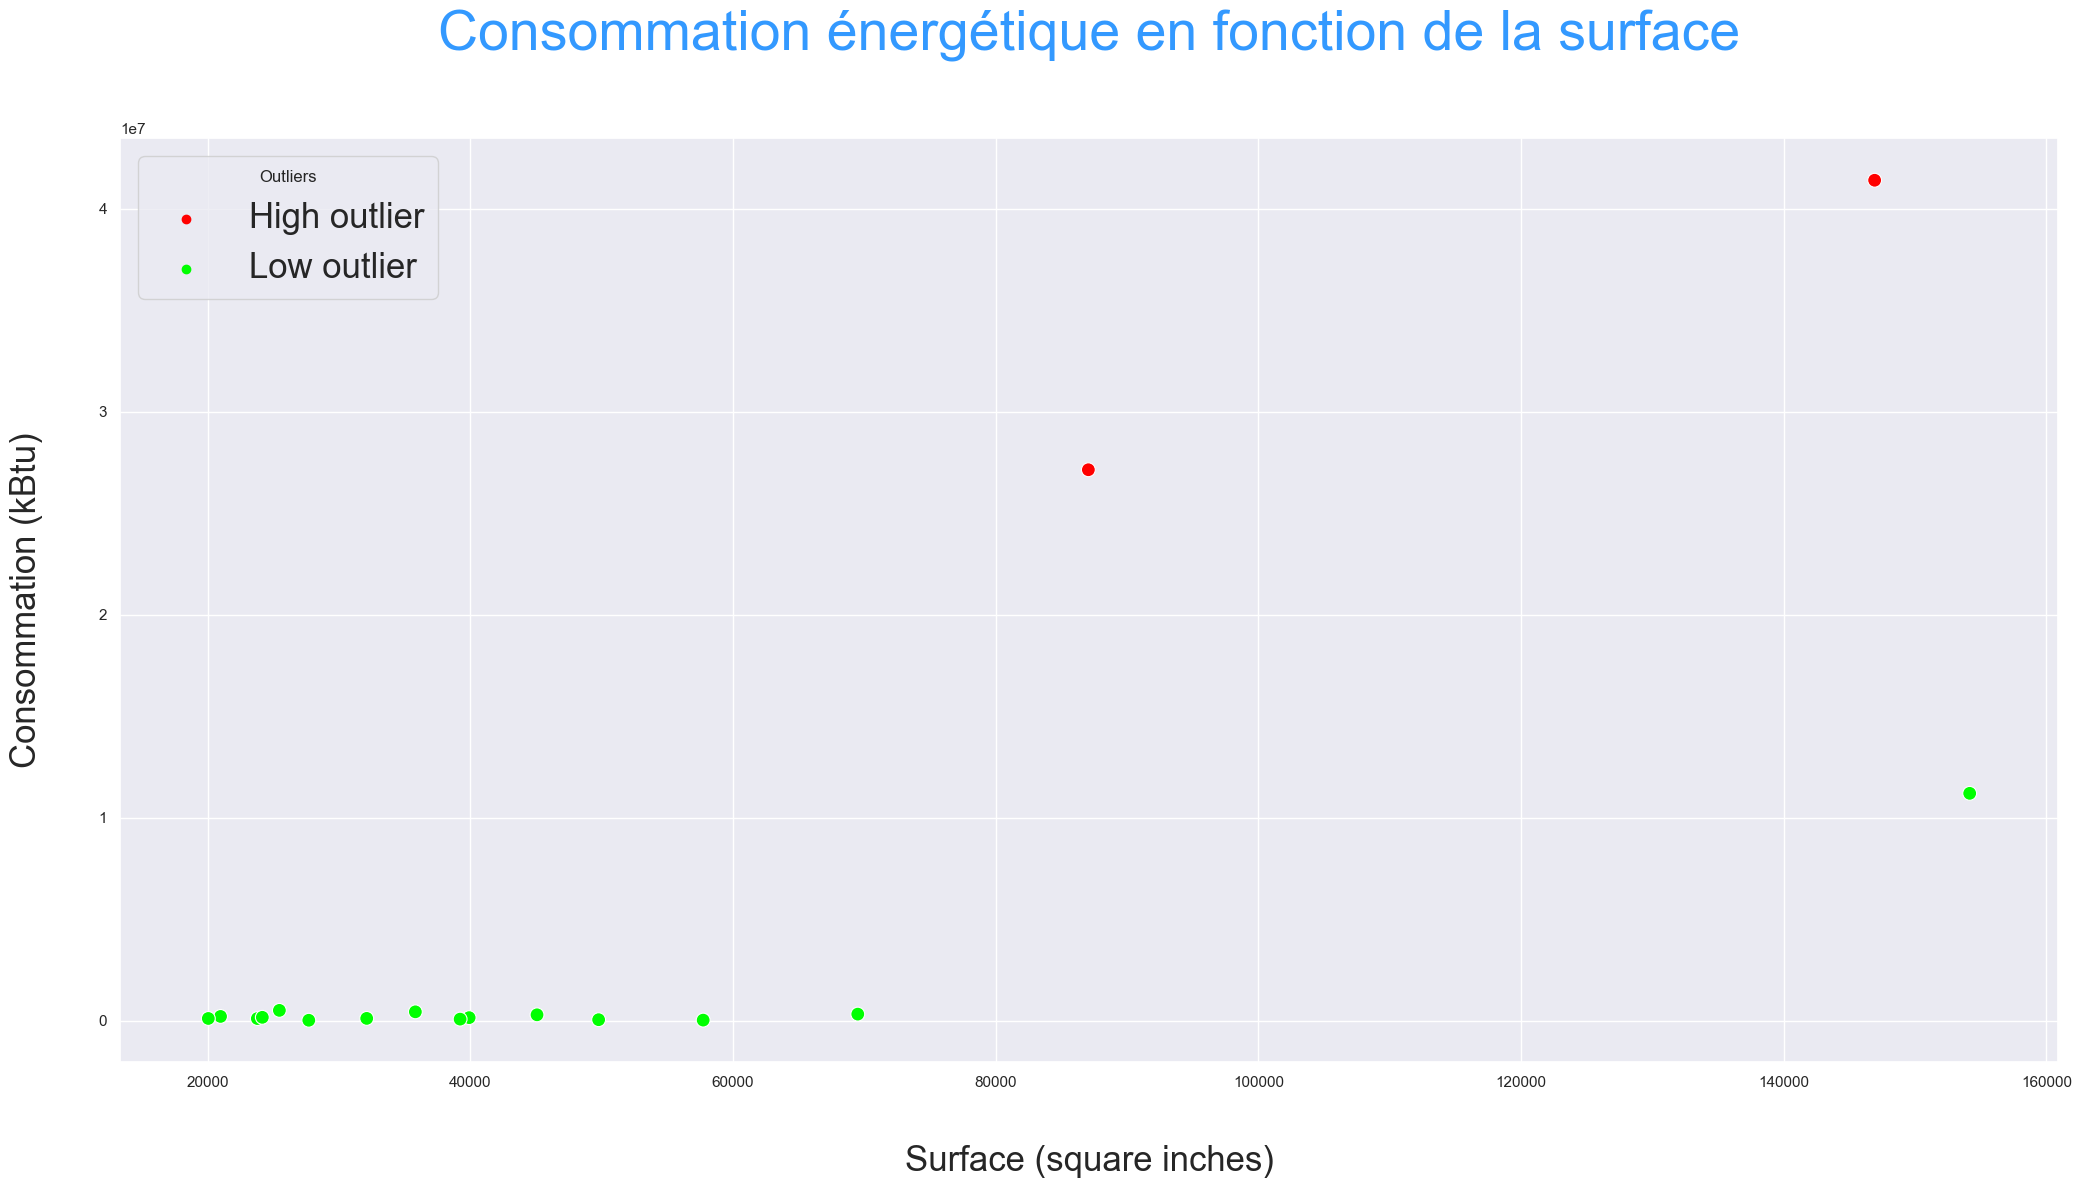

In [ ]:
# 17 outliers, 2 high, 15 low

# afficher 

palette = ['#f00','#0f0']

sns.scatterplot(outliers, x="PropertyGFABuilding(s)", y="SiteEnergyUse(kBtu)", \
    hue="Outlier", palette=palette, s=100)
plt.legend(title='Outliers', fontsize=25, loc='upper left')
plt.xlabel('Surface (square inches)', fontsize=25, labelpad=40)
plt.ylabel('Consommation (kBtu)', fontsize=25, labelpad=40)

plt.title('Consommation énergétique en fonction de la surface', fontsize=40, y=1.05, color='#39f')
plt.show()


### 3.3 Comportement "normal"

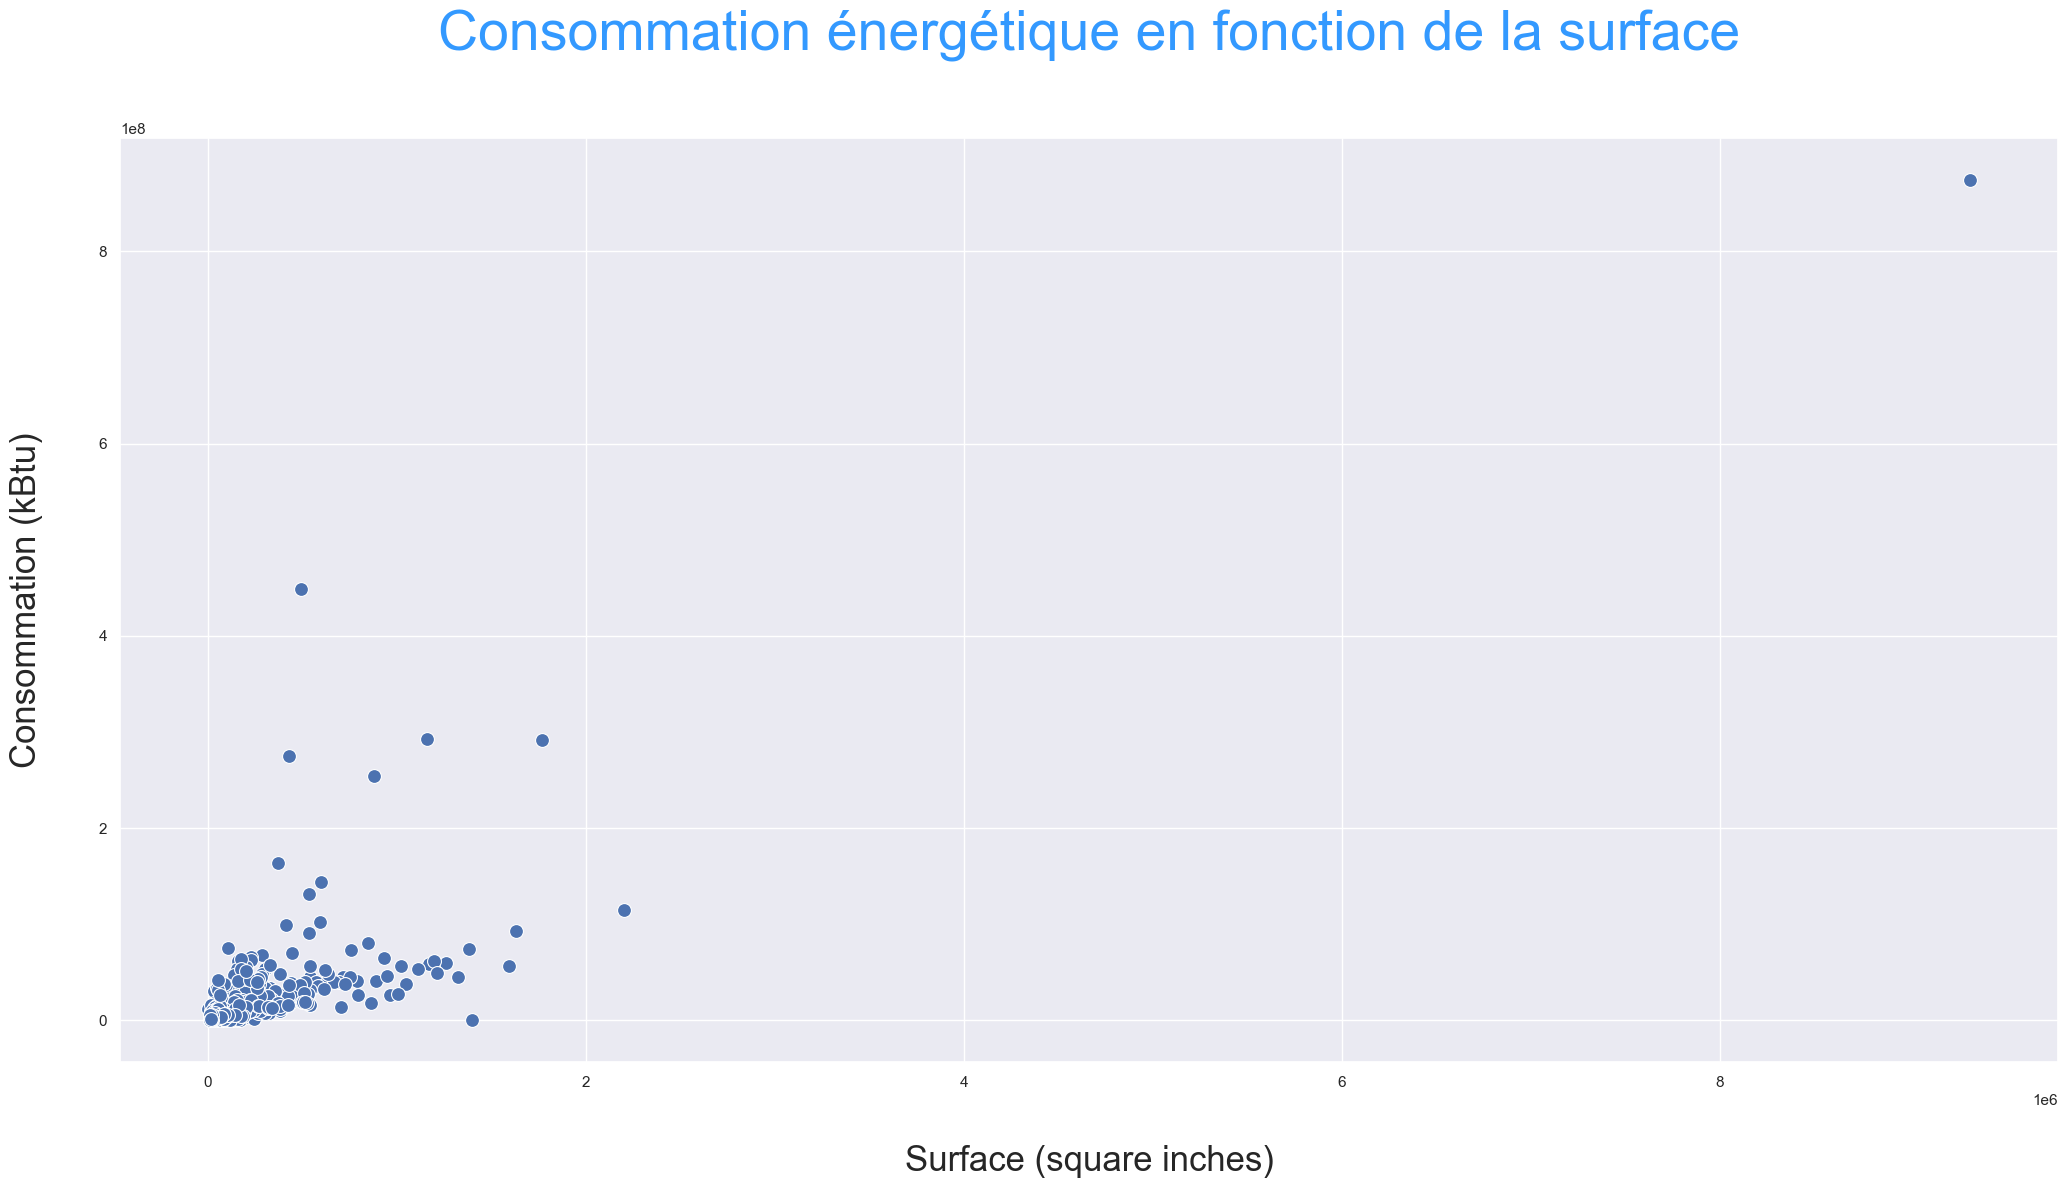

In [ ]:
# Pour comparaison : 

sns.scatterplot(no_outliers, x="PropertyGFABuilding(s)", y="SiteEnergyUse(kBtu)", s=100)
#plt.legend(title='Non outliers', fontsize=25, loc='upper left')
plt.xlabel('Surface (square inches)', fontsize=25, labelpad=40)
plt.ylabel('Consommation (kBtu)', fontsize=25, labelpad=40)

plt.title('Consommation énergétique en fonction de la surface', fontsize=40, y=1.05, color='#39f')
plt.show()


In [ ]:
# On peut s'étonner que certains points soient considérés comme outliers, et inversement


### 3.4 distribution empirique outliers

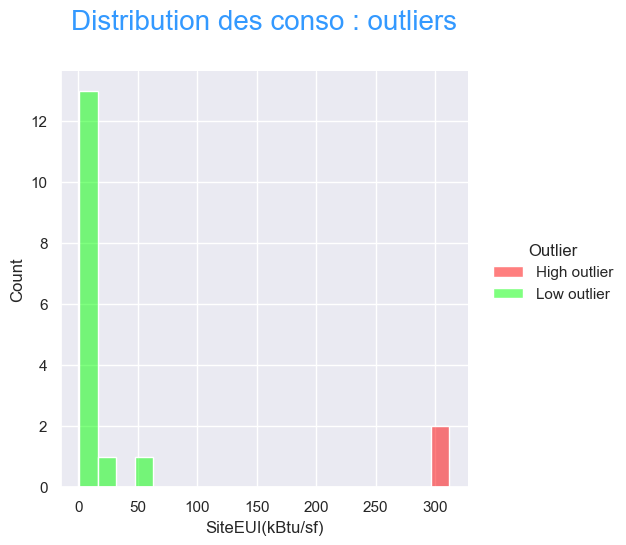

In [ ]:
sns.displot(outliers, x="SiteEUI(kBtu/sf)", hue="Outlier", palette=palette, bins=20)

#plt.xlabel('Surface (square inches)', fontsize=15, labelpad=20)
#plt.ylabel('Consommation (kBtu)', fontsize=15, labelpad=20)

plt.title('Distribution des conso : outliers', fontsize=20, color='#39f')
plt.show()


### 3.5 distribution empirique dans le cas général

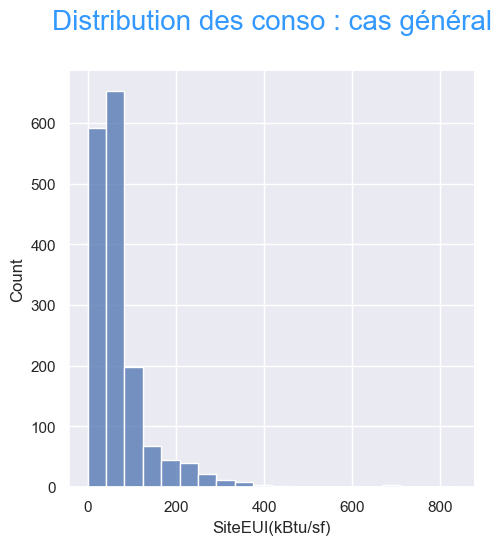

In [ ]:
sns.displot(no_outliers, x="SiteEUI(kBtu/sf)", bins=20)

plt.title('Distribution des conso : cas général', fontsize=20, color='#39f')
plt.show()


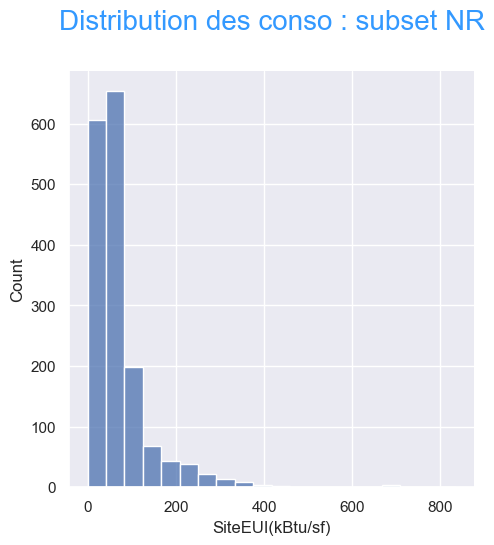

In [ ]:
sns.displot(subset_NR, x="SiteEUI(kBtu/sf)", bins=20)

plt.title('Distribution des conso : subset NR', fontsize=20, color='#39f')
plt.show()


In [ ]:
print(subset_NR.loc[subset_NR['SiteEUI(kBtu/sf)'] > 300, :].shape)

display(subset_NR.loc[subset_NR['SiteEUI(kBtu/sf)'] > 300, :].head(60))
# 1 seul outlier ??


(29, 44)


OSEBuildingID        BuildingType          PrimaryPropertyType  \
187             295      NonResidential                        Other   
240             365      NonResidential                        Other   
309             440      NonResidential           Mixed Use Property   
329             466      NonResidential                        Other   
474             637      NonResidential           Mixed Use Property   
517             704      NonResidential                 Large Office   
550             743      NonResidential                   Laboratory   
558             753      NonResidential                        Other   
601             803      NonResidential  Small- and Mid-Sized Office   
809           19900      NonResidential                   Laboratory   
1033          20565      NonResidential  Supermarket / Grocery Store   
1109          20885      NonResidential        Senior Care Community   
1279          21435      NonResidential                        Other   
1337          21549      NonResidential                   Laboratory   
1476          21921      NonResidential  Supermarket / Grocery Store   
1519          22230      NonResidential  Supermarket / Grocery Store   
1563          22479      NonResidential  Supermarket / Grocery Store   
1753          23310      NonResidential                        Other   
1817          23503      NonResidential                   Restaurant   
2109          24493      NonResidential  Supermarket / Grocery Store   
2380          25452      NonResidential           Mixed Use Property   
2514          25914      NonResidential  Supermarket / Grocery Store   
2522          25955      NonResidential                        Other   
2795          26986      NonResidential  Supermarket / Grocery Store   
2896          27378      NonResidential  Supermarket / Grocery Store   
3171          49709      NonResidential                        Other   
3203          49780      NonResidential                        Other   
3365          50208  Nonresidential COS                        Other   
3373          50224  Nonresidential COS                        Other   

                                           PropertyName  \
187                                        1122 3rd Ave   
240                                UW Tower Data Center   
309                        Fisher Plaza - West Building   
329   VM Seattle Hospital & Medical Center - Buck Pa...   
474                           Stadium Innovation Center   
517                                401 Elliott Ave West   
550   Dendreon Pharmaceuticals Inc. (Building Owner ...   
558                                      WestinBuilding   
601                                     200 SW Michigan   
809                                   3000/3018 Western   
1033                          Safeway 0368 - Queen Anne   
1109                                     Ballard Center   
1279                                       space needle   
1337                                    410 W. Harrison   
1476                             Safeway 0488 - 45th St   
1519                           BALLARD MARKET (ID22230)   
1563                               70500811 -- Interbay   
1753         Charles & Emma Frye Free Public Art Museum   
1817                   Salty's Waterfront Seafood Grill   
2109                                Metropolitan Market   
2380                             Chandler's Cove - SEDO   
2514                           Safeway 1551 - E John St   
2522                                Seattle Tennis Club   
2795                                            Admiral   
2896                       Safeway 1550 - Roosevelt Way   
3171                   Seattle ProCure Management, LLC.   
3203                       2020 Fifth Avenue Dat Center   
3365                                       Ballard Pool   
3373                                    Queen Anne Pool   

                        Address  ZipCode TaxParcelIdentificationNumber  \


### 3.6 Intensité de la consommation énergétique, selon les types de buildings

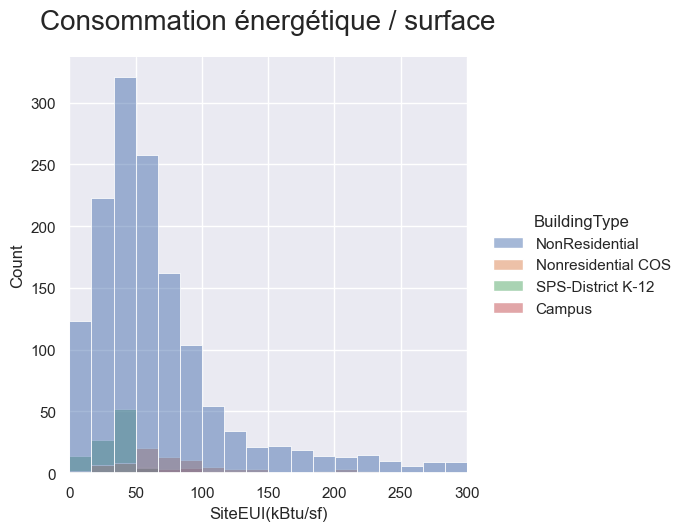

In [ ]:
# Je comprends pourquoi ces outliers st des outliers
# mais pourquoi slmt eux ??

sns.displot(no_outliers, x="SiteEUI(kBtu/sf)", color='#33f', bins=50, hue='BuildingType')
plt.xlim([-0, 300])
plt.xticks(np.arange(0, 350, step=50))

plt.title('Consommation énergétique / surface', fontsize=20, pad=20)
plt.show()


### 3.7 ComplianceStatus

In [ ]:
# "L’analyse des features « Outlier » et « ComplianceStatus » permet de supprimer des bâtiments contenant 
# des données considérées comme non pertinentes"

print(no_outliers['ComplianceStatus'].unique())

print(no_outliers.shape)
clean_subset = no_outliers.loc[no_outliers['ComplianceStatus'] == 'Compliant', :].copy()
print(clean_subset.shape)

# Une centaine d'individus


['Compliant' 'Error - Correct Default Data' 'Missing Data' 'Non-Compliant']
(1651, 44)
(1548, 44)


### 3.8 Valeurs incohérentes entres features

In [ ]:
# " L’analyse des features numériques permet de retraiter ou supprimer certains bâtiments ayant 
# des valeurs à 0 ou des valeurs incohérentes entres features (valeurs de consommation, surfaces par exemple)"

clean_subset['energy_test'] = clean_subset['SteamUse(kBtu)'] + clean_subset['Electricity(kBtu)'] \
    + clean_subset['NaturalGas(kBtu)'] - clean_subset['SiteEnergyUse(kBtu)']

clean_subset['energy_test'].describe()

# Still not ok


count    1.548000e+03
mean    -1.297381e+05
std      3.450572e+06
min     -1.318641e+08
25%     -1.000000e+00
50%     -3.130000e-01
75%      0.000000e+00
max      1.109896e+06
Name: energy_test, dtype: float64

In [ ]:
shape_head(clean_subset.loc[clean_subset['energy_test'].abs() > 10, :], 36)

# down to 36
# drop ?


(36, 44)


OSEBuildingID        BuildingType          PrimaryPropertyType  \
35               43              Campus           Mixed Use Property   
69              103  Nonresidential COS                        Other   
70              104  Nonresidential COS                        Other   
71              106  Nonresidential COS                        Other   
73              110  Nonresidential COS                        Other   
75              112  Nonresidential COS                        Other   
98              147      NonResidential                     Hospital   
124             198      NonResidential                     Hospital   
170             276      NonResidential                     Hospital   
206             328      NonResidential                 Large Office   
309             440      NonResidential           Mixed Use Property   
329             466      NonResidential                        Other   
371             523      NonResidential                 Large Office   
403             561      NonResidential                 Large Office   
513             700      NonResidential  Supermarket / Grocery Store   
558             753      NonResidential                        Other   
559             775      NonResidential                 Large Office   
563             757      NonResidential                 Large Office   
601             803      NonResidential  Small- and Mid-Sized Office   
618             828      NonResidential                     Hospital   
1105          20868      NonResidential                 Large Office   
1280          21436  Nonresidential COS                        Other   
1291          21464  Nonresidential COS                        Other   
1292          21465  Nonresidential COS                        Other   
2037          24216      NonResidential  Small- and Mid-Sized Office   
2441          25661      NonResidential  Small- and Mid-Sized Office   
2761          26849      NonResidential                 Retail Store   
2791          26973      NonResidential           Mixed Use Property   
3182          49725      NonResidential                        Other   
3206          49784      NonResidential  Small- and Mid-Sized Office   
3230          49850      NonResidential                  K-12 School   
3264          49940      NonResidential                     Hospital   
3270          49958  Nonresidential COS                        Other   
3274          49967              Campus                   University   
3275          49968      NonResidential                   University   
3277          49972      NonResidential                   University   

                                           PropertyName  \
35                                         Plant 2 Site   
69                                            Key Arena   
70                                Bagley Wright Theatre   
71                                               Armory   
73                                      Exhibition Hall   
75                                           McCaw Hall   
98                                      Swedish Ballard   
124             Seattle Children's Hospital Main Campus   
170                           Harborview Medical Center   
206                                        1600 Seventh   
309                        Fisher Plaza - West Building   
329   VM Seattle Hospital & Medical Center - Buck Pa...   
371                                       Adobe Seattle   
403                                             Alley24   
513                           IUC- Whole Foods Interbay   
558                                      WestinBuilding   
559                              Columbia Center - 2015   
563             Market Place I & II-2003 Western Avenue   
601                                     200 SW Michigan   
618                                  Swedish First Hill   
1105                                           Stone 34   
1280                         Seattle Childr

## 4 Feature engineering

### 4.1 Créations des variables structurelles

In [ ]:
clean_subset['proportion_electricity'] = round(clean_subset['Electricity(kBtu)'] \
    / clean_subset['SiteEnergyUse(kBtu)'], 6)

clean_subset['proportion_gaz'] = round(clean_subset['NaturalGas(kBtu)'] \
    / clean_subset['SiteEnergyUse(kBtu)'], 6)

clean_subset['proportion_steam'] = round(clean_subset['SteamUse(kBtu)'] \
    / clean_subset['SiteEnergyUse(kBtu)'], 6)

# idem proportion parking ?
# convertir PropertyGFAParking -> donnée structurelle ?

clean_subset['proportion_parking'] = round(clean_subset['PropertyGFAParking'] \
    / clean_subset['PropertyGFATotal'], 6)


### 4.2 Sélection des features

In [ ]:
chosen_features1 = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', \
                    'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                    'proportion_parking', 'proportion_electricity', 'proportion_gaz', 'proportion_steam', \
                    'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

data1 = clean_subset[chosen_features1].copy()

print(data1.shape)
display(data1.head(10))

display(data1.info())


(1548, 15)


BuildingType PrimaryPropertyType Neighborhood  YearBuilt  \
0       NonResidential               Hotel     DOWNTOWN       1927   
1       NonResidential               Hotel     DOWNTOWN       1996   
2       NonResidential               Hotel     DOWNTOWN       1969   
3       NonResidential               Hotel     DOWNTOWN       1926   
4       NonResidential               Hotel     DOWNTOWN       1980   
5   Nonresidential COS               Other     DOWNTOWN       1999   
6       NonResidential               Hotel     DOWNTOWN       1926   
7       NonResidential               Other     DOWNTOWN       1926   
8       NonResidential               Hotel     DOWNTOWN       1904   
10      NonResidential               Hotel     DOWNTOWN       1969   

    NumberofBuildings  NumberofFloors  PropertyGFATotal  proportion_parking  \
0                 1.0              12             88434            0.000000   
1                 1.0              11            103566            0.145453   
2                 1.0              41            956110            0.205748   
3                 1.0              10             61320            0.000000   
4                 1.0              18            175580            0.353115   
5                 1.0               2             97288            0.382349   
6                 1.0              11             83008            0.000000   
7                 1.0               8            102761            0.000000   
8                 1.0              15            163984            0.000000   
10                1.0              11            153163            0.125872   

    proportion_electricity  proportion_gaz  proportion_steam  \
0                 0.546060        0.176638          0.277302   
1                 0.386609        0.613391          0.000000   
2                 0.682307        0.020579          0.297113   
3                 0.407519        0.266567          0.325913   
4                 0.378802        0.621198          0.000000   
5                 0.609884        0.390116          0.000000   
6                 0.488160        0.511840          0.000000   
7                 0.577418        0.061159          0.361423   
8                 0.531770        0.468230          0.000000   
10                0.386325        0.286692          0.326983   

    SiteEnergyUse(kBtu)  SiteEUI(kBtu/sf)  TotalGHGEmissions  \
0             7226362.5         81.699997             249.98   
1             8387933.0         94.800003             295.86   
2            72587024.0         96.000000            2089.28   
3             6794584.0        110.800003             286.43   
4            14172606.0        114.800003             505.01   
5            12086616.0        136.100006             301.81   
6             5758795.0         70.800003             176.14   
7             6298131.5         61.299999             221.51   
8            13723820.0         83.699997             392.16   
10           16016644.0        119.599998             691.26   

    GHGEmissionsIntensity  
0                    2.83  
1                    2.86  
2                    2.19  
3                    4.67  
4                    2.88  
5                    3.10  
6                    2.12  
7                    2.16  
8                    2.39  
10                   4.51

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548 entries, 0 to 3375
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BuildingType            1548 non-null   object 
 1   PrimaryPropertyType     1548 non-null   object 
 2   Neighborhood            1548 non-null   object 
 3   YearBuilt               1548 non-null   int64  
 4   NumberofBuildings       1548 non-null   float64
 5   NumberofFloors          1548 non-null   int64  
 6   PropertyGFATotal        1548 non-null   int64  
 7   proportion_parking      1548 non-null   float64
 8   proportion_electricity  1548 non-null   float64
 9   proportion_gaz          1548 non-null   float64
 10  proportion_steam        1548 non-null   float64
 11  SiteEnergyUse(kBtu)     1548 non-null   float64
 12  SiteEUI(kBtu/sf)        1548 non-null   float64
 13  TotalGHGEmissions       1548 non-null   float64
 14  GHGEmissionsIntensity   1548 non-null   

None

### 4.3 Premier export

In [ ]:
data1.to_csv('clean_data1.csv', sep=',', index=False)

print(data1['SiteEnergyUse(kBtu)'].min())
print(data1['SiteEUI(kBtu/sf)'].min(), '\n')

print(data1['TotalGHGEmissions'].min())
print(data1['GHGEmissionsIntensity'].min(), '\n')


57133.19922
1.399999976 

-0.8
-0.02 



In [ ]:
# Plus une seule valeur manquante, parfait !

# Question : s'il y avait eu des VM dans des variables catégoriques,
# vaut-il mieux traiter (supression, imputation par le mode, ...)
# ou encoder une valeur supplémentaire ? (+ simple mais augmente encore + la dimensionalité
# donc modèles + lents, possible tendance à overfitter, ...)


### 4.4 Sur l'encodage des variables catégoriques

In [ ]:
# train / test split d'abord 
# no leakage here, bijection entre espace label et espace 

# Nous avons 3 variables catégoriques à encoder...
# ce qui va créer une cinquantaine de nouvelles variables !
# drop first ? dont see why not

# Ici on pourrait procéder à l'encodage en une seule ligne

# ascategorical first ?
pandas_encoded_df = pd.get_dummies(data1)

shape_head(pandas_encoded_df)


(1548, 55)


YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0       1927                1.0              12             88434   
1       1996                1.0              11            103566   
2       1969                1.0              41            956110   
3       1926                1.0              10             61320   
4       1980                1.0              18            175580   

   proportion_parking  proportion_electricity  proportion_gaz  \
0            0.000000                0.546060        0.176638   
1            0.145453                0.386609        0.613391   
2            0.205748                0.682307        0.020579   
3            0.000000                0.407519        0.266567   
4            0.353115                0.378802        0.621198   

   proportion_steam  SiteEnergyUse(kBtu)  SiteEUI(kBtu/sf)  TotalGHGEmissions  \
0          0.277302            7226362.5         81.699997             249.98   
1          0.000000            8387933.0         94.800003             295.86   
2          0.297113           72587024.0         96.000000            2089.28   
3          0.325913            6794584.0        110.800003             286.43   
4          0.000000           14172606.0        114.800003             505.01   

   GHGEmissionsIntensity  BuildingType_Campus  BuildingType_NonResidential  \
0                   2.83                    0                            1   
1                   2.86                    0                            1   
2                   2.19                    0                            1   
3                   4.67                    0                            1   
4                   2.88                    0                            1   

   BuildingType_Nonresidential COS  BuildingType_SPS-District K-12  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   PrimaryPropertyType_Distribution Center  PrimaryPropertyType_Hospital  \
0                                        0                             0   
1                                        0                             0   
2                                        0                             0   
3                                        0                             0   
4                                        0                             0   

   PrimaryPropertyType_Hotel  PrimaryPropertyType_K-12 School  \
0                          1                                0   
1                          1                                0   
2                          1                                0   
3                          1                                0   
4                          1                                0   

   PrimaryPropertyType_Laboratory  PrimaryPropertyType_Large Office  \
0                               0                                 0   
1                               0                                 0   
2                               0                                 0   
3                               0                                 0   
4                               0                                 0   

   PrimaryPropertyType_Low-Rise Multifamily  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   PrimaryPropertyType_Medical Office  PrimaryPropertyType_Mixed Use Property  \
0                                   0                                       0   
1                                   0                                       0   
2                  

In [ ]:
# Nous allons plutôt utiliser ohe
# + souple / gestion des erreurs possibles (ex: unknomn categ)
# compatible pipelines 

# Voir notebook 2


### 4.5 Améliorations : diminuer la dimension ?

In [ ]:
# En remplaçant neighborhood (devient 18-19 features après one hot encoding)
# par latitude et longitude : 

chosen_features2 = ['BuildingType', 'PrimaryPropertyType', \
                    'Latitude', 'Longitude', \
                    'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', \
                    'proportion_parking', 'proportion_electricity', 'proportion_gaz', 'proportion_steam', \
                    'SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

data2 = clean_subset[chosen_features2].copy()

print(data2.shape)

data2.to_csv('clean_data2_coordinates.csv', sep=',', index=False)

# En gardant les 2 :
data3 = clean_subset[chosen_features1 + ['Latitude', 'Longitude']].copy()
data3.to_csv('clean_data3_both.csv', sep=',', index=False)



(1548, 16)


### 4.6 Améliorations : usetypes

In [ ]:
# L’amélioration à privilégier est l’utilisation des features « LargestPropertyUseType » / 
# « SecondLargestPropertyUseType » / « ThirdLargestPropertyUseType », et les GFA associées. 
# Le principe est de réaliser une sorte de OneHotEncoding manuellement, en calculant la proportion de surface 
# des différents PropertyUseType de chaque bâtiment (par exemple hôtel=80%, restaurant=15%, parking=5%).

print(clean_subset['PrimaryPropertyType'].nunique())
print(clean_subset['LargestPropertyUseType'].nunique())
print(clean_subset['SecondLargestPropertyUseType'].nunique())
print(clean_subset['ThirdLargestPropertyUseType'].nunique(), '\n')
# Messy !

# Assurons-nous d'avoir ttes les valeurs possibles
list_all_usetypes = list(set(clean_subset['LargestPropertyUseType'].unique().tolist() \
                             + clean_subset['SecondLargestPropertyUseType'].unique().tolist() \
                             + clean_subset['ThirdLargestPropertyUseType'].unique().tolist()))

print(len(list_all_usetypes))
print(list_all_usetypes)
# Remove the nan value from the list
list_all_usetypes = [x for x in list_all_usetypes if not (isinstance(x, float) and np.isnan(x))]
print(len(list_all_usetypes))
print(list_all_usetypes)

# Vérifions aussi...
print(clean_subset.loc[(clean_subset['LargestPropertyUseType'] == clean_subset['SecondLargestPropertyUseType']) 
                         | (clean_subset['LargestPropertyUseType'] == clean_subset['ThirdLargestPropertyUseType'])
                         | (clean_subset['SecondLargestPropertyUseType'] == clean_subset['ThirdLargestPropertyUseType']), :].shape)

display(clean_subset.loc[(clean_subset['LargestPropertyUseType'] == clean_subset['SecondLargestPropertyUseType']) 
                         | (clean_subset['LargestPropertyUseType'] == clean_subset['ThirdLargestPropertyUseType'])
                         | (clean_subset['SecondLargestPropertyUseType'] == clean_subset['ThirdLargestPropertyUseType']), :])

# 4 ont des doublons, attention à la formule
# Les deux premiers n'ont pas besoin d'être corrigés.
# Les 2 suivants, ont peut les corriger...
# ou tricher avec notre formule


21
55
47
39 

64
['Social/Meeting Hall', 'Library', 'Convenience Store without Gas Station', 'Food Sales', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Residential Care Facility', 'Other - Utility', 'Other - Recreation', 'Movie Theater', 'Strip Mall', 'Courthouse', 'Other - Education', 'Lifestyle Center', 'Other', 'Multifamily Housing', 'Distribution Center', 'Laboratory', 'Urgent Care/Clinic/Other Outpatient', 'Pre-school/Daycare', 'Prison/Incarceration', 'Residence Hall/Dormitory', 'Enclosed Mall', 'Fast Food Restaurant', 'Other - Entertainment/Public Assembly', 'Other - Mall', 'Automobile Dealership', 'Museum', 'Refrigerated Warehouse', 'Senior Care Community', 'Manufacturing/Industrial Plant', 'Fire Station', 'Parking', 'Vocational School', 'Hotel', 'Wholesale Club/Supercenter', 'Restaurant', 'Supermarket/Grocery Store', 'Other - Services', 'Other/Specialty Hospital', 'Medical Office', 'Non-Refrigerated Warehouse', 'Fitness Center/Health Club/Gym', 'K-12 School', 'Bank Branc

OSEBuildingID    BuildingType          PrimaryPropertyType  \
356             500  NonResidential  Supermarket / Grocery Store   
542             732  NonResidential  Supermarket / Grocery Store   
594             796  NonResidential                 Large Office   
3132          40034  NonResidential  Small- and Mid-Sized Office   

            PropertyName                 Address  ZipCode  \
356   70100179-Lake City  13000 Lake City Way NE  98125.0   
542   70100122-Greenwood      100 NW 85th Street  98117.0   
594        6100 Building          6100 4th Ave S  98108.0   
3132       Sandpoint #29         6200 NE 74th ST  98115.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode      Neighborhood  \
356                     1453601660                    5             NORTH   
542                     9231900160                    6         NORTHWEST   
594                     5367200610                    2  GREATER DUWAMISH   
3132                    0225049077                    4         NORTHEAST   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
356   47.72370 -122.29232       1995                1.0               2   
542   47.69197 -122.35877       1970                1.0               1   
594   47.54699 -122.32882       1975                1.0               5   
3132  47.68254 -122.26299       1960                1.0               0   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
356             308965              187878                  121087   
542             141890               35545                  106345   
594             238148                   0                  238148   
3132             21931                   0                   21931   

               ListOfAllPropertyUseTypes     LargestPropertyUseType  \
356   Parking, Supermarket/Grocery Store  Supermarket/Grocery Store   
542   Parking, Supermarket/Grocery Store  Supermarket/Grocery Store   
594                      Office, Parking                     Office   
3132                              Office                     Office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
356                    121087.0                      Parking   
542                    168735.0                      Parking   
594                    245240.0                      Parking   
3132                    31845.0                       Office   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
356                               0.0                     Parking   
542                               0.0                     Parking   
594                            5616.0                     Parking   
3132                          31845.0                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
356                              0.0                      NaN   
542                              0.0                      NaN   
594                           5616.0                      NaN   
3132                             NaN                      NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
356              78.0        119.900002          122.599998   
542              91.0        100.000000          103.000000   
594              93.0         43.900002           43.900002   
3132             32.0        124.000000          134.800003   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
356           310.200012            310.899994          14512786.00   
542           266.600006            269.799988          16865978.00   
594           138.000000            138.000000          10775646.00   
3132          221.899994            233.300003           3947209.25   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
356              14843382.0             0.0         3130371.0   
542              17384564.0             0.0         3825269.5   
594              10775646.0   

In [ ]:
for usetype in list_all_usetypes:
    clean_subset[usetype] = 0
    # clean_subset.loc[clean_subset['LargestPropertyUseType'] == usetype, usetype] = clean_subset[usetype] + clean_subset['LargestPropertyUseTypeGFA'] / clean_subset['PropertyGFATotal']
    # serait la formule correcte, mais pour corriger le probleme des doublons :
    clean_subset.loc[clean_subset['LargestPropertyUseType'] == usetype, usetype] = clean_subset['LargestPropertyUseTypeGFA'] / clean_subset['PropertyGFATotal']
    clean_subset.loc[clean_subset['SecondLargestPropertyUseType'] == usetype, usetype] = clean_subset['SecondLargestPropertyUseTypeGFA'] / clean_subset['PropertyGFATotal']
    clean_subset.loc[clean_subset['ThirdLargestPropertyUseType'] == usetype, usetype] = clean_subset['ThirdLargestPropertyUseTypeGFA'] / clean_subset['PropertyGFATotal']

display(clean_subset.head(20))


OSEBuildingID        BuildingType PrimaryPropertyType  \
0               1      NonResidential               Hotel   
1               2      NonResidential               Hotel   
2               3      NonResidential               Hotel   
3               5      NonResidential               Hotel   
4               8      NonResidential               Hotel   
5               9  Nonresidential COS               Other   
6              10      NonResidential               Hotel   
7              11      NonResidential               Other   
8              12      NonResidential               Hotel   
10             15      NonResidential               Hotel   
11             16      NonResidential               Hotel   
12             17      NonResidential               Hotel   
13             18      NonResidential               Hotel   
14             19      NonResidential               Hotel   
15             21  Nonresidential COS               Other   
16             22      NonResidential               Other   
17             23      NonResidential               Hotel   
18             24      NonResidential  Mixed Use Property   
19             25      NonResidential               Hotel   
20             26      NonResidential               Other   

                                    PropertyName             Address  ZipCode  \
0                           Mayflower park hotel       405 Olive way  98101.0   
1                                Paramount Hotel     724 Pine street  98101.0   
2                        5673-The Westin Seattle     1900 5th Avenue  98101.0   
3                                      HOTEL MAX      620 STEWART ST  98101.0   
4                    WARWICK SEATTLE HOTEL (ID8)       401 LENORA ST  98121.0   
5                                  West Precinct     810 Virginia St  98101.0   
6                                         Camlin     1619 9th Avenue  98101.0   
7                              Paramount Theatre         911 Pine St  98101.0   
8                           311wh-Pioneer Square         612 2nd Ave  98104.0   
10                          Hotel Monaco Seattle     1101 4th Avenue  98101.0   
11                                5679-W Seattle  1112 Fourth Avenue  98101.0   
12                       Executive Pacific Plaza   400 Spring Street  98104.0   
13                    Crowne Plaza Hotel Seattle        1113 6th Ave  98101.0   
14                         Hotel Vintage Seattle     1100 5th Avenue  98101.0   
15  The Seattle Public Library - Central Library  1000 Fourth Avenue  98154.0   
16                         Downtown Seattle YMCA      909 4th Avenue  98104.0   
17                     Renaissance Seattle Hotel  515 Madison Street  98104.0   
18                              The Rainier Club        820 4th Ave.  98104.0   
19                           Arctic Club Seattle         700 3rd Ave  98104.0   
20                        King County Courthouse         516 3RD AVE  98104.0   

   TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                     0659000030                    7     DOWNTOWN  47.61220   
1                     0659000220                    7     DOWNTOWN  47.61317   
2                     0659000475                    7     DOWNTOWN  47.61393   
3                     0659000640                    7     DOWNTOWN  47.61412   
4                     0659000970                    7     DOWNTOWN  47.61375   
5                     0660000560                    7     DOWNTOWN  47.61623   
6                     0660000825                    7     DOWNTOWN  47.61390   
7                     0660000955                    7     DOWNTOWN  47.61327   
8                     0939000080                    7     DOWNTOWN  47.60294   
10                    0942000145                    7     DOWNTOWN  47.60695   
11                    0942000165                    7     DOWNTOWN  47.60713   
12                    0942000210                    7     DO

In [ ]:
column_names = clean_subset.columns.values.tolist()
print(column_names)

# clean_subset.rename(columns={None: 'Unknown_use'})
display(clean_subset.head(1))

# Pour ces features de type PropertyUseType, il peut être intéressant de regrouper des valeurs 
# afin d’avoir suffisamment de bâtiments par valeur et ainsi améliorer la performance des modèles 
# et leur stabilité

get_non_null_values(clean_subset)


['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName', 'Address', 'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'energy_test', 'quotient_elec', 'proportion_electricity', 'proportion_gaz', 'proportion_steam', 

OSEBuildingID    BuildingType PrimaryPropertyType          PropertyName  \
0              1  NonResidential               Hotel  Mayflower park hotel   

         Address  ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
0  405 Olive way  98101.0                    0659000030                    7   

  Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  \
0     DOWNTOWN   47.6122 -122.33799       1927                1.0   

   NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
0              12             88434                   0   

   PropertyGFABuilding(s) ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                   88434                     Hotel                  Hotel   

   LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
0                    88434.0                          NaN   

   SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
0                              NaN                         NaN   

   ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
0                             NaN                      NaN             60.0   

   SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
0         81.699997           84.300003               182.5   

   SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0                 189.0            7226362.5              7456910.0   

   SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
0       2003882.0        1156514.25          3946027.0          12764.5293   

   NaturalGas(kBtu)  DefaultData ComplianceStatus Outlier  TotalGHGEmissions  \
0         1276453.0        False        Compliant     NaN             249.98   

   GHGEmissionsIntensity  energy_test  quotient_elec  proportion_electricity  \
0                   2.83         -0.5          3.412                 0.54606   

   proportion_gaz  proportion_steam  proportion_parking  Social/Meeting Hall  \
0        0.176638          0.277302                 0.0                  0.0   

   Library  Convenience Store without Gas Station  Food Sales  \
0      0.0                                    0.0         0.0   

   Repair Services (Vehicle, Shoe, Locksmith, etc)  Residential Care Facility  \
0                                              0.0                          0   

   Other - Utility  Other - Recreation  Movie Theater  Strip Mall  Courthouse  \
0              0.0                 0.0            0.0         0.0         0.0   

   Other - Education  Lifestyle Center  Other  Multifamily Housing  \
0                0.0               0.0    0.0                  0.0   

   Distribution Center  Laboratory  Urgent Care/Clinic/Other Outpatient  \
0                  0.0         0.0                                    0   

   Pre-school/Daycare  Prison/Incarceration  Residence Hall/Dormitory  \
0                 0.0                     0                       0.0   

   Enclosed Mall  Fast Food Restaurant  Other - Entertainment/Public Assembly  \
0            0.0                   0.0                                    0.0   

   Other - Mall  Automobile Dealership  Museum  Refrigerated Warehouse  \
0           0.0                    0.0     0.0                     0.0   

   Senior Care Community  Manufacturing/Industrial Plant  Fire Station  \
0                    0.0                             0.0           0.0   

   Parking  Vocational School  Hotel  Wholesale Club/Supercenter  Restaurant  \
0      0.0                0.0    1.0                           0         0.0   

   Supermarket/Grocery Store  Other - Services  Other/Specialty Hospital  \
0                        0.0               0.0                       0.0   

   Medical Office  Non-Refrigerated Warehouse  Fitness Center/Health Club/Gym  \
0             0.0                         0.0                             0.0   

   K-12 School  Bank Branch  Food Service  Adult Education  \
0          0.0          0.0           0.0        

column_name  non_null_count  percent_non_null  \
DefaultData                    DefaultData               0              0.00   
Swimming Pool                Swimming Pool               0              0.00   
Enclosed Mall                Enclosed Mall               1              0.06   
Police Station              Police Station               1              0.06   
Fast Food Restaurant  Fast Food Restaurant               1              0.06   
...                                    ...             ...               ...   
Longitude                        Longitude            1548            100.00   
YearBuilt                        YearBuilt            1548            100.00   
PropertyGFATotal          PropertyGFATotal            1548            100.00   
Latitude                          Latitude            1548            100.00   
quotient_elec                quotient_elec            1548            100.00   

                         type  
DefaultData              bool  
Swimming Pool           int64  
Enclosed Mall         float64  
Police Station        float64  
Fast Food Restaurant  float64  
...                       ...  
Longitude             float64  
YearBuilt               int64  
PropertyGFATotal        int64  
Latitude              float64  
quotient_elec         float64  

[111 rows x 4 columns]

In [ ]:
with pd.option_context('display.max_rows', 1000):
    display(get_non_null_values(clean_subset[list_all_usetypes]))
    

column_name  \
Swimming Pool                                                                           Swimming Pool   
Residential Care Facility                                                   Residential Care Facility   
Enclosed Mall                                                                           Enclosed Mall   
Fire Station                                                                             Fire Station   
Wholesale Club/Supercenter                                                 Wholesale Club/Supercenter   
Police Station                                                                         Police Station   
Fast Food Restaurant                                                             Fast Food Restaurant   
Lifestyle Center                                                                     Lifestyle Center   
Vocational School                                                                   Vocational School   
Food Sales                                                                                 Food Sales   
Courthouse                                                                                 Courthouse   
Other - Technology/Science                                                 Other - Technology/Science   
Prison/Incarceration                                                             Prison/Incarceration   
Convenience Store without Gas Station                           Convenience Store without Gas Station   
Bar/Nightclub                                                                           Bar/Nightclub   
Other - Utility                                                                       Other - Utility   
Adult Education                                                                       Adult Education   
Personal Services (Health/Beauty, Dry Cleaning,...  Personal Services (Health/Beauty, Dry Cleaning...   
Urgent Care/Clinic/Other Outpatient                               Urgent Care/Clinic/Other Outpatient   
Other - Mall                                                                             Other - Mall   
Library                                                                                       Library   
Movie Theater                                                                           Movie Theater   
Other/Specialty Hospital                                                     Other/Specialty Hospital   
Other - Public Services                                                       Other - Public Services   
Museum                                                                                         Museum   
Performing Arts                                                                       Performing Arts   
Other - Lodging/Residential                                               Other - Lodging/Residential   
Other - Education                                                                   Other - Education   
Strip Mall                                                                                 Strip Mall   
Automobile Dealership                                                           Automobile Dealership   
Other - Restaurant/Bar                                                         Other - Restaurant/Bar   
Financial Office                                                                     Financial Office   
Food Service                                                                             Food Service   
Repair Services (Vehicle, Shoe, Locksmith, etc)       Repair Services (Vehicle, Shoe, Locksmith, etc)   
Manufacturing/Industrial Plant                                         Manufacturing/Industrial Plant   
Pre-school/Daycare                                                                 Pre-school/Daycare   
Hospital (General Medical & Surgical)                           Hospital (General Medical & Surgical)   
Bank Branch                                                                               Bank Branc

In [ ]:
# Disons qu'on veut au minimum 50 individus dans chaque classe

seuil_min = 50

variables_desertes = get_non_null_values(clean_subset[list_all_usetypes]).loc[get_non_null_values(clean_subset[list_all_usetypes])['non_null_count'] < seuil_min, 'column_name'].tolist()
print(variables_desertes)

clean_subset['grouped_usetypes'] = 0

for feature in variables_desertes:
    clean_subset['grouped_usetypes'] += clean_subset[feature]

display(clean_subset['grouped_usetypes'].describe())

print(clean_subset.loc[clean_subset['grouped_usetypes'] > 1.1, :].shape)
display(clean_subset.loc[clean_subset['grouped_usetypes'] > 1.1, :])

list_kept_usetypes = [ x for x in list_all_usetypes if x not in variables_desertes]
list_kept_usetypes.append('grouped_usetypes')

print(len(list_kept_usetypes))
print(list_kept_usetypes)


['Swimming Pool', 'Residential Care Facility', 'Enclosed Mall', 'Fire Station', 'Wholesale Club/Supercenter', 'Police Station', 'Fast Food Restaurant', 'Lifestyle Center', 'Vocational School', 'Food Sales', 'Courthouse', 'Other - Technology/Science', 'Prison/Incarceration', 'Convenience Store without Gas Station', 'Bar/Nightclub', 'Other - Utility', 'Adult Education', 'Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Urgent Care/Clinic/Other Outpatient', 'Other - Mall', 'Library', 'Movie Theater', 'Other/Specialty Hospital', 'Other - Public Services', 'Museum', 'Performing Arts', 'Other - Lodging/Residential', 'Other - Education', 'Strip Mall', 'Automobile Dealership', 'Other - Restaurant/Bar', 'Financial Office', 'Food Service', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Manufacturing/Industrial Plant', 'Pre-school/Daycare', 'Hospital (General Medical & Surgical)', 'Bank Branch', 'Refrigerated Warehouse', 'Other - Services', 'Social/Meeting Hall', 'Senior Care Communit

count    1548.000000
mean        0.199146
std         0.383788
min         0.000000
25%         0.000000
50%         0.000000
75%         0.122378
max         2.697535
Name: grouped_usetypes, dtype: float64

(25, 112)


OSEBuildingID        BuildingType     PrimaryPropertyType  \
35               43              Campus      Mixed Use Property   
59               84      NonResidential   Senior Care Community   
170             276      NonResidential                Hospital   
364             516      NonResidential                   Other   
373             525      NonResidential      Mixed Use Property   
463             624      NonResidential                   Other   
697           19654      NonResidential              Laboratory   
952           20323      NonResidential          Residence Hall   
992           20439      NonResidential                   Other   
1025          20532  Nonresidential COS                   Other   
1279          21435      NonResidential                   Other   
1606          22801  Nonresidential COS                   Other   
1634          22936  Nonresidential COS                   Other   
1672          23071      NonResidential                Hospital   
2166          24646  Nonresidential COS                   Other   
2482          25772      NonResidential                Hospital   
2784          26933  Nonresidential COS                   Other   
3019          27891      NonResidential                   Other   
3063          28029      NonResidential  Refrigerated Warehouse   
3110          33527      NonResidential              University   
3168          49705  Nonresidential COS                   Other   
3175          49715      NonResidential          Residence Hall   
3261          49926      NonResidential              University   
3264          49940      NonResidential                Hospital   
3294          50002      NonResidential                   Other   

                                PropertyName                          Address  \
35                              Plant 2 Site            7755 E MARGINAL WAY S   
59                          PSSA - The Mount                 4831 35th Ave SW   
170                Harborview Medical Center                     325 9th Ave.   
364                   Aurora Shopping Center        13201 Aurora Avenue North   
373                       Seattle Art Museum                  1300 1st Avenue   
463               South Occidental Warehouse            1900 Occidental Ave S   
697                           1100 Olive Lab                   1100 Olive Way   
952                Chancery Place Apartments                910 Marion Street   
992                 West Seattle Family YMCA                 4515 36th Ave SW   
1025                   Amy Yee Tennis Center           2000 M L King Jr Way S   
1279                            space needle                400 broard street   
1606       Meadowbrook Community Center/Pool                10700 30th Ave NE   
1634                Seattle Asian Art Museum                  1400 E Prospect   
1672               Main Hospital - All Wings  Facilities Management MS: B-120   
2166     Southwest Teen Life Center and Pool                  2801 Thistle St   
2482               Park West Skilled Nursing           1703 California Ave SW   
2784  Langston Hughes Performing Arts Center               104 17th Ave South   
3019                           University VW            4724 Roosevelt Way NE   
3063                        Plymouth Poultry                   4500 7th Ave S   
3110                  SCCC WOOD CONSTRUCTION                   2310 S LANE ST   
3168                                Magnuson           7400 Sand Point Way NE   
3175                                Elm Hall              1218 NE Campus Pkwy   
3261               SCCC MAIN BROADWAY/EDISON                    1701 BROADWAY   
3264    Virginia Mason Medical Center - 2149                   925 Seneca St.   
3294                   Audi Seattle UVA Bldg                 4741 11TH AVE NE   

      ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode  \
35    98108.0                    0022000005                    2   
59    98126.0       

13
['Other', 'Distribution Center', 'Parking', 'Hotel', 'Restaurant', 'Supermarket/Grocery Store', 'Medical Office', 'Non-Refrigerated Warehouse', 'K-12 School', 'Retail Store', 'Worship Facility', 'Office', 'grouped_usetypes']


In [ ]:
display(raw_df.loc[raw_df['OSEBuildingID'] == 43, :])

# ok. l'erreur était là dès le départ. Nettoyage ?

data4 = clean_subset[chosen_features1 + list_kept_usetypes].copy()

data4.to_csv('clean_data4_usetypes.csv', sep=',', index=False)


OSEBuildingID  DataYear BuildingType PrimaryPropertyType  PropertyName  \
35             43      2016       Campus  Mixed Use Property  Plant 2 Site   

                  Address     City State  ZipCode  \
35  7755 E MARGINAL WAY S  Seattle    WA  98108.0   

   TaxParcelIdentificationNumber  CouncilDistrictCode      Neighborhood  \
35                    0022000005                    2  GREATER DUWAMISH   

    Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
35  47.53493 -122.31788       1992                1.0               3   

    PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
35            494835                   0                  494835   

                            ListOfAllPropertyUseTypes LargestPropertyUseType  \
35  Energy/Power Station, Laboratory, Manufacturin...                 Office   

    LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
35                   757027.0                   Laboratory   

    SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
35                         639931.0  Non-Refrigerated Warehouse   

    ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  \
35                        459748.0                      NaN              8.0   

    SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
35        221.699997          233.100006          388.200012   

    SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
35            400.299988          448385312.0            471613856.0   

    SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
35             0.0        44102076.0        150476283.0           2979090.0   

    NaturalGas(kBtu)  DefaultData  Comments ComplianceStatus Outlier  \
35       297909000.0        False       NaN        Compliant     NaN   

    TotalGHGEmissions  GHGEmissionsIntensity  
35           16870.98                  34.09

### 4.7 Améliorations : correction de la skewness par passage au log(1 + x)

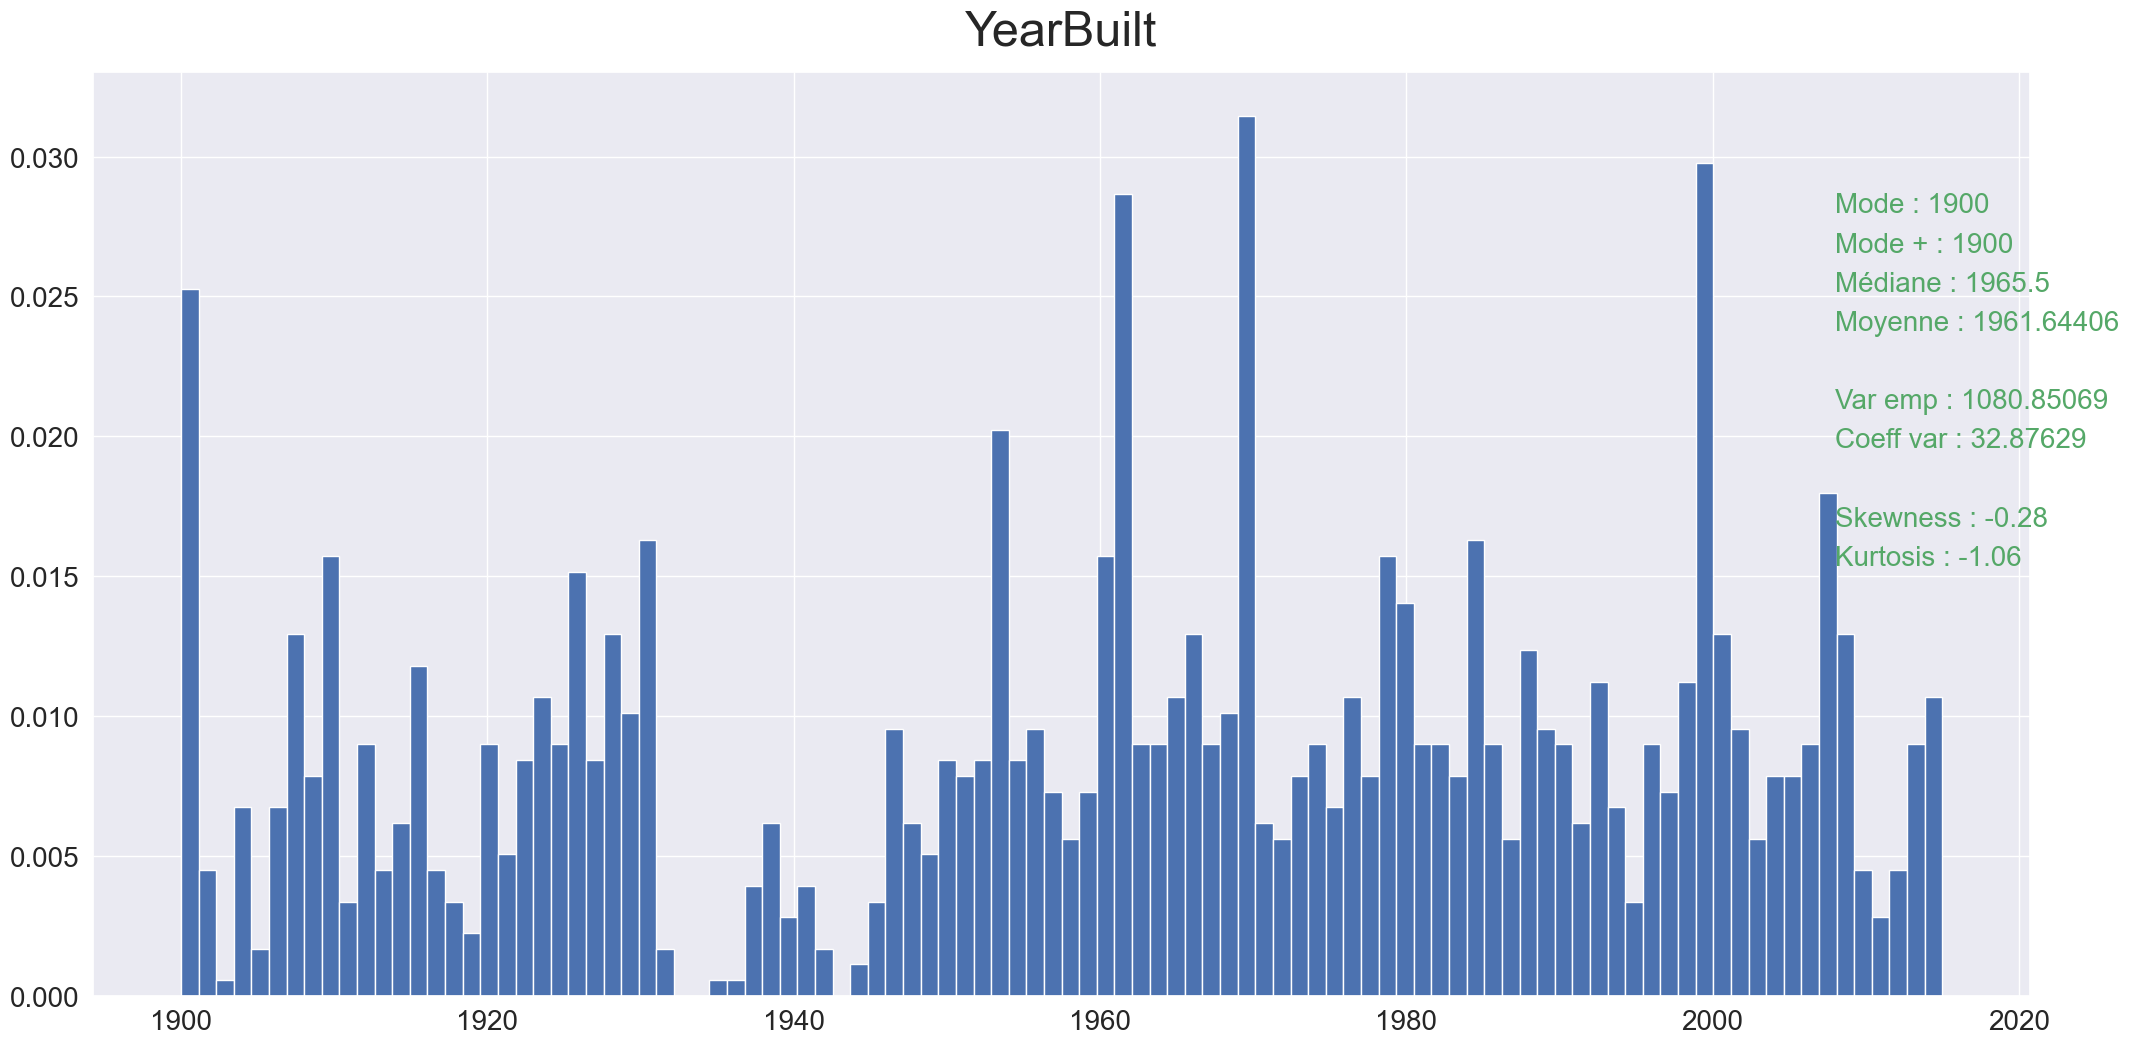

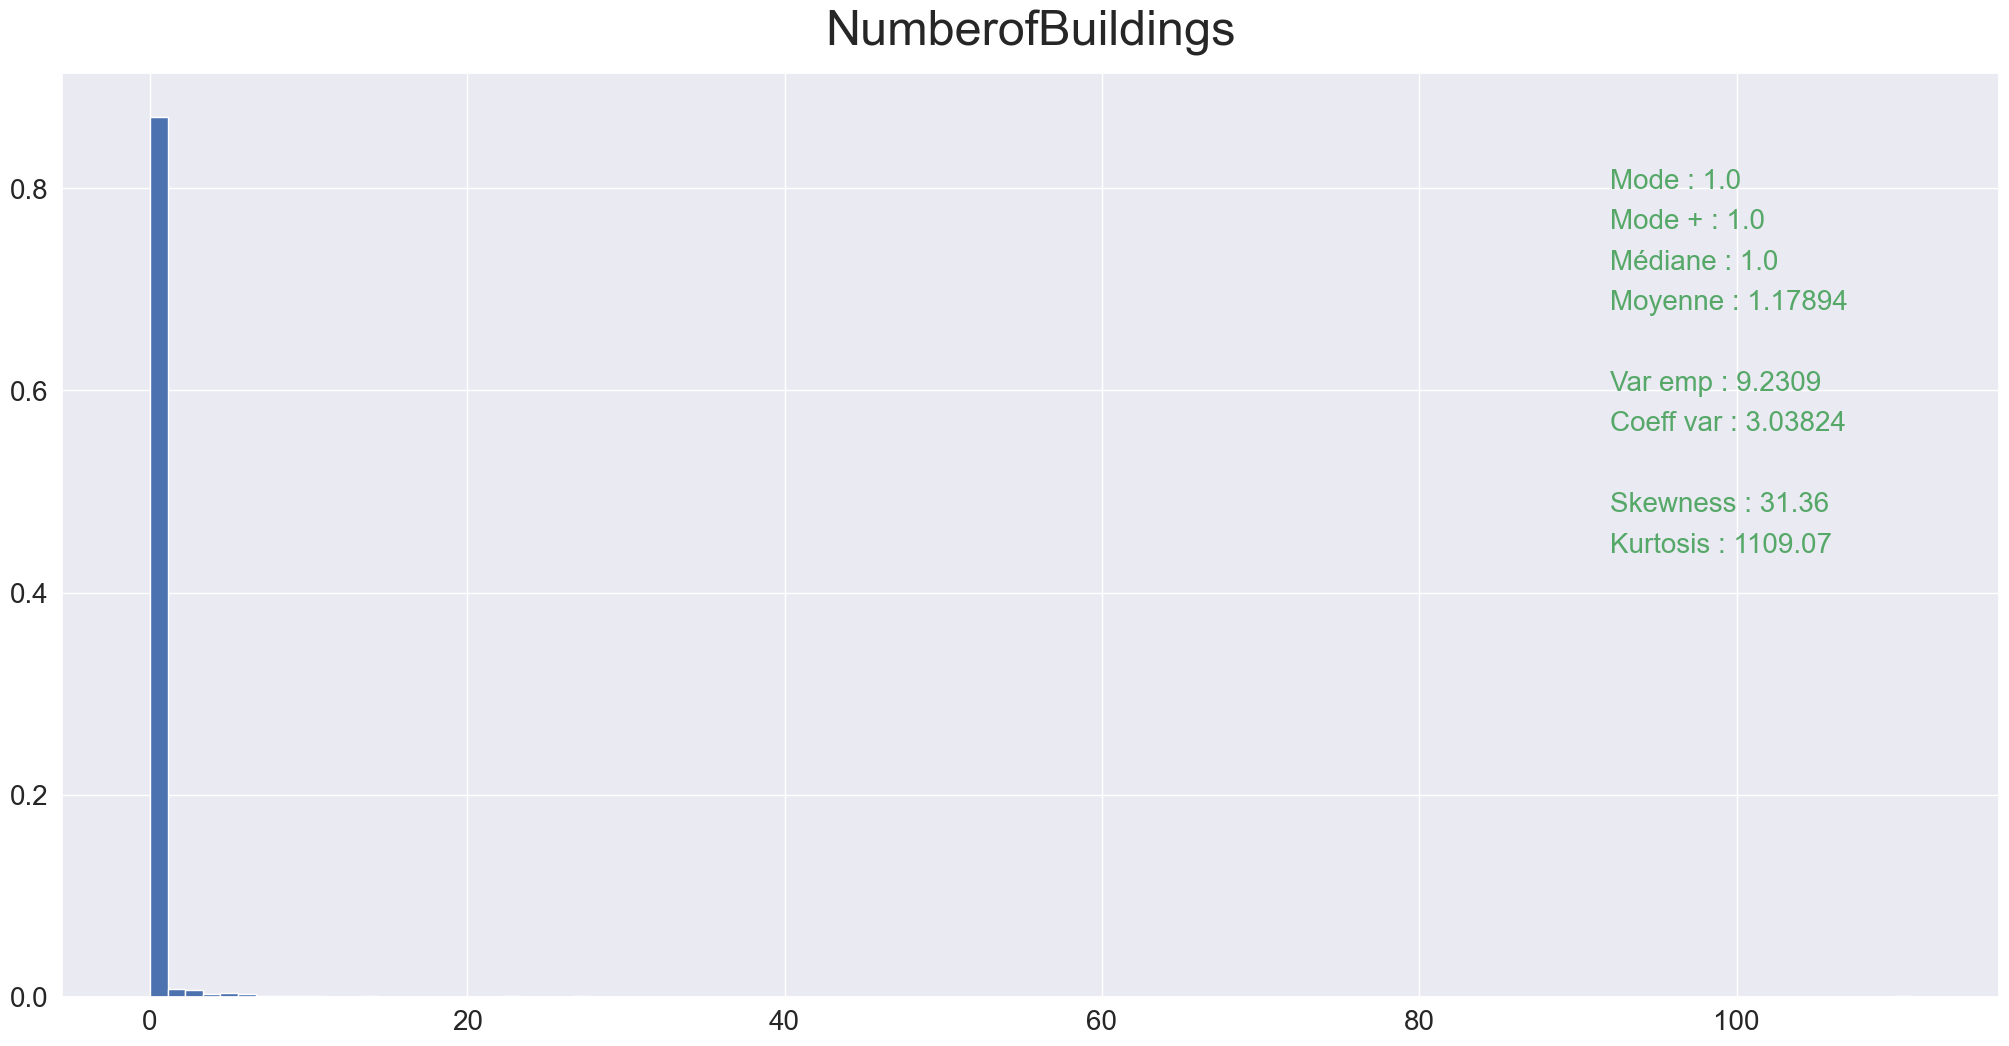

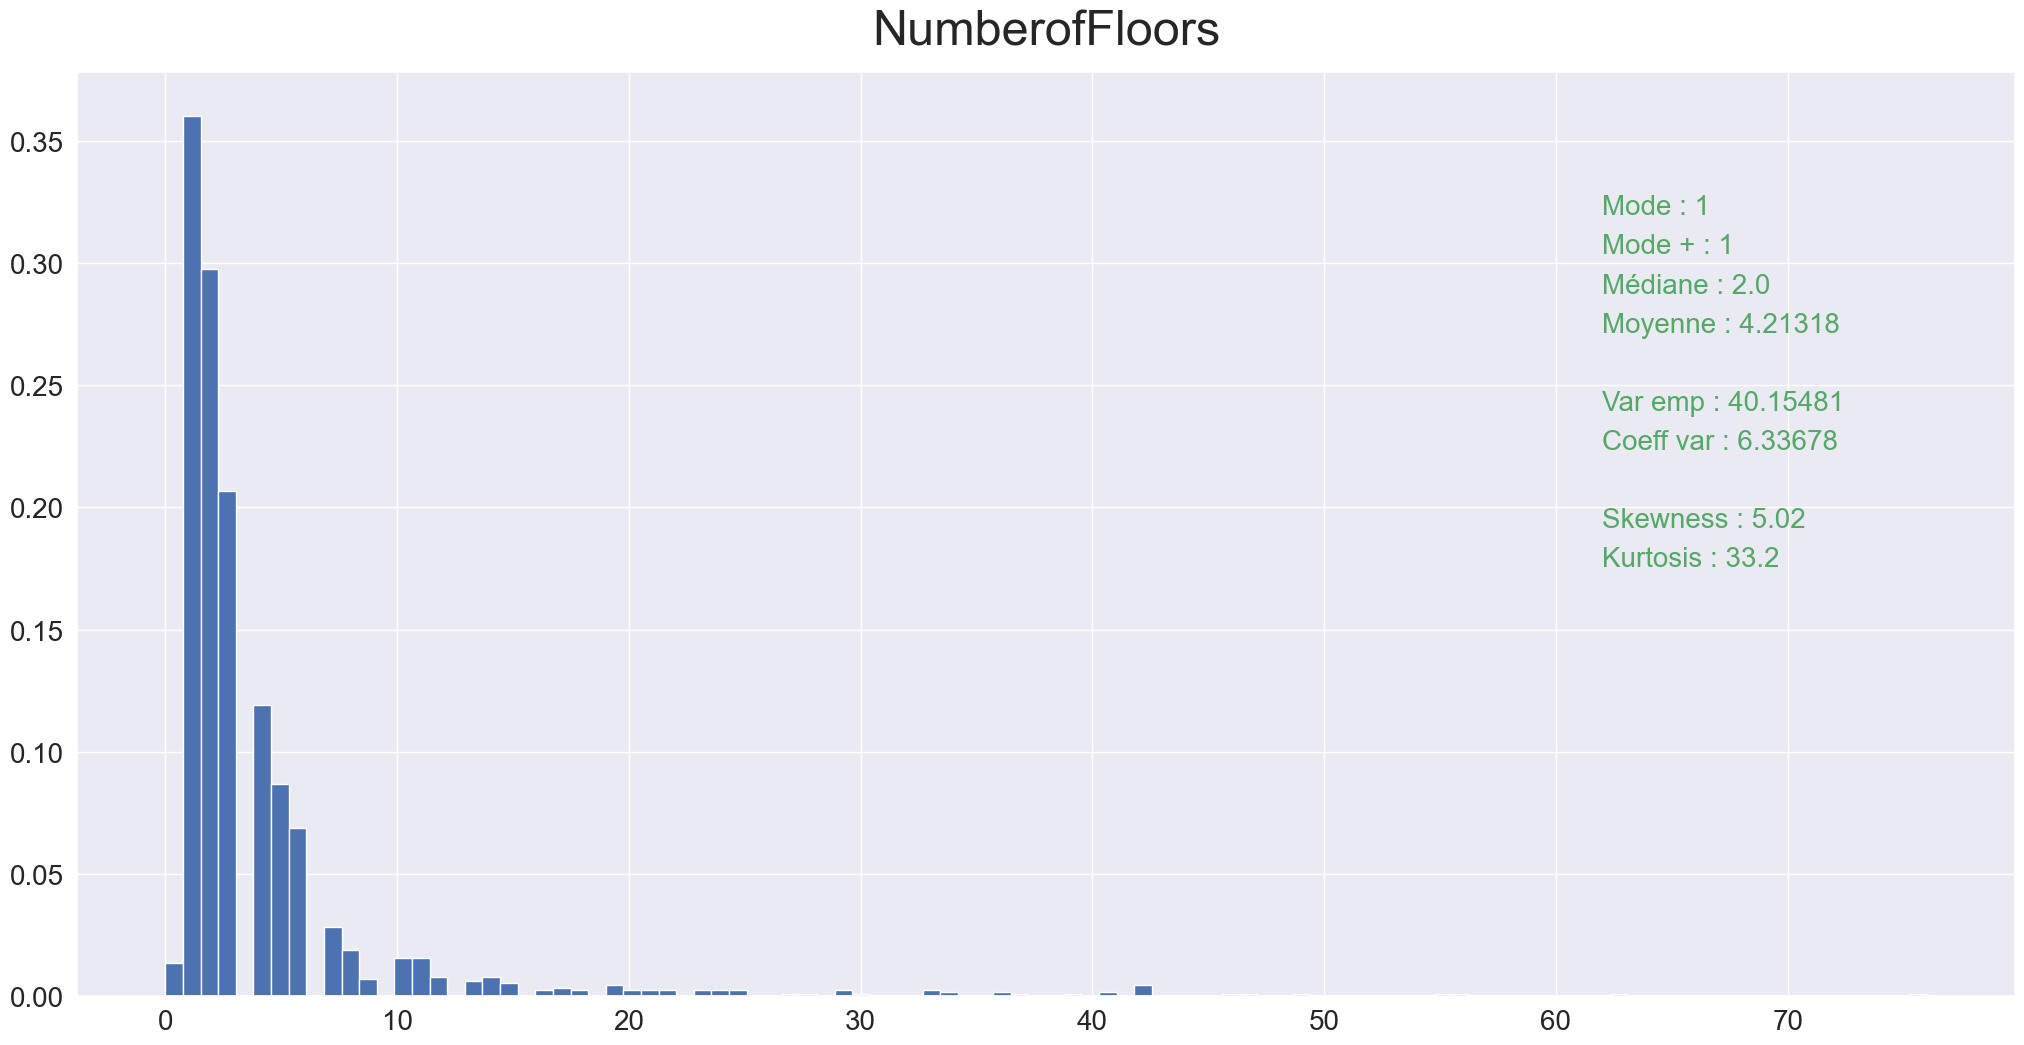

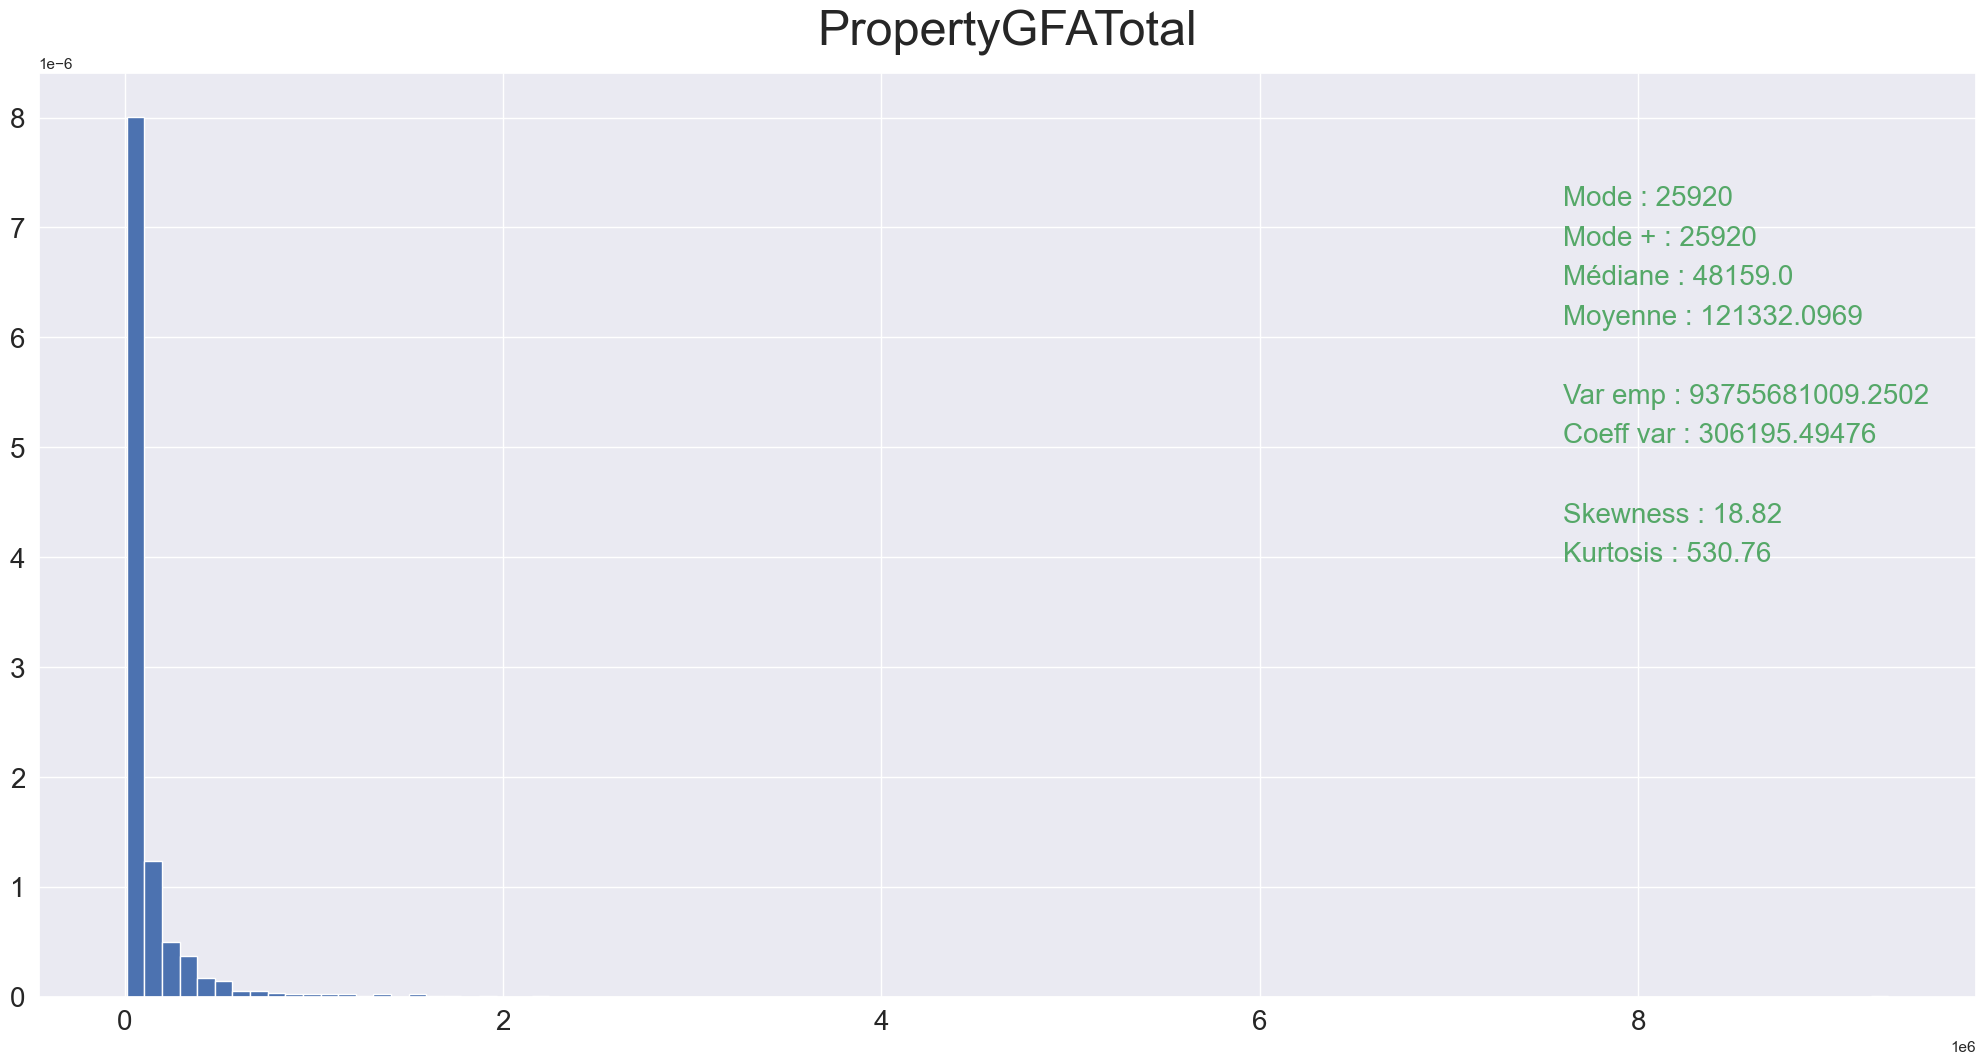

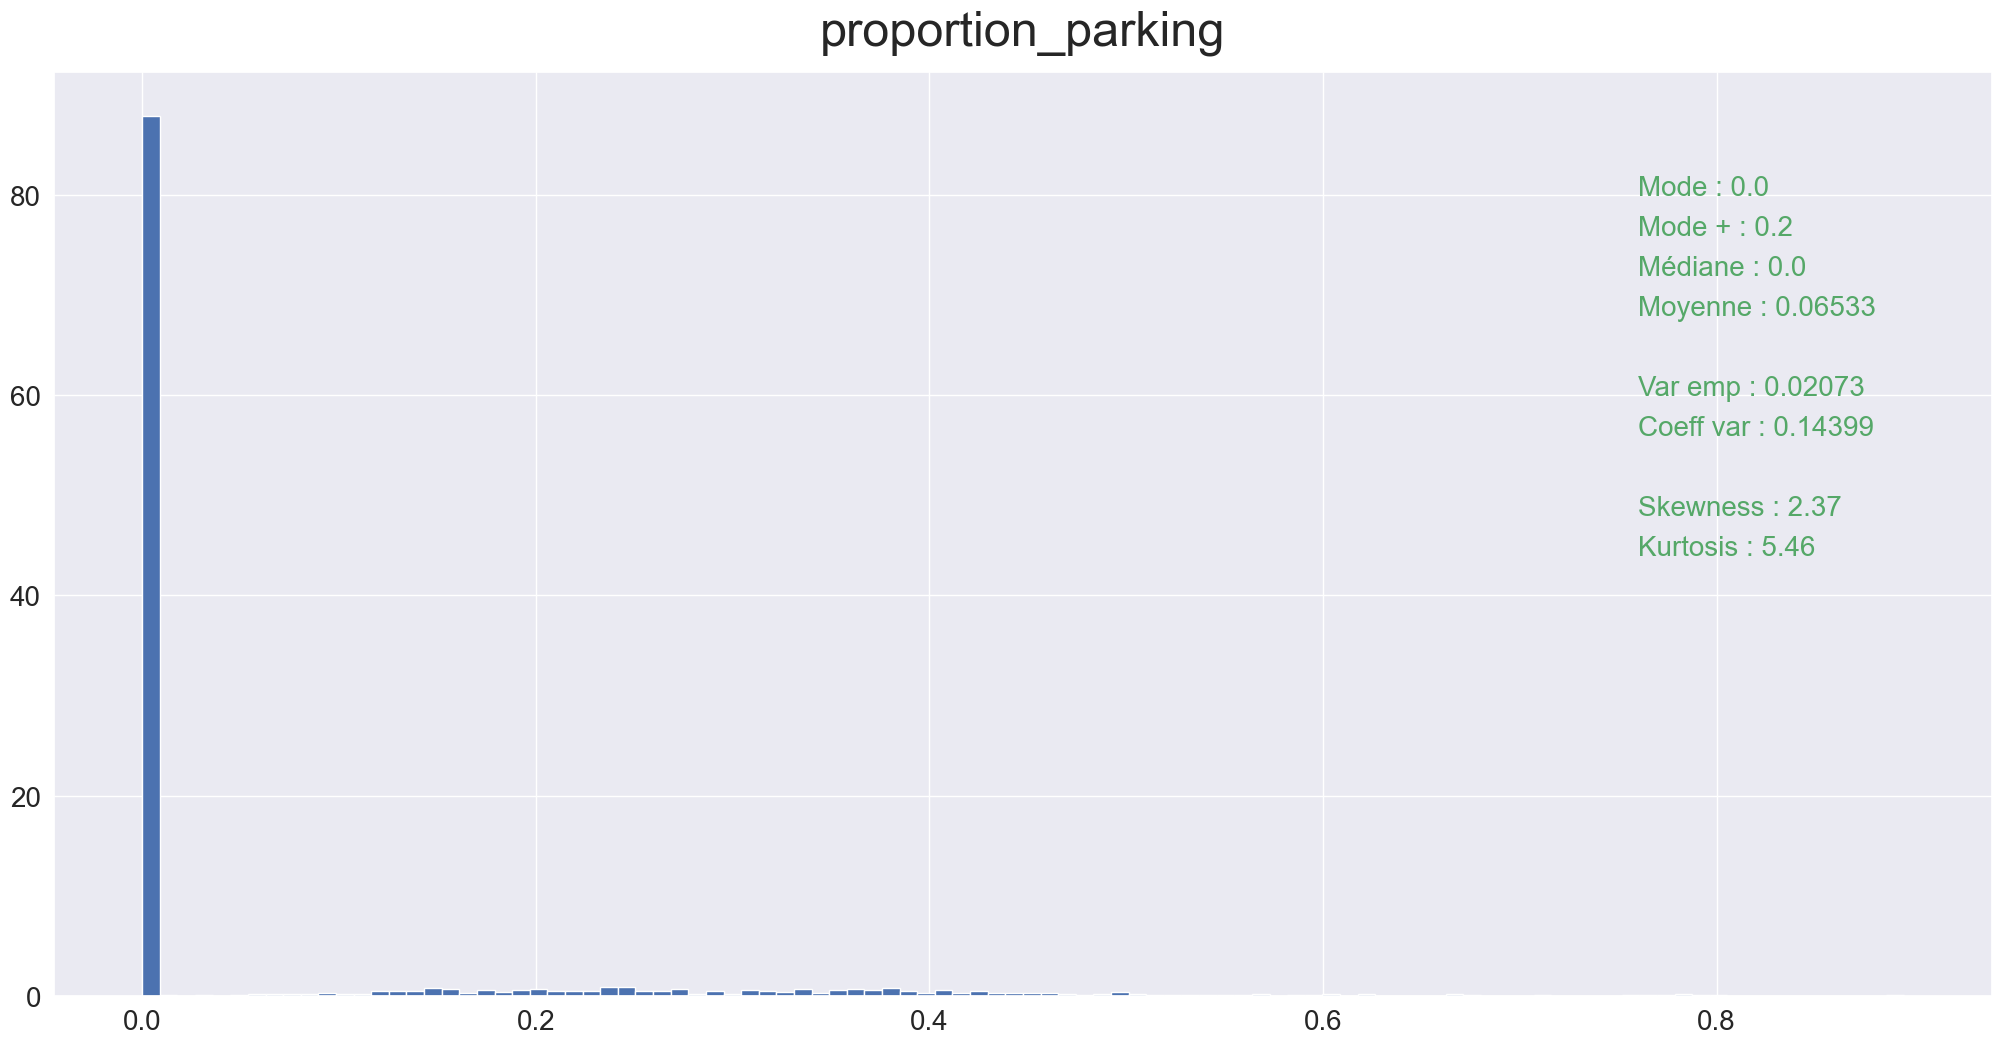

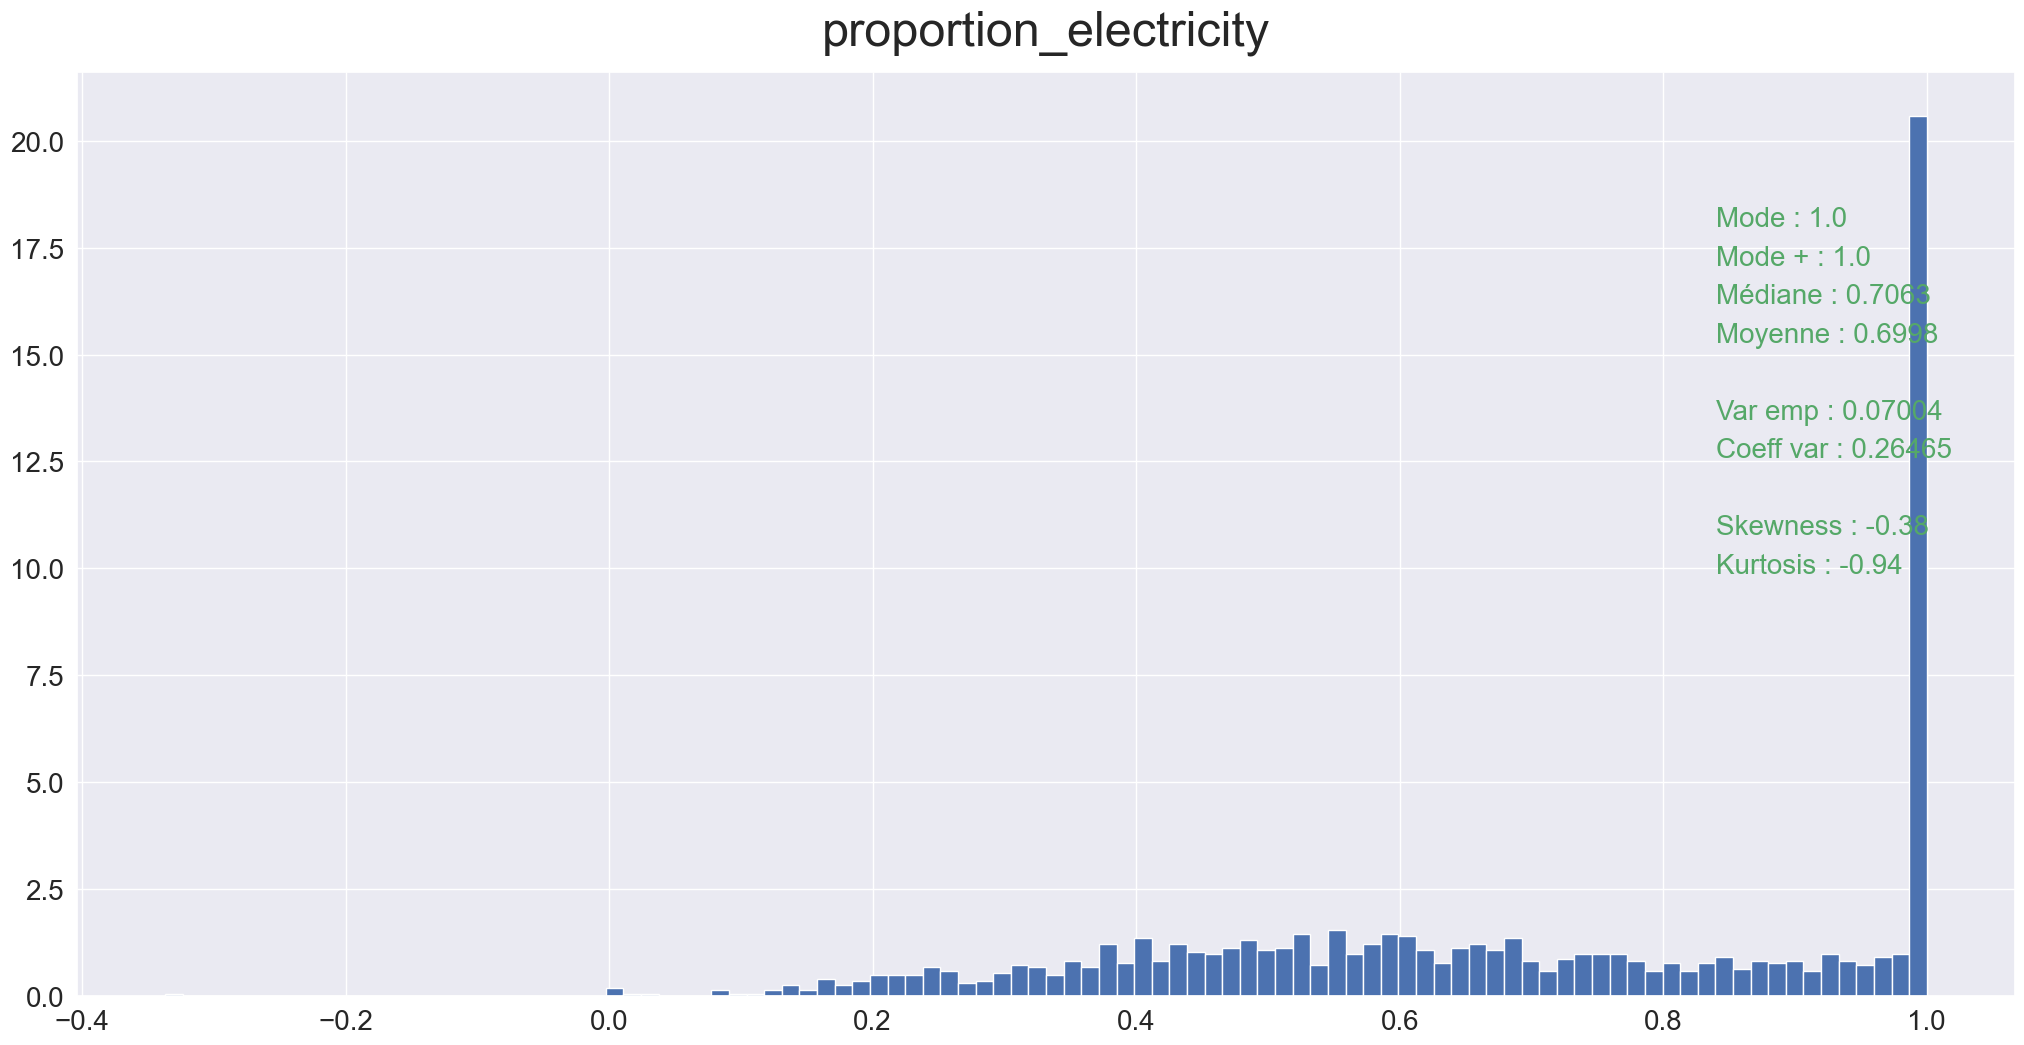

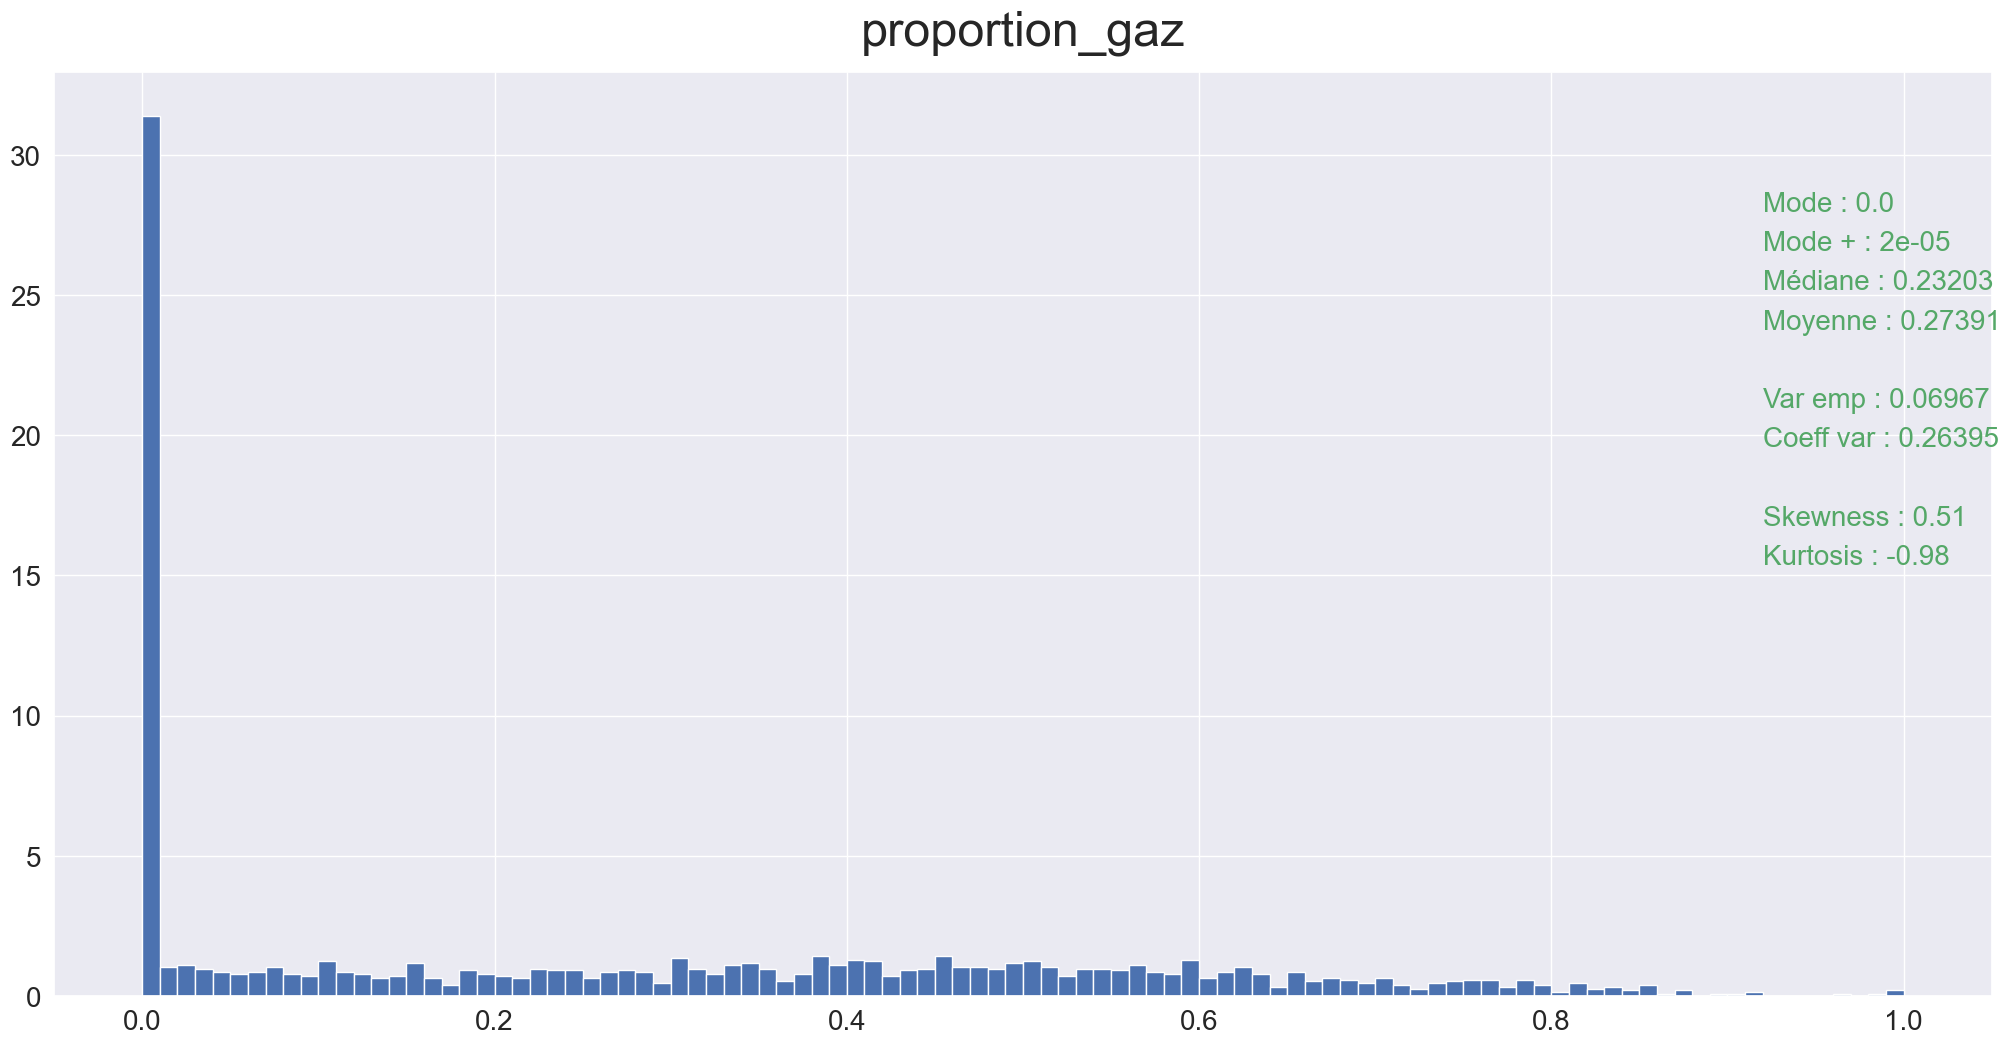

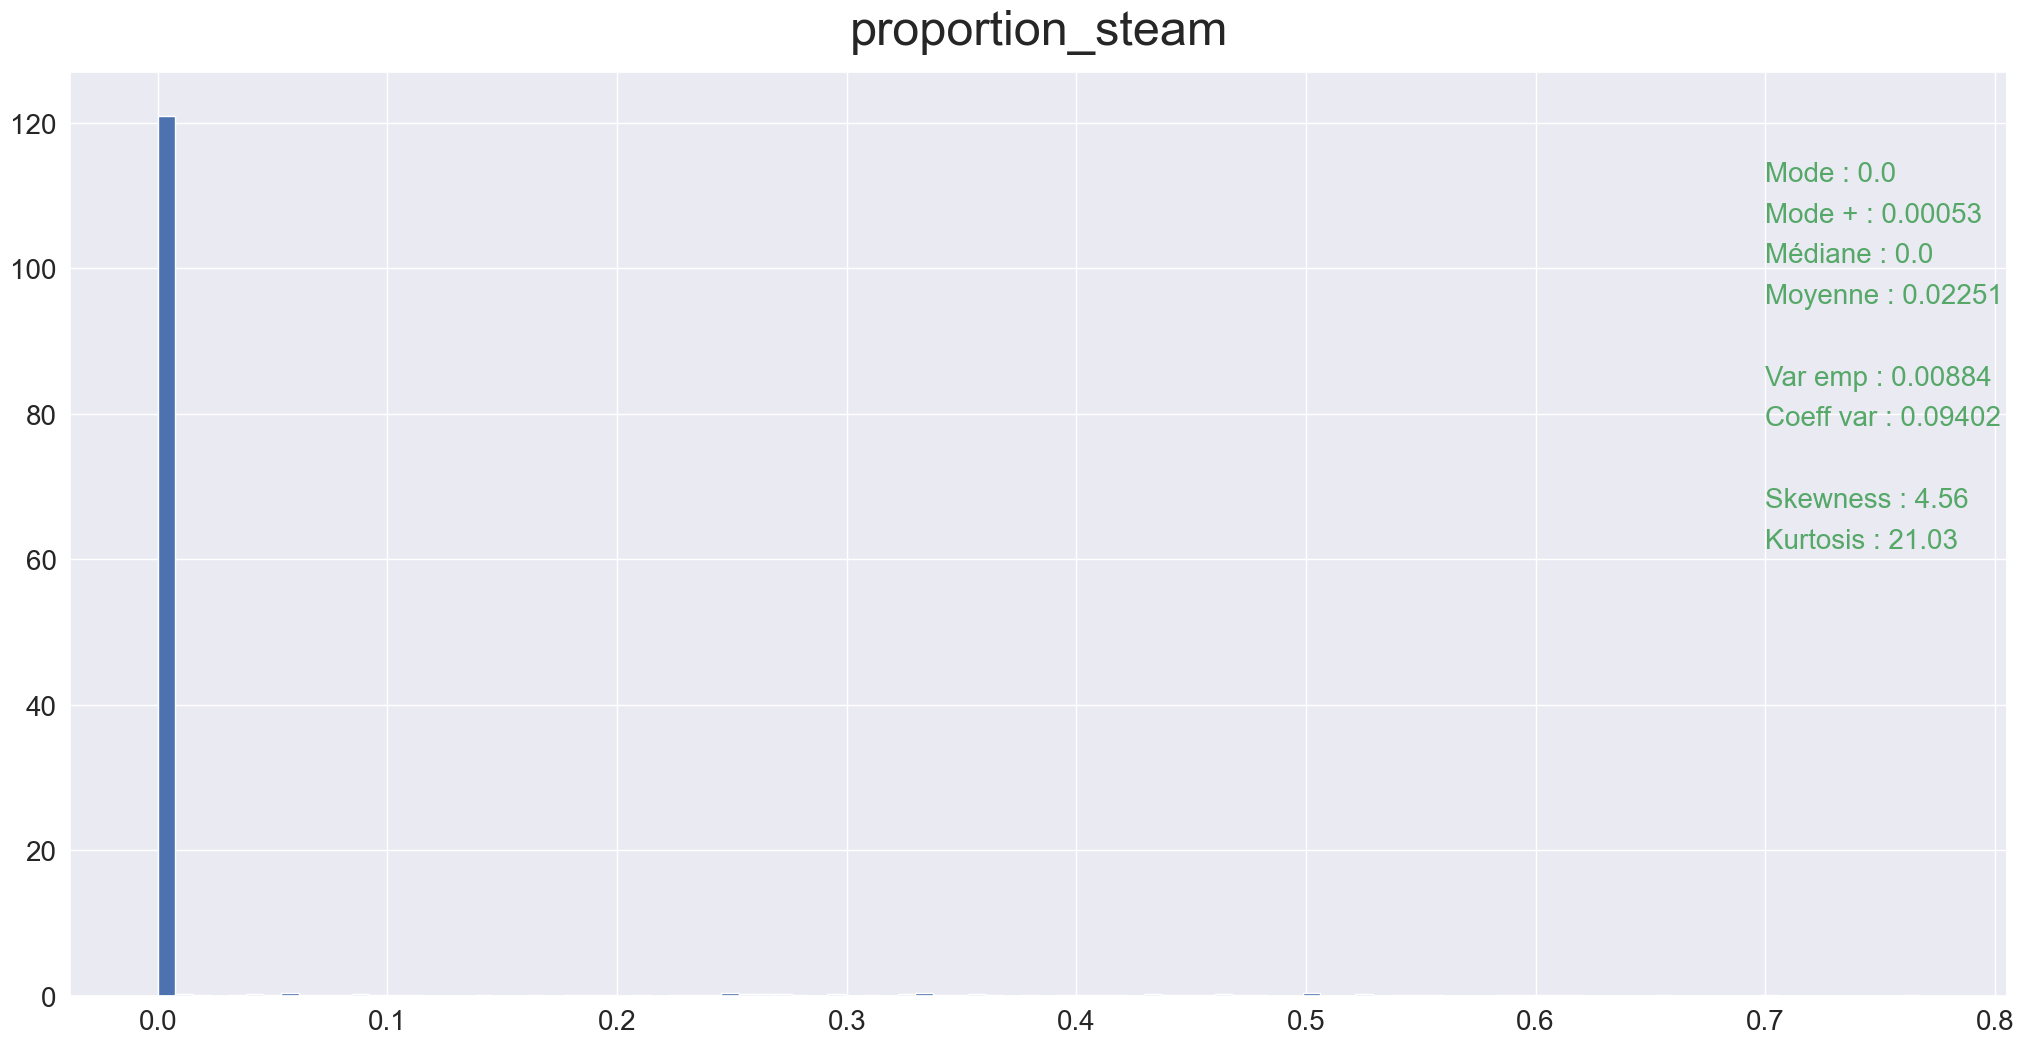

In [ ]:
data5 = data1.copy()

list_skew = []

targets = ['SiteEnergyUse(kBtu)', 'SiteEUI(kBtu/sf)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

for feature in data5.select_dtypes(include=['number']):  # This selects only numerical columns
    if feature not in targets:
        skew = hist_distrib(data5, feature, 100, 5, density=True)
        list_skew.append([feature, skew])
    

In [ ]:
print(list_skew)

# Pour + tard
# skew_starscor ? = hist_distrib(data5, feature, 100, 5, density=True)


[['YearBuilt', -0.28], ['NumberofBuildings', 31.36], ['NumberofFloors', 5.02], ['PropertyGFATotal', 18.82], ['proportion_parking', 2.37], ['proportion_electricity', -0.38], ['proportion_gaz', 0.51], ['proportion_steam', 4.56]]


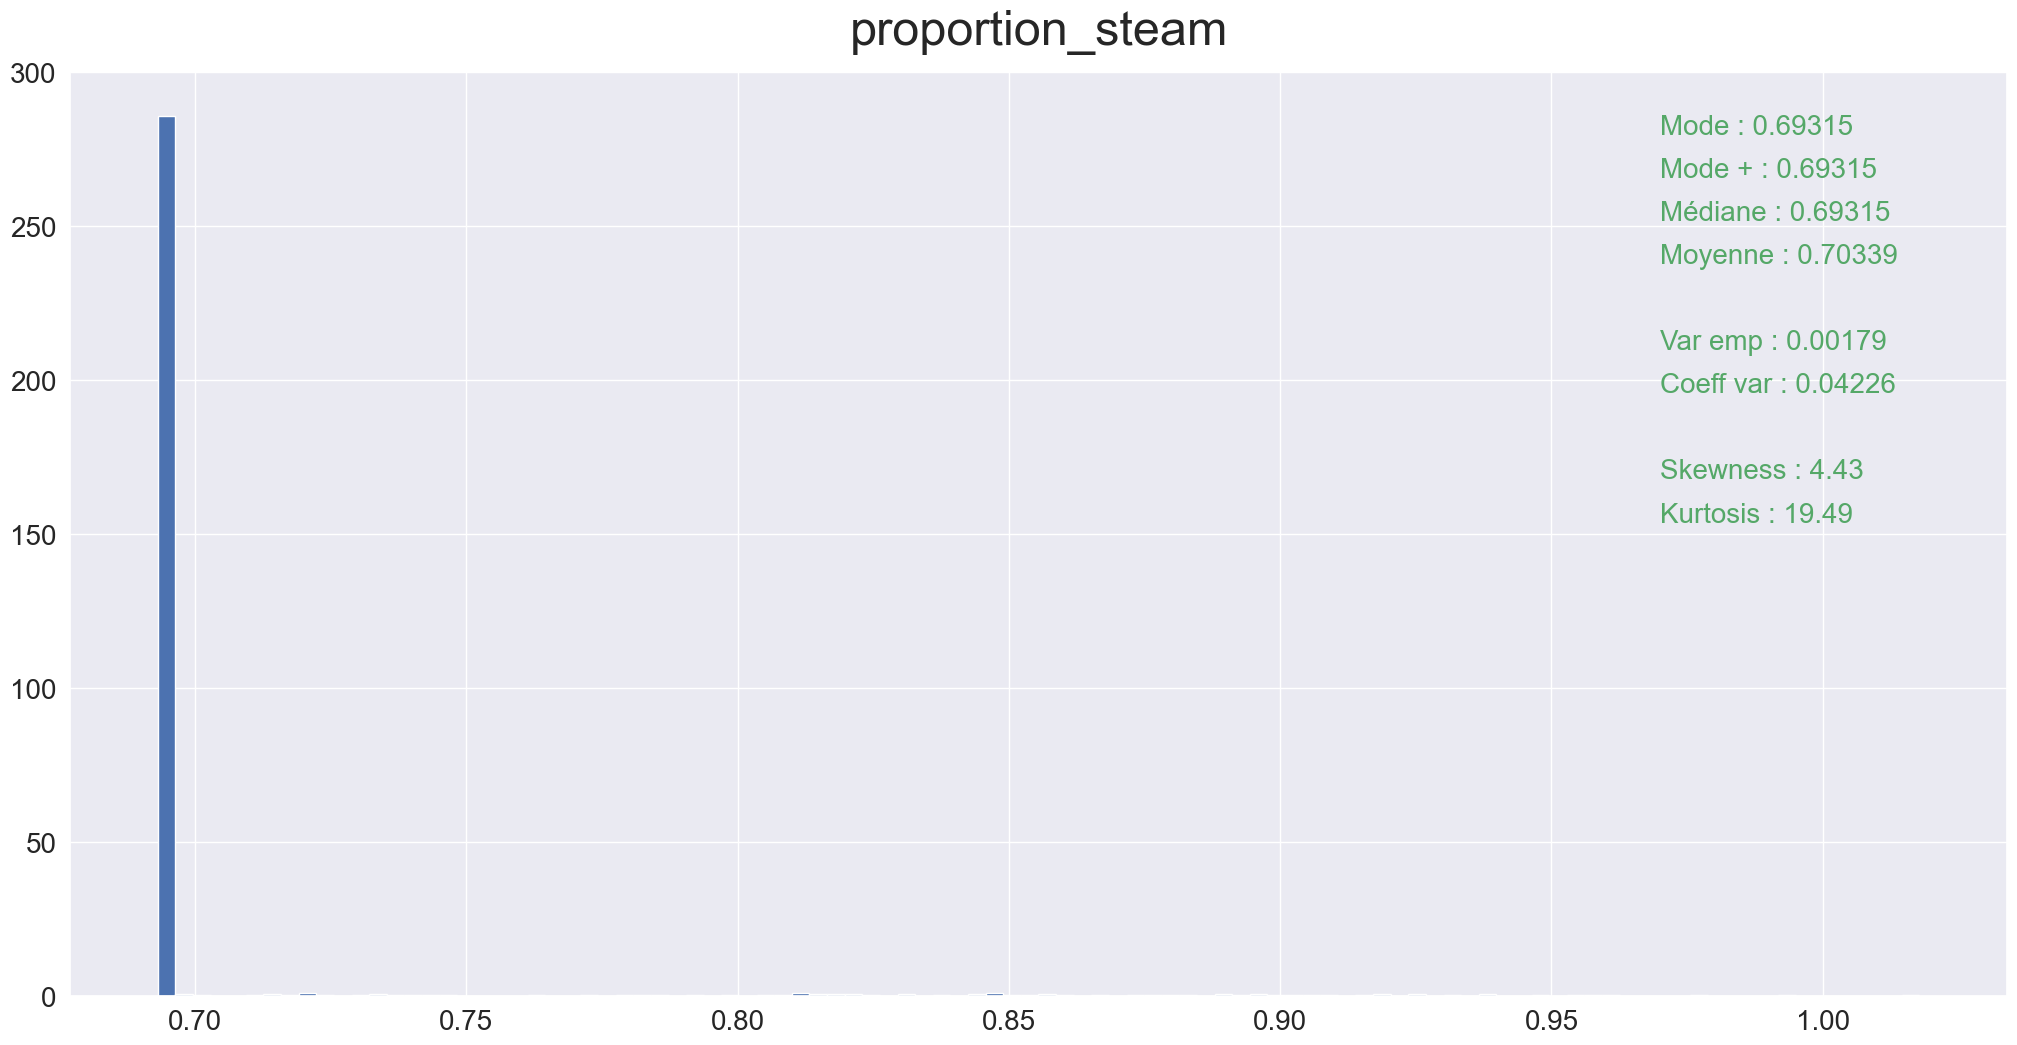

In [ ]:
# Ensuite on fixe un seuil ? skew > 1 ?

def transform_a_skewed_feature(df, feature):
    df[feature] = np.log1p(1 + df[feature])

def transform_skewed_features(df, threshold=1):
    for feature, skewness in list_skew:
        # print(feature, skewness)
        if skewness > threshold:
            transform_a_skewed_feature(df, feature)

data6 = data5.copy()

transform_skewed_features(data5)

# (Verif)
hist_distrib(data5, 'proportion_steam', 100, 5, density=True)

# Ok
data5.to_csv('clean_data5_skew1.csv', sep=',', index=False)

transform_skewed_features(data6, threshold=2)
data6.to_csv('clean_data6_skew2.csv', sep=',', index=False)


### 4.8 Surface inverse

In [ ]:
# Pour les targets secondaires

clean_subset['surface_inverse'] = 1 / clean_subset['PropertyGFATotal']

data7 = clean_subset[chosen_features1 + ['surface_inverse']].copy()

data7.to_csv('clean_data7.csv', sep=',', index=False)


### 4.9 Subset EnergyStarScore

In [ ]:
star_score_df = data1.copy()
star_score_df['star_score'] = clean_subset['ENERGYSTARScore']

star_score_subset = star_score_df.loc[~star_score_df['star_score'].isna(), :].copy()

print(clean_subset.shape)
print(star_score_subset.shape)


(1548, 113)
(997, 16)


In [ ]:
star_score_subset.to_csv('star_score_subset.csv', sep=',', index=False)
